# Лабораторная работа №2: Линейная и логистическая регрессия

### Загрузка библиотек и настройка визуализации

In [20]:
# Основные библиотеки для работы с данными
import pandas as pd
import numpy as np
from datetime import datetime

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Машинное обучение
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import (confusion_matrix, classification_report, 
                           f1_score, precision_score, recall_score,
                           mean_squared_error, mean_absolute_error,
                           r2_score, mean_absolute_percentage_error)

# Предупреждения
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('seaborn-v0_8-darkgrid')
rcParams['figure.figsize'] = (12, 6)
rcParams['font.size'] = 12
sns.set_palette("husl")

### Загрузка и анализ датасета для Классификации (Employee Attrition)

Датасет загружен: 1470 строк, 35 столбцов

--- 1.1 Первичный обзор данных ---
Первые 5 строк датасета:
   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical       

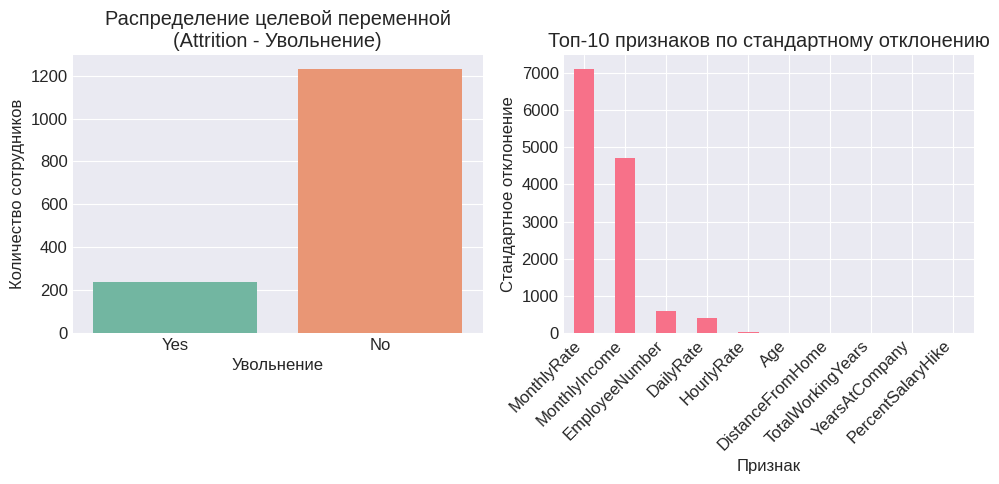


--- 1.7 Корреляционный анализ с целевой переменной ---
Топ-10 признаков по абсолютной корреляции с целевой переменной:
TotalWorkingYears       0.171063
JobLevel                0.169105
YearsInCurrentRole      0.160545
MonthlyIncome           0.159840
Age                     0.159205
YearsWithCurrManager    0.156199
StockOptionLevel        0.137145
YearsAtCompany          0.134392
JobInvolvement          0.130016
JobSatisfaction         0.103481
dtype: float64


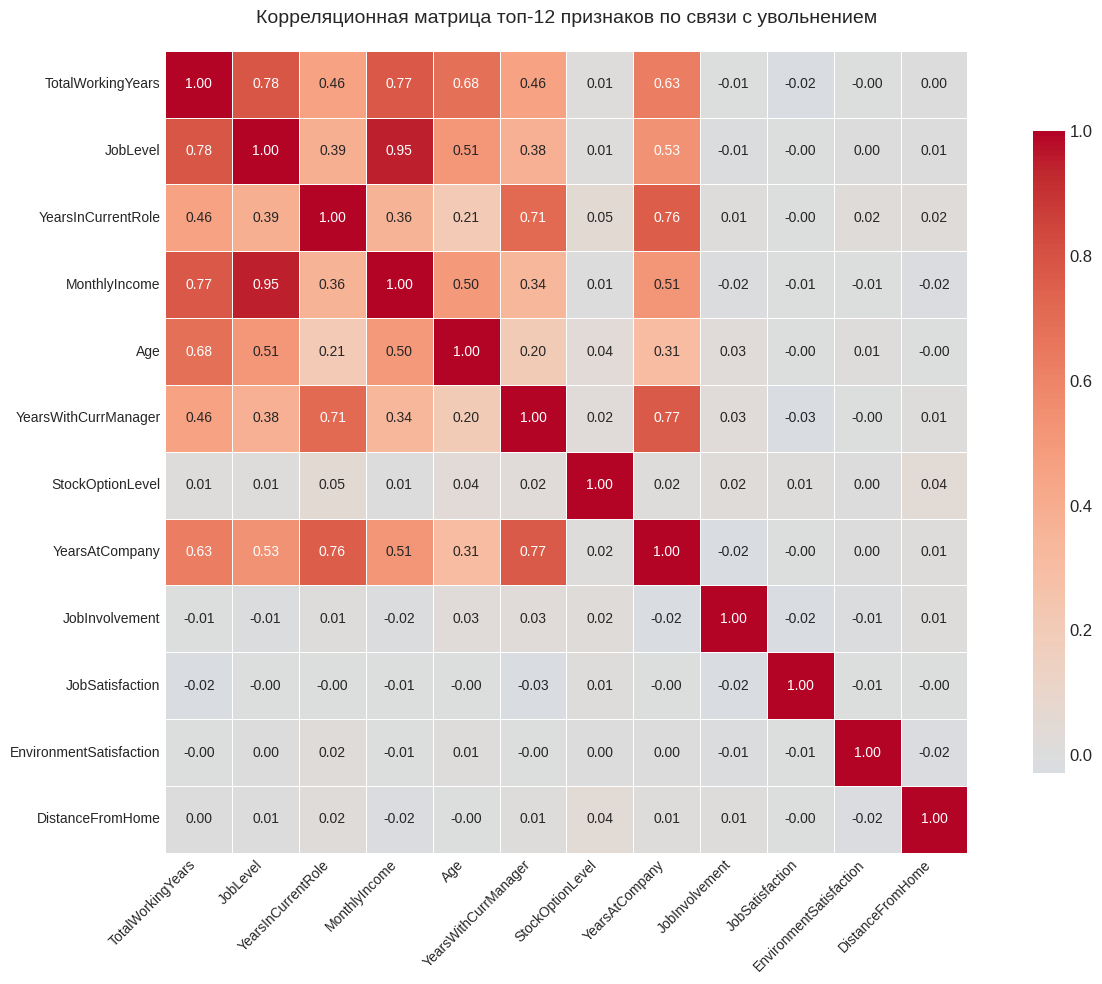

In [21]:
# Ячейка 1: АНАЛИЗ ДАТАСЕТА ДЛЯ КЛАССИФИКАЦИИ - ПРОГНОЗ УВОЛЬНЕНИЙ
# Загрузка датасета
df_class = pd.read_csv('Classification.csv')
print(f"Датасет загружен: {df_class.shape[0]} строк, {df_class.shape[1]} столбцов")

# 1.1 Первичный обзор данных
print("\n--- 1.1 Первичный обзор данных ---")
print("Первые 5 строк датасета:")
print(df_class.head())
print("\nИнформация о типах данных:")
print(df_class.info())

# 1.2 Статистическое описание числовых признаков
print("\n--- 1.2 Статистическое описание числовых признаков ---")
print(df_class.describe())

# 1.3 Проверка пропущенных значений
print("\n--- 1.3 Проверка пропущенных значений ---")
missing_values = df_class.isnull().sum()
missing_percent = (missing_values / len(df_class)) * 100

missing_df = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percent
}).sort_values('Количество пропусков', ascending=False)

print(missing_df[missing_df['Количество пропусков'] > 0])
if missing_df[missing_df['Количество пропусков'] > 0].empty:
    print("Пропуски в данных отсутствуют")

# 1.4 Анализ целевой переменной (Attrition)
print("\n--- 1.4 Анализ целевой переменной (Attrition) ---")
target_counts = df_class['Attrition'].value_counts()
target_percent = df_class['Attrition'].value_counts(normalize=True) * 100

print(f"Распределение классов:\n{target_counts}")
print(f"\nПроцентное соотношение:\n{target_percent.round(2)}")

# Визуализация распределения целевой переменной
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df_class, x='Attrition', palette='Set2')
plt.title('Распределение целевой переменной\n(Attrition - Увольнение)')
plt.xlabel('Увольнение')
plt.ylabel('Количество сотрудников')

# 1.5 Анализ категориальных признаков
print("\n--- 1.5 Анализ категориальных признаков ---")
categorical_cols = df_class.select_dtypes(include=['object']).columns
print(f"Найдено категориальных признаков: {len(categorical_cols)}")

for col in categorical_cols:
    unique_vals = df_class[col].nunique()
    print(f"  {col}: {unique_vals} уникальных значений")

# 1.6 Анализ стандартных отклонений числовых признаков
print("\n--- 1.6 Анализ стандартных отклонений числовых признаков ---")
numeric_cols = df_class.select_dtypes(include=[np.number]).columns
std_dev = df_class[numeric_cols].std()

std_df = pd.DataFrame({
    'Стандартное отклонение': std_dev,
    'Среднее значение': df_class[numeric_cols].mean(),
    'Коэффициент вариации': (std_dev / df_class[numeric_cols].mean() * 100).round(2)
}).sort_values('Стандартное отклонение', ascending=False)

print("Топ-10 признаков с наибольшим стандартным отклонением:")
print(std_df.head(10))

# Визуализация стандартных отклонений
plt.subplot(1, 2, 2)
std_df.head(10)['Стандартное отклонение'].plot(kind='bar')
plt.title('Топ-10 признаков по стандартному отклонению')
plt.xlabel('Признак')
plt.ylabel('Стандартное отклонение')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 1.7 Корреляционный анализ с целевой переменной
print("\n--- 1.7 Корреляционный анализ с целевой переменной ---")
# Преобразование целевой переменной в числовой формат для корреляции
df_class['Attrition_numeric'] = df_class['Attrition'].map({'Yes': 1, 'No': 0})
correlations = df_class[numeric_cols].corrwith(df_class['Attrition_numeric']).abs().sort_values(ascending=False)

print("Топ-10 признаков по абсолютной корреляции с целевой переменной:")
print(correlations.head(10))

# Визуализация корреляционной матрицы
plt.figure(figsize=(14, 10))
top_corr_features = correlations.head(12).index
corr_matrix = df_class[top_corr_features].corr()

# Настройка размера шрифта и формата чисел
annot_kws = {"size": 10, "weight": "normal"}
fmt = '.2f'  # Формат отображения чисел (2 знака после запятой)

heatmap = sns.heatmap(corr_matrix, 
                     annot=True, 
                     fmt=fmt,
                     cmap='coolwarm', 
                     center=0, 
                     square=True, 
                     linewidths=0.5,
                     cbar_kws={"shrink": 0.8},
                     annot_kws=annot_kws)

# Настройка подписей осей
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.title('Корреляционная матрица топ-12 признаков по связи с увольнением', 
          fontsize=14, pad=20)
plt.tight_layout()
plt.show()

### Загрузка и анализ датасета для Регрессии (House Sales)

Датасет загружен: 21613 строк, 21 столбцов

--- 2.1 Первичный обзор данных ---
Первые 5 строк датасета:
           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0        

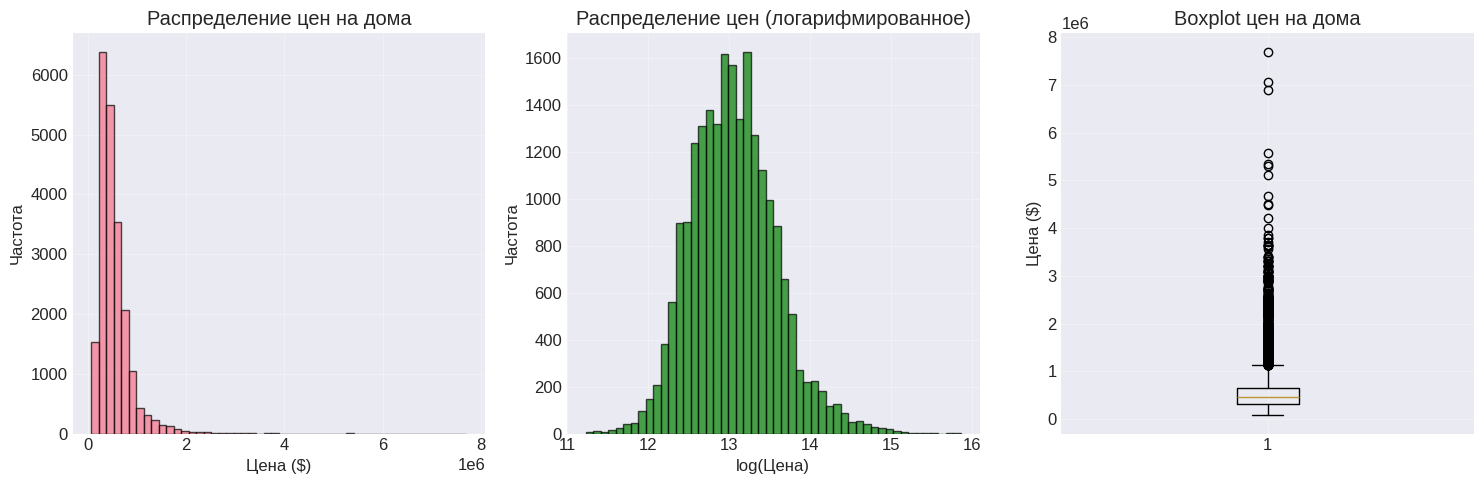


--- 2.5 Анализ стандартных отклонений ---
Топ-10 признаков с наибольшим стандартным отклонением:
               Стандартное отклонение  Среднее значение  Коэффициент вариации
id                       2.876566e+09      4.580302e+09                 62.80
price                    3.671272e+05      5.400881e+05                 67.98
sqft_lot                 4.142051e+04      1.510697e+04                274.18
sqft_lot15               2.730418e+04      1.276846e+04                213.84
sqft_living              9.184409e+02      2.079900e+03                 44.16
sqft_above               8.280910e+02      1.788391e+03                 46.30
sqft_living15            6.853913e+02      1.986552e+03                 34.50
sqft_basement            4.425750e+02      2.915090e+02                151.82
yr_renovated             4.016792e+02      8.440226e+01                475.91
zipcode                  5.350503e+01      9.807794e+04                  0.05

--- 2.6 Корреляция с целевой переменной (pr

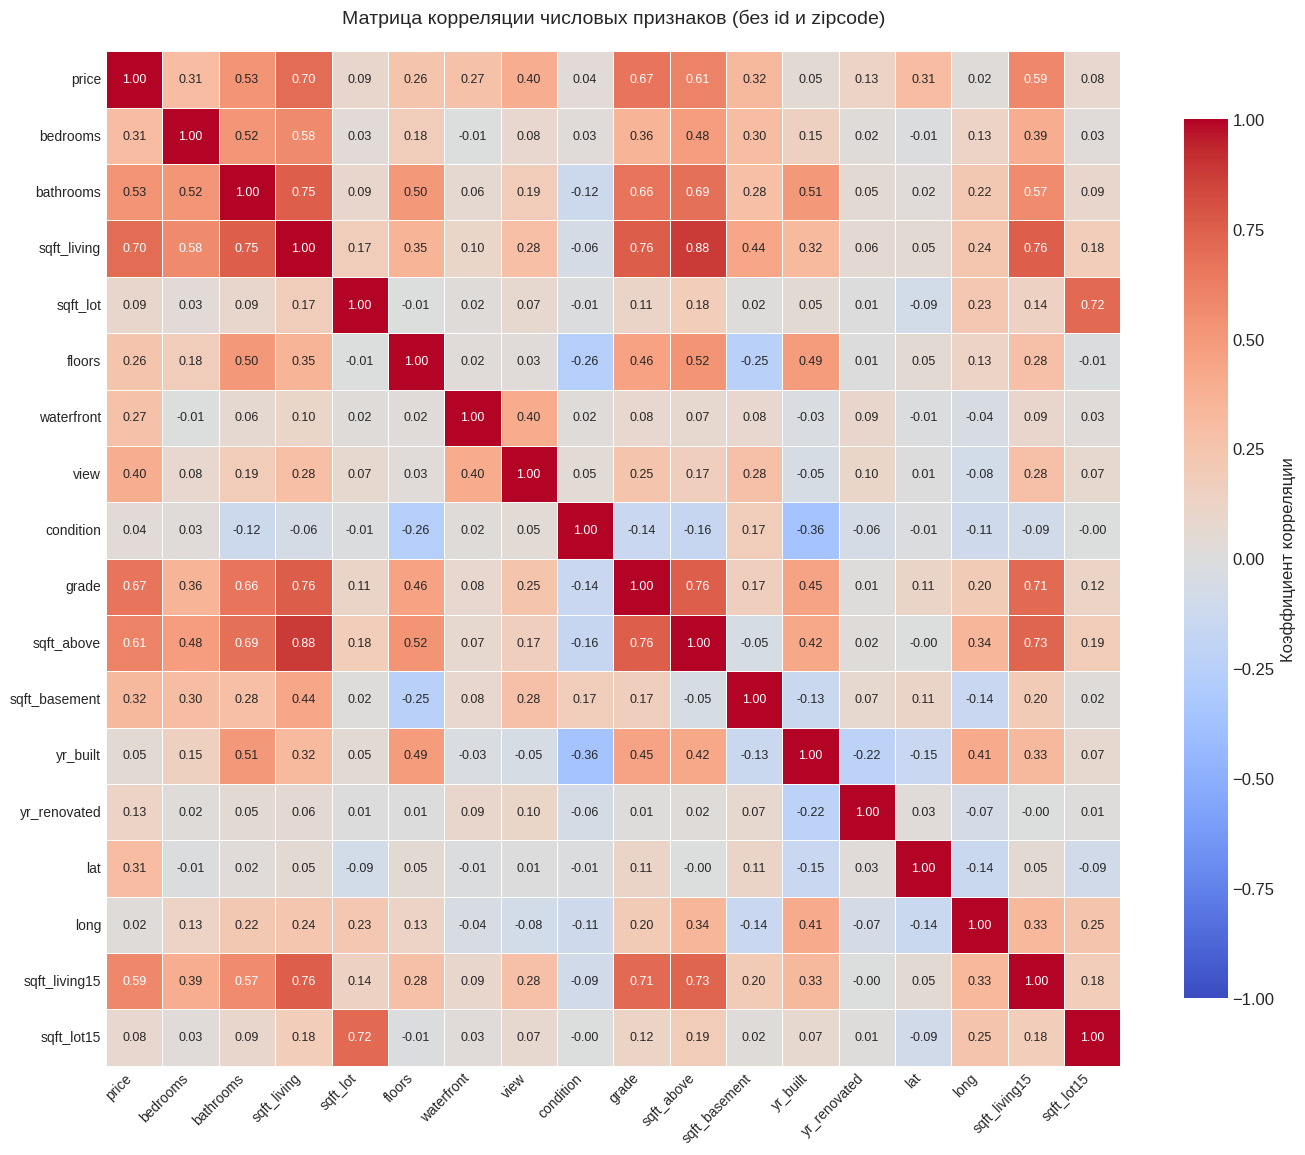


--- Анализ наиболее коррелирующих признаков ---
Пары признаков с высокой корреляцией (|r| > 0.7):
------------------------------------------------------------
  sqft_living     и sqft_above      => 0.877
  sqft_living     и grade           => 0.763
  sqft_living     и sqft_living15   => 0.756
  grade           и sqft_above      => 0.756
  bathrooms       и sqft_living     => 0.755
  sqft_above      и sqft_living15   => 0.732
  sqft_lot        и sqft_lot15      => 0.719
  grade           и sqft_living15   => 0.713
  price           и sqft_living     => 0.702

--- 2.7 Анализ выбросов в ключевых признаках ---
sqft_living    :  572 выбросов (2.6%)
sqft_lot       : 2425 выбросов (11.2%)
bedrooms       :  546 выбросов (2.5%)
bathrooms      :  571 выбросов (2.6%)
grade          : 1911 выбросов (8.8%)


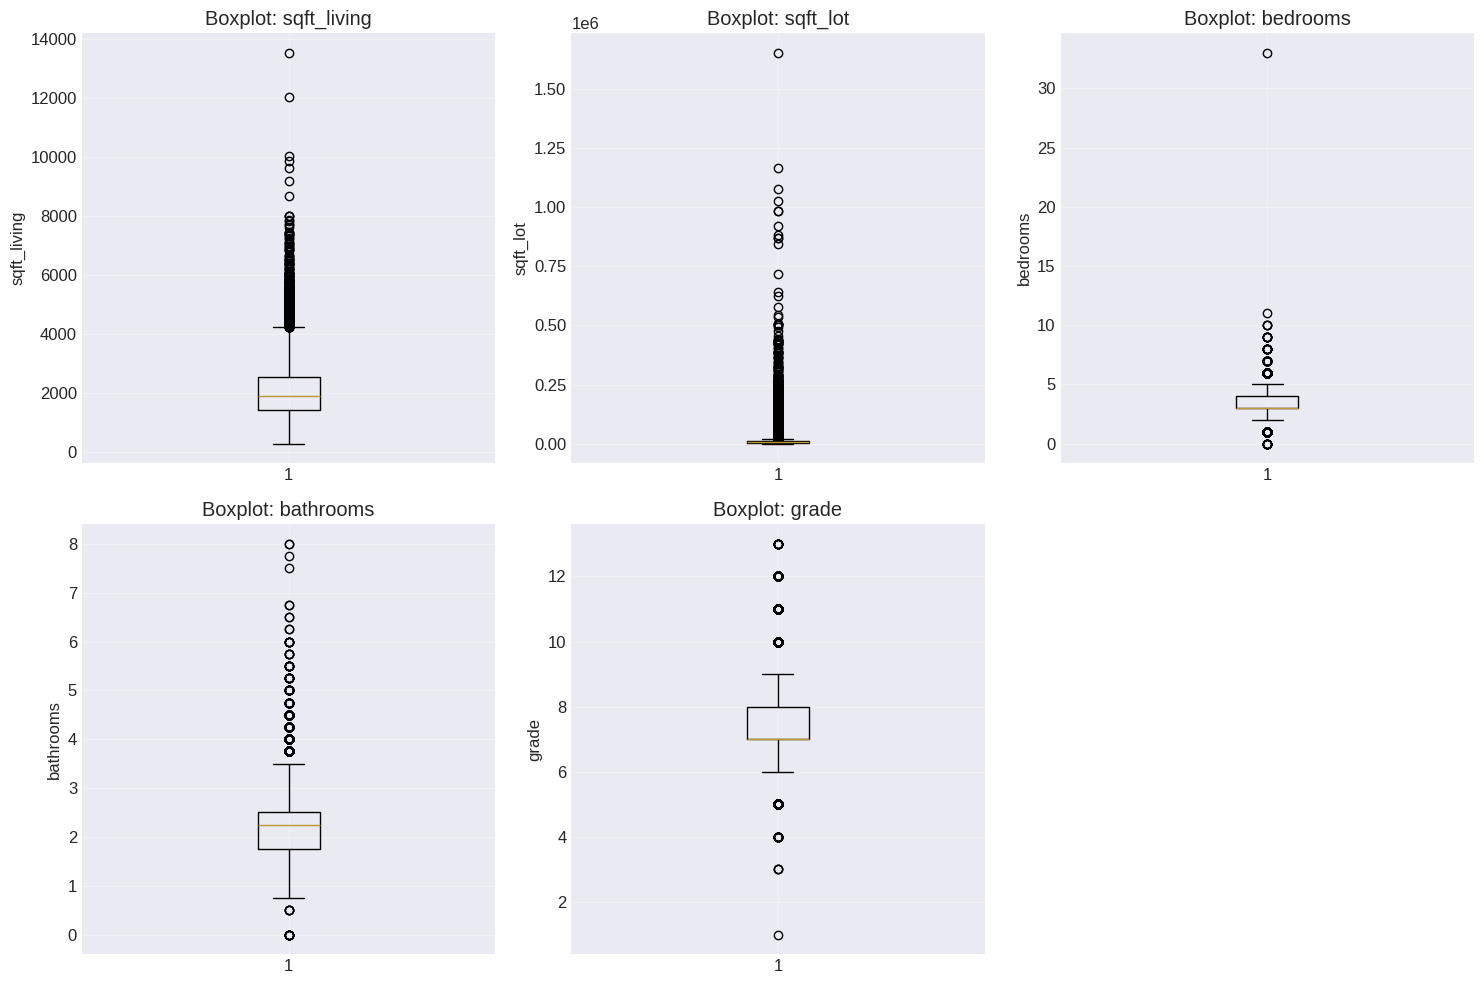

In [22]:
# Ячейка 2: АНАЛИЗ ДАТАСЕТА ДЛЯ РЕГРЕССИИ - ПРОГНОЗ ЦЕН НА ДОМА
# Загрузка датасета
df_reg = pd.read_csv('Regression.csv')
print(f"Датасет загружен: {df_reg.shape[0]} строк, {df_reg.shape[1]} столбцов")

# 2.1 Первичный обзор данных
print("\n--- 2.1 Первичный обзор данных ---")
print("Первые 5 строк датасета:")
print(df_reg.head())
print("\nИнформация о типах данных:")
print(df_reg.info())

# 2.2 Статистическое описание
print("\n--- 2.2 Статистическое описание ---")
print(df_reg.describe())

# 2.3 Проверка пропущенных значений
print("\n--- 2.3 Проверка пропущенных значений ---")
missing_values_reg = df_reg.isnull().sum()
missing_percent_reg = (missing_values_reg / len(df_reg)) * 100

missing_df_reg = pd.DataFrame({
    'Количество пропусков': missing_values_reg,
    'Процент пропусков': missing_percent_reg
}).sort_values('Количество пропусков', ascending=False)

print(missing_df_reg[missing_df_reg['Количество пропусков'] > 0])
if missing_df_reg[missing_df_reg['Количество пропусков'] > 0].empty:
    print("Пропуски в данных отсутствуют")

# 2.4 Анализ целевой переменной (price)
print("\n--- 2.4 Анализ целевой переменной (price) ---")
price_stats = {
    'Медиана': df_reg['price'].median(),
    'Среднее значение': df_reg['price'].mean(),
    'Стандартное отклонение': df_reg['price'].std(),
    'Минимальная цена': df_reg['price'].min(),
    'Максимальная цена': df_reg['price'].max(),
    'Коэффициент вариации': (df_reg['price'].std() / df_reg['price'].mean() * 100)
}

for key, value in price_stats.items():
    if key != 'Коэффициент вариации':
        print(f"{key}: ${value:,.2f}")
    else:
        print(f"{key}: {value:.2f}%")

# Визуализация распределения цены
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df_reg['price'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Распределение цен на дома')
plt.xlabel('Цена ($)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(np.log1p(df_reg['price']), bins=50, edgecolor='black', alpha=0.7, color='green')
plt.title('Распределение цен (логарифмированное)')
plt.xlabel('log(Цена)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.boxplot(df_reg['price'])
plt.title('Boxplot цен на дома')
plt.ylabel('Цена ($)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2.5 Анализ стандартных отклонений
print("\n--- 2.5 Анализ стандартных отклонений ---")
numeric_cols_reg = df_reg.select_dtypes(include=[np.number]).columns
std_dev_reg = df_reg[numeric_cols_reg].std()

std_df_reg = pd.DataFrame({
    'Стандартное отклонение': std_dev_reg,
    'Среднее значение': df_reg[numeric_cols_reg].mean(),
    'Коэффициент вариации': (std_dev_reg / df_reg[numeric_cols_reg].mean() * 100).round(2)
}).sort_values('Стандартное отклонение', ascending=False)

print("Топ-10 признаков с наибольшим стандартным отклонением:")
print(std_df_reg.head(10))

# 2.6 Корреляция с целевой переменной (price)
print("\n--- 2.6 Корреляция с целевой переменной (price) ---")

# Исключаем неинформативные признаки (id, zipcode - это категориальные коды, а не числовые признаки)
exclude_features = ['id', 'zipcode']
numeric_features = [col for col in numeric_cols_reg if col not in exclude_features]

correlations_reg = df_reg[numeric_features].corrwith(df_reg['price']).abs().sort_values(ascending=False)

print("Топ-10 признаков по абсолютной корреляции с ценой:")
for i, (feature, corr_value) in enumerate(correlations_reg.head(10).items(), 1):
    actual_corr = df_reg[numeric_features].corrwith(df_reg['price'])[feature]
    print(f"{i:2}. {feature:20} {actual_corr:+.3f}")

# Визуализация матрицы корреляции
print("\n--- Матрица корреляции (без id и zipcode) ---")

# Создаем матрицу корреляции для осмысленных числовых признаков
corr_matrix = df_reg[numeric_features].corr()

# Определяем размер фигуры в зависимости от количества признаков
n_features = len(corr_matrix.columns)
figsize = max(14, n_features * 0.6), max(12, n_features * 0.6)

plt.figure(figsize=figsize)

# Создаем тепловую карту корреляций
sns.heatmap(corr_matrix, 
           annot=True, 
           fmt='.2f',
           cmap='coolwarm', 
           vmin=-1, vmax=1,
           center=0,
           square=True,
           linewidths=0.5,
           cbar_kws={"shrink": 0.8, "label": "Коэффициент корреляции"},
           annot_kws={"size": 9})

plt.title('Матрица корреляции числовых признаков (без id и zipcode)', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

# Дополнительная информация о наиболее коррелирующих признаках
print("\n--- Анализ наиболее коррелирующих признаков ---")

# Находим пары признаков с высокой корреляцией
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            feat1 = corr_matrix.columns[i]
            feat2 = corr_matrix.columns[j]
            high_corr_pairs.append((feat1, feat2, corr_value))

if high_corr_pairs:
    print("Пары признаков с высокой корреляцией (|r| > 0.7):")
    print("-" * 60)
    for feat1, feat2, corr_value in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {feat1:15} и {feat2:15} => {corr_value:.3f}")
else:
    print("Нет пар признаков с высокой корреляцией (|r| > 0.7)")

# 2.7 Анализ выбросов в ключевых признаках
print("\n--- 2.7 Анализ выбросов в ключевых признаках ---")
key_features = ['sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms', 'grade']

# Базовая информация о выбросах
for feature in key_features:
    if feature in df_reg.columns:
        Q1 = df_reg[feature].quantile(0.25)
        Q3 = df_reg[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df_reg[(df_reg[feature] < lower_bound) | (df_reg[feature] > upper_bound)]
        n_outliers = len(outliers)
        
        print(f"{feature:15}: {n_outliers:4} выбросов ({n_outliers/len(df_reg)*100:.1f}%)")

# Визуализация
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    if feature in df_reg.columns:
        plt.subplot(2, 3, i)
        plt.boxplot(df_reg[feature].dropna())
        plt.title(f'Boxplot: {feature}')
        plt.ylabel(feature)
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 2. Создание безлайна и оценка качества

### Предобработка данных для задачи классификации

In [23]:
# Ячейка 3: ПРЕДОБРАБОТКА ДАННЫХ ДЛЯ ЗАДАЧИ КЛАССИФИКАЦИИ
# 3.1 Создаем копию данных для обработки
df_class_processed = df_class.copy()
print("Создана копия данных для предобработки")

# 3.2 Удаляем неинформативные признаки И Attrition_numeric
print("\n--- 3.1 Удаление неинформативных признаков ---")

columns_to_drop = [
    'EmployeeCount',      # Все значения = 1
    'EmployeeNumber',     # Уникальный идентификатор
    'Over18',             # Все значения = 'Y'
    'StandardHours',      # Все значения = 80
    'Attrition_numeric'   
]

print(f"Удаляем признаки: {columns_to_drop}")
df_class_processed = df_class_processed.drop(columns=columns_to_drop, errors='ignore')
print(f"Осталось признаков: {df_class_processed.shape[1]}")

# 3.3 Преобразование целевой переменной
print("\n--- 3.3 Преобразование целевой переменной ---")
df_class_processed['Attrition'] = df_class_processed['Attrition'].map({'Yes': 1, 'No': 0})
print("Целевая переменная Attrition преобразована: Yes -> 1, No -> 0")

# ВАЖНО: Анализ дисбаланса для логистической регрессии
print(f"\nСоотношение классов: {sum(df_class_processed['Attrition'] == 0)}:1")
print(f"Процент класса 'Yes' (уволился): {df_class_processed['Attrition'].mean()*100:.1f}%")
print("Для логистической регрессии с таким дисбалансом рекомендуется:")
print("1. Использовать class_weight='balanced' при обучении")
print("2. Или использовать техники семплирования")

# 3.4 Обработка категориальных признаков
print("\n--- 3.4 Обработка категориальных признаков ---")

categorical_cols = df_class_processed.select_dtypes(include=['object']).columns.tolist()
print(f"Категориальные признаки для обработки ({len(categorical_cols)}):")

# Проверяем типы категориальных признаков
for col in categorical_cols:
    unique_vals = df_class_processed[col].nunique()
    sample_vals = df_class_processed[col].unique()[:3] if unique_vals > 3 else df_class_processed[col].unique()
    print(f"  {col}: {unique_vals} уникальных значений, пример: {sample_vals}")

# One-Hot Encoding
print("\nПрименяем One-Hot Encoding для категориальных признаков...")
df_class_encoded = pd.get_dummies(df_class_processed, columns=categorical_cols, drop_first=True)
print(f"После кодирования: {df_class_encoded.shape[1]} признаков")
print("Примечание: drop_first=True предотвращает мультиколлинеарность (ловушку дамми-переменных)")

# 3.5 Разделение на признаки и целевую переменную
print("\n--- 3.5 Разделение данных ---")
X_class = df_class_encoded.drop('Attrition', axis=1)
y_class = df_class_encoded['Attrition']

print(f"Признаки (X): {X_class.shape}")
print(f"Целевая переменная (y): {y_class.shape}")
print(f"Имена признаков: {list(X_class.columns[:5])}...")  # Показываем первые 5 признаков

# 3.6 Стандартизация признаков
print("\n--- 3.6 Стандартизация признаков ---")
print("ВАЖНО: Для логистической регрессии стандартизация ускоряет сходимость и улучшает производительность")
scaler_class = StandardScaler()
X_class_scaled = scaler_class.fit_transform(X_class)

print(f"Признаки после стандартизации: {X_class_scaled.shape}")
print(f"Среднее значение первого признака: {X_class_scaled[:, 0].mean():.6f}")
print(f"Стандартное отклонение первого признака: {X_class_scaled[:, 0].std():.6f}")
print("Все признаки теперь имеют mean=0 и std=1")

# 3.7 Разделение на обучающую и тестовую выборки
print("\n--- 3.7 Разделение на train/test ---")
print("Используем stratify=y_class для сохранения пропорций классов в выборках")
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class_scaled, y_class, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_class  # Важно сохранить распределение классов
)

print(f"Обучающая выборка: {X_train_class.shape}")
print(f"Тестовая выборка: {X_test_class.shape}")
print(f"Распределение классов в обучающей выборке: {np.bincount(y_train_class)}")
print(f"  -> Класс 0 (Не уволился): {y_train_class.value_counts()[0]} ({y_train_class.value_counts(normalize=True)[0]*100:.1f}%)")
print(f"  -> Класс 1 (Уволился): {y_train_class.value_counts()[1]} ({y_train_class.value_counts(normalize=True)[1]*100:.1f}%)")
print(f"Распределение классов в тестовой выборке: {np.bincount(y_test_class)}")
print(f"  -> Класс 0 (Не уволился): {y_test_class.value_counts()[0]} ({y_test_class.value_counts(normalize=True)[0]*100:.1f}%)")
print(f"  -> Класс 1 (Уволился): {y_test_class.value_counts()[1]} ({y_test_class.value_counts(normalize=True)[1]*100:.1f}%)")

# Дополнительно: Сохраняем имена признаков для интерпретации модели
feature_names_class = X_class.columns.tolist()
print(f"\nСохранены имена {len(feature_names_class)} признаков для интерпретации модели")

Создана копия данных для предобработки

--- 3.1 Удаление неинформативных признаков ---
Удаляем признаки: ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours', 'Attrition_numeric']
Осталось признаков: 31

--- 3.3 Преобразование целевой переменной ---
Целевая переменная Attrition преобразована: Yes -> 1, No -> 0

Соотношение классов: 1233:1
Процент класса 'Yes' (уволился): 16.1%
Для логистической регрессии с таким дисбалансом рекомендуется:
1. Использовать class_weight='balanced' при обучении
2. Или использовать техники семплирования

--- 3.4 Обработка категориальных признаков ---
Категориальные признаки для обработки (7):
  BusinessTravel: 3 уникальных значений, пример: ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
  Department: 3 уникальных значений, пример: ['Sales' 'Research & Development' 'Human Resources']
  EducationField: 6 уникальных значений, пример: ['Life Sciences' 'Other' 'Medical']
  Gender: 2 уникальных значений, пример: ['Female' 'Male']
  JobRole: 9 уникаль

### Предобработка данных для задачи регрессии

In [24]:
# Ячейка 4: ПРЕДОБРАБОТКА ДАННЫХ ДЛЯ ЗАДАЧИ РЕГРЕССИИ
# 4.1 Создаем копию данных для обработки
df_reg_processed = df_reg.copy()
print("Создана копия данных для предобработки")

# 4.2 Удаляем неинформативные признаки
print("\n--- 4.1 Удаление неинформативных признаков ---")

columns_to_drop_reg = ['id', 'zipcode']
print(f"Удаляем признаки: {columns_to_drop_reg}")
df_reg_processed = df_reg_processed.drop(columns=columns_to_drop_reg, errors='ignore')
print(f"Осталось признаков: {df_reg_processed.shape[1]}")

# 4.3 Обработка признака date
print("\n--- 4.2 Обработка временных признаков ---")

if 'date' in df_reg_processed.columns:
    df_reg_processed['date'] = pd.to_datetime(df_reg_processed['date'])
    df_reg_processed['sale_year'] = df_reg_processed['date'].dt.year
    df_reg_processed['sale_month'] = df_reg_processed['date'].dt.month
    df_reg_processed['sale_season'] = df_reg_processed['sale_month'].apply(
        lambda x: 1 if x in [12, 1, 2] else 2 if x in [3, 4, 5] else 3 if x in [6, 7, 8] else 4
    )
    df_reg_processed = df_reg_processed.drop('date', axis=1)
    print(f"Извлечены признаки из даты: sale_year, sale_month, sale_season")

# 4.4 Обработка выбросов
print("\n--- 4.3 Обработка выбросов ---")

# Спальни: <1 или >5 → медиана
bedrooms_median = df_reg_processed['bedrooms'].median()
mask_bedrooms = (df_reg_processed['bedrooms'] < 1) | (df_reg_processed['bedrooms'] > 5)
if mask_bedrooms.any():
    n_bed = mask_bedrooms.sum()
    df_reg_processed.loc[mask_bedrooms, 'bedrooms'] = bedrooms_median
    print(f"Спальни: {n_bed} выбросов заменены на медиану ({bedrooms_median})")

# Ванные: <1 или >3 → медиана
bathrooms_median = df_reg_processed['bathrooms'].median()
mask_bathrooms = (df_reg_processed['bathrooms'] < 1) | (df_reg_processed['bathrooms'] > 3)
if mask_bathrooms.any():
    n_bath = mask_bathrooms.sum()
    df_reg_processed.loc[mask_bathrooms, 'bathrooms'] = bathrooms_median
    print(f"Ванные: {n_bath} выбросов заменены на медиану ({bathrooms_median:.1f})")

# Winsorization для sqft_lot и sqft_lot15
def winsorize_column(df, column, lower_percentile=0.01, upper_percentile=0.99):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

columns_to_winsorize = ['sqft_lot', 'sqft_lot15']
for col in columns_to_winsorize:
    if col in df_reg_processed.columns:
        old_min = df_reg_processed[col].min()
        old_max = df_reg_processed[col].max()
        df_reg_processed = winsorize_column(df_reg_processed, col)
        new_min = df_reg_processed[col].min()
        new_max = df_reg_processed[col].max()
        print(f"{col}: [{old_min:.0f}, {old_max:.0f}] -> [{new_min:.0f}, {new_max:.0f}]")

# 4.5 Логарифмирование
print("\n--- 4.4 Логарифмирование признаков ---")

df_reg_processed['price_log'] = np.log1p(df_reg_processed['price'])
print(f"Целевая переменная: price -> price_log")

for col in ['sqft_lot', 'sqft_lot15']:
    if col in df_reg_processed.columns:
        df_reg_processed[f'{col}_log'] = np.log1p(df_reg_processed[col])
        print(f"Создан логарифмированный признак: {col}_log")

# 4.6 Разделение на признаки и целевую переменную
print("\n--- 4.5 Разделение данных ---")

numeric_features_reg = df_reg_processed.select_dtypes(include=[np.number]).columns.tolist()

numeric_features_reg = [col for col in numeric_features_reg if col not in ['price', 'price_log']]

X_reg = df_reg_processed[numeric_features_reg]
y_reg = df_reg_processed['price_log']  # Используем price_log как целевую

print(f"Признаки (X): {X_reg.shape}")
print(f"Целевая переменная (y, логарифмированная): {y_reg.shape}")
print(f"Пример признаков: {numeric_features_reg[:10]}...")

# 4.7 Стандартизация признаков
print("\n--- 4.6 Стандартизация признаков ---")

scaler_reg = StandardScaler()
X_reg_scaled = scaler_reg.fit_transform(X_reg)

print(f"Признаки после стандартизации: {X_reg_scaled.shape}")
print(f"Стандартное отклонение первого признака: {X_reg_scaled[:, 0].std():.6f}")

# 4.8 Разделение на обучающую и тестовую выборки
print("\n--- 4.7 Разделение на train/test ---")

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_scaled, y_reg, test_size=0.2, random_state=42
)

print(f"Обучающая выборка: {X_train_reg.shape}")
print(f"Тестовая выборка: {X_test_reg.shape}")

feature_names_reg = numeric_features_reg  # Сохраняем имена признаков
print(f"Сохранены имена {len(feature_names_reg)} признаков для интерпретации модели")

Создана копия данных для предобработки

--- 4.1 Удаление неинформативных признаков ---
Удаляем признаки: ['id', 'zipcode']
Осталось признаков: 19

--- 4.2 Обработка временных признаков ---
Извлечены признаки из даты: sale_year, sale_month, sale_season

--- 4.3 Обработка выбросов ---
Спальни: 347 выбросов заменены на медиану (3.0)
Ванные: 1963 выбросов заменены на медиану (2.2)
sqft_lot: [520, 1651359] -> [1013, 213008]
sqft_lot15: [651, 871200] -> [1191, 157687]

--- 4.4 Логарифмирование признаков ---
Целевая переменная: price -> price_log
Создан логарифмированный признак: sqft_lot_log
Создан логарифмированный признак: sqft_lot15_log

--- 4.5 Разделение данных ---
Признаки (X): (21613, 22)
Целевая переменная (y, логарифмированная): (21613,)
Пример признаков: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above']...

--- 4.6 Стандартизация признаков ---
Признаки после стандартизации: (21613, 22)
Стандартное отклонение пер

### Построение безлайна для классификации


--- 1. Обучение базовой модели логистической регрессии ---
Обучаем модель логистической регрессии...
Модель обучена успешно!

--- 2. Предсказания на тестовой выборке ---
Получено 294 предсказаний
Распределение предсказанных классов: Класс 0: 209, Класс 1: 85

--- 3. Оценка качества модели (метрики) ---
Основные метрики качества:
  • F1-score:       0.4394
  • Precision:      0.3412
  • Recall:         0.6170

--- 4. Матрица ошибок ---
Матрица ошибок:
                  Предсказано
                Нет     Да
Фактически Нет  [191]  [ 56]
            Да   [ 18]  [ 29]

Дополнительные метрики:
  • Accuracy:       0.7483
  • False Positive: 56 (22.7% от класса 'Нет')
  • False Negative: 18 (38.3% от класса 'Да')

--- 5. Визуализация матрицы ошибок ---


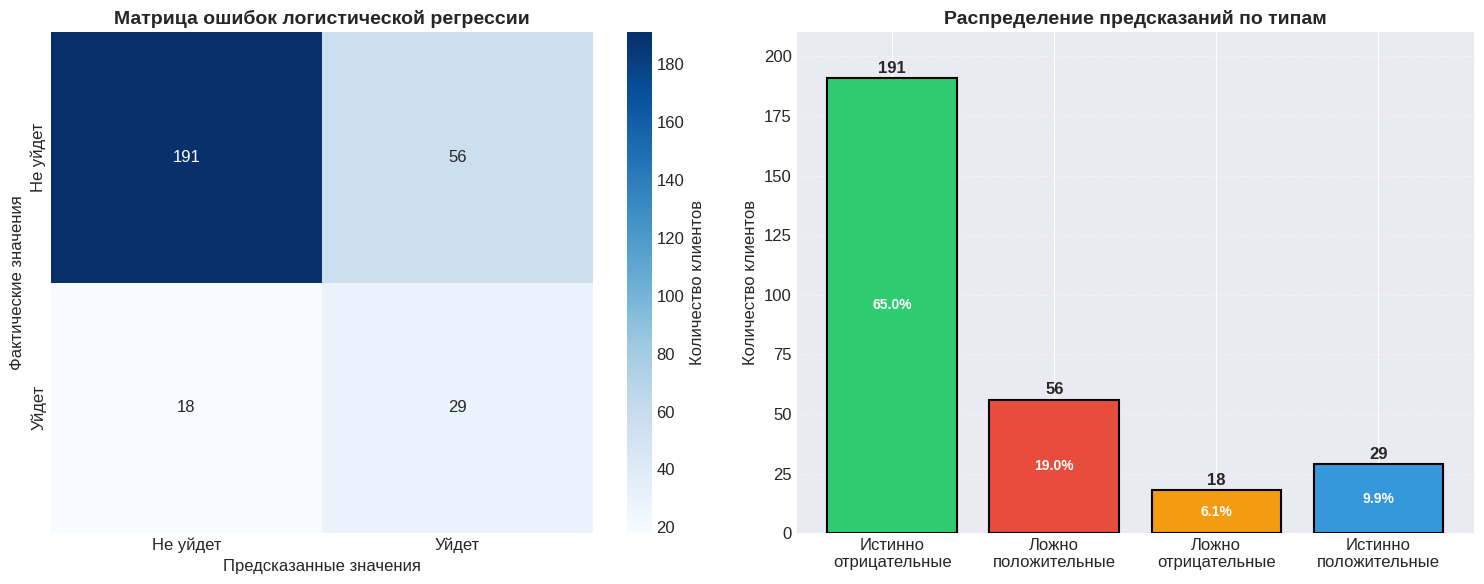


1. ОБЩАЯ СТАТИСТИКА:
   Всего предсказаний: 294
   Правильных предсказаний: 220 (74.8%)
   Ошибок предсказаний: 74 (25.2%)

2. АНАЛИЗ ПО КЛАССАМ:

   КЛАСС 'НЕ УЙДЕТ':
   • Фактически не ушли: 247 клиентов
   • Правильно предсказано: 191 клиентов
   • Точность для класса: 77.3%

   КЛАСС 'УЙДЕТ':
   • Фактически уйдут: 47 клиентов
   • Правильно предсказано: 29 клиентов
   • Точность для класса: 61.7%

3. СТАТИСТИКА ОШИБОК:
   Всего ошибок: 74
   Из них:
   • Ложные срабатывания (False Positive): 56
     - Клиентов, которые не уйдут, но мы предскажем уход: 56
     - Это 19.0% от всех предсказаний
   • Пропущенные случаи (False Negative): 18
     - Клиентов, которые уйдут, но мы не предскажем: 18
     - Это 6.1% от всех предсказаний

--- 6. Сравнение фактического и предсказанного распределения ---


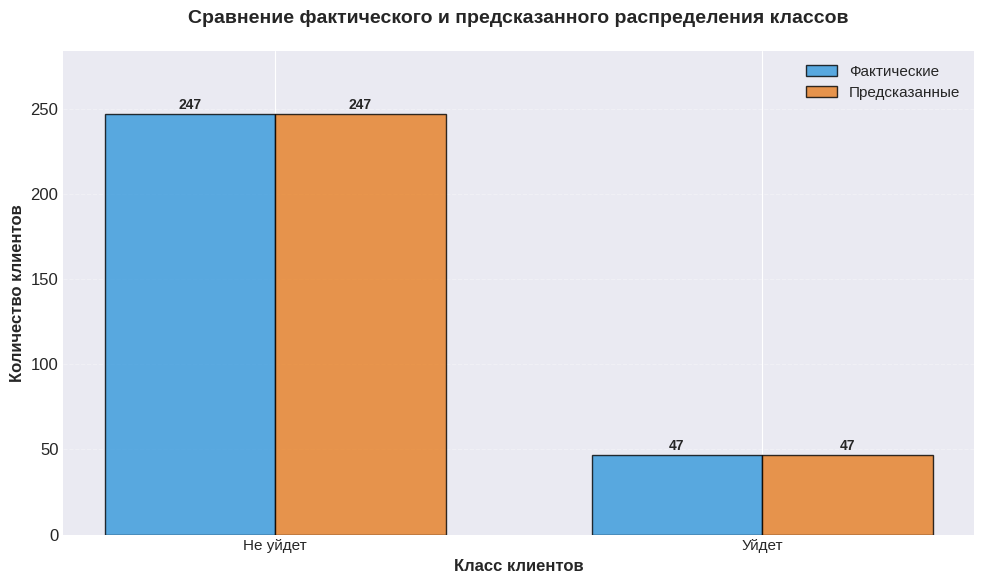


--- 7. Полный отчет о классификации ---
              precision    recall  f1-score   support

    Не уйдет       0.91      0.77      0.84       247
       Уйдет       0.34      0.62      0.44        47

    accuracy                           0.75       294
   macro avg       0.63      0.70      0.64       294
weighted avg       0.82      0.75      0.77       294



In [25]:
# Ячейка 5: ПОСТРОЕНИЕ БЕЗЛАЙНА ДЛЯ КЛАССИФИКАЦИИ (Логистическая регрессия)
# 5.1 Обучение базовой модели логистической регрессии
print("\n--- 1. Обучение базовой модели логистической регрессии ---")

# Создаем модель логистической регрессии с балансировкой классов
logreg_classifier = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs'
)

# Обучаем модель на обучающей выборке
print("Обучаем модель логистической регрессии...")
logreg_classifier.fit(X_train_class, y_train_class)
print("Модель обучена успешно!")

# 5.2 Предсказания на тестовой выборке
print("\n--- 2. Предсказания на тестовой выборке ---")

# Получаем предсказания
y_pred_class = logreg_classifier.predict(X_test_class)

print(f"Получено {len(y_pred_class)} предсказаний")
print(f"Распределение предсказанных классов: Класс 0: {(y_pred_class == 0).sum()}, Класс 1: {(y_pred_class == 1).sum()}")

# 5.3 Оценка качества модели
print("\n--- 3. Оценка качества модели (метрики) ---")

# Основные метрики
f1 = f1_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class)
recall = recall_score(y_test_class, y_pred_class)

print("Основные метрики качества:")
print(f"  • F1-score:       {f1:.4f}")
print(f"  • Precision:      {precision:.4f}")
print(f"  • Recall:         {recall:.4f}")

# 5.4 Матрица ошибок (Confusion Matrix)
print("\n--- 4. Матрица ошибок ---")

# Вычисляем матрицу ошибок
cm = confusion_matrix(y_test_class, y_pred_class)
tn, fp, fn, tp = cm.ravel()

print("Матрица ошибок:")
print(f"                  Предсказано")
print(f"                Нет     Да")
print(f"Фактически Нет  [{tn:3d}]  [{fp:3d}]")
print(f"            Да   [{fn:3d}]  [{tp:3d}]")
print()

# Дополнительные метрики из матрицы ошибок
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Дополнительные метрики:")
print(f"  • Accuracy:       {accuracy:.4f}")
print(f"  • False Positive: {fp} ({fp/(fp+tn)*100:.1f}% от класса 'Нет')")
print(f"  • False Negative: {fn} ({fn/(fn+tp)*100:.1f}% от класса 'Да')")

# 5.5 Визуализация матрицы ошибок как графика
print("\n--- 5. Визуализация матрицы ошибок ---")

# Создаем фигуру с несколькими графиками
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Тепловая карта матрицы ошибок
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'],
            cbar_kws={'label': 'Количество клиентов'})
ax1.set_title('Матрица ошибок логистической регрессии', fontsize=14, fontweight='bold')
ax1.set_ylabel('Фактические значения', fontsize=12)
ax1.set_xlabel('Предсказанные значения', fontsize=12)

# 2. Столбчатая диаграмма распределения ошибок
ax2 = axes[1]
categories = ['Истинно\nотрицательные', 'Ложно\nположительные', 
              'Ложно\nотрицательные', 'Истинно\nположительные']
values = [tn, fp, fn, tp]
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db']

bars = ax2.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)

# Добавляем значения на столбцы
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{value}', ha='center', va='bottom', fontweight='bold')

ax2.set_title('Распределение предсказаний по типам', fontsize=14, fontweight='bold')
ax2.set_ylabel('Количество клиентов', fontsize=12)
ax2.set_ylim(0, max(values) * 1.1)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем аннотации с процентами
total_predictions = len(y_pred_class)
percentages = [v/total_predictions*100 for v in values]
for i, (bar, perc) in enumerate(zip(bars, percentages)):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
            f'{perc:.1f}%', ha='center', va='center', 
            color='white', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# 5.6 Анализ правильности предсказаний

# Общая статистика по предсказаниям
total_predictions = len(y_pred_class)
correct_predictions = tp + tn
incorrect_predictions = fp + fn

print(f"\n1. ОБЩАЯ СТАТИСТИКА:")
print(f"   Всего предсказаний: {total_predictions}")
print(f"   Правильных предсказаний: {correct_predictions} ({accuracy*100:.1f}%)")
print(f"   Ошибок предсказаний: {incorrect_predictions} ({(1-accuracy)*100:.1f}%)")

# Анализ по классам
print(f"\n2. АНАЛИЗ ПО КЛАССАМ:")

# Для класса "Не уйдет" (0)
correct_not_churn = tn
total_not_churn_actual = tn + fp
accuracy_not_churn = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n   КЛАСС 'НЕ УЙДЕТ':")
print(f"   • Фактически не ушли: {total_not_churn_actual} клиентов")
print(f"   • Правильно предсказано: {correct_not_churn} клиентов")
print(f"   • Точность для класса: {accuracy_not_churn*100:.1f}%")

# Для класса "Уйдет" (1)
correct_churn = tp
total_churn_actual = tp + fn
accuracy_churn = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\n   КЛАСС 'УЙДЕТ':")
print(f"   • Фактически уйдут: {total_churn_actual} клиентов")
print(f"   • Правильно предсказано: {correct_churn} клиентов")
print(f"   • Точность для класса: {accuracy_churn*100:.1f}%")

# Статистика ошибок
print(f"\n3. СТАТИСТИКА ОШИБОК:")
print(f"   Всего ошибок: {incorrect_predictions}")
print(f"   Из них:")
print(f"   • Ложные срабатывания (False Positive): {fp}")
print(f"     - Клиентов, которые не уйдут, но мы предскажем уход: {fp}")
print(f"     - Это {fp/total_predictions*100:.1f}% от всех предсказаний")
print(f"   • Пропущенные случаи (False Negative): {fn}")
print(f"     - Клиентов, которые уйдут, но мы не предскажем: {fn}")
print(f"     - Это {fn/total_predictions*100:.1f}% от всех предсказаний")

# 5.7 Сравнение фактического и предсказанного распределения
print("\n--- 6. Сравнение фактического и предсказанного распределения ---")

plt.figure(figsize=(10, 6))

indices = np.arange(2)
width = 0.35

# Фактические значения
actual_counts = [total_not_churn_actual, total_churn_actual]
# Предсказанные значения
predicted_counts = [(tn + fp), (tp + fn)]

bars1 = plt.bar(indices - width/2, actual_counts, width, 
                label='Фактические', color='#3498db', edgecolor='black', alpha=0.8)
bars2 = plt.bar(indices + width/2, predicted_counts, width, 
                label='Предсказанные', color='#e67e22', edgecolor='black', alpha=0.8)

plt.xlabel('Класс клиентов', fontsize=12, fontweight='bold')
plt.ylabel('Количество клиентов', fontsize=12, fontweight='bold')
plt.title('Сравнение фактического и предсказанного распределения классов', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(indices, ['Не уйдет', 'Уйдет'], fontsize=11)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения на столбцы с улучшенным форматированием
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{int(height)}', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)

# Добавляем процентное расхождение
for i in range(2):
    actual = actual_counts[i]
    predicted = predicted_counts[i]
    diff = abs(actual - predicted)
    diff_percent = diff / actual * 100 if actual > 0 else 0
    
    # Размещаем текст над парой столбцов
    x_pos = indices[i]
    max_height = max(actual, predicted) + 5
    
    if diff > 0:
        plt.text(x_pos, max_height + 3, 
                f'Δ = {diff} ({diff_percent:.1f}%)', 
                ha='center', va='bottom', 
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.ylim(0, max(max(actual_counts), max(predicted_counts)) * 1.15)
plt.tight_layout()
plt.show()

# 5.8 Полный отчет о классификации
print("\n--- 7. Полный отчет о классификации ---")
print(classification_report(y_test_class, y_pred_class, 
                           target_names=['Не уйдет', 'Уйдет']))

### Построение безлайна для регрессии


--- 6.1 Обучение базовой модели линейной регрессии ---
Обучаем модель линейной регрессии...
Модель обучена успешно!
Количество признаков: 22
Свободный член (intercept): 13.0471

--- 6.2 Предсказания на тестовой выборке ---
Получено 4323 предсказаний цен
Примеры предсказанных цен (первые 5): $[ 427794  763164 1291911 2254290  675652]
Примеры фактических цен (первые 5):   $[ 364999  864999 1037999 1490000  711000]

--- 6.3 Оценка качества модели (метрики) ---
Метрики в логарифмированной шкале (более устойчивые):
  • RMSE (log scale): 0.2534
  • MAE (log scale):  0.1930

Метрики в оригинальной шкале (доллары):
  • RMSE:            $275,908 (основная метрика)
  • MAE:             $115,689 (вспомогательная)
  • MAPE:            19.78% (вспомогательная)
  • R²:              0.4964 (вспомогательная)

--- 6.4 Анализ коэффициентов линейной регрессии ---
Топ-10 наиболее важных признаков для предсказания цены:
       Признак  Коэффициент  Абсолютное_значение Влияние_на_цену
         grade     0.

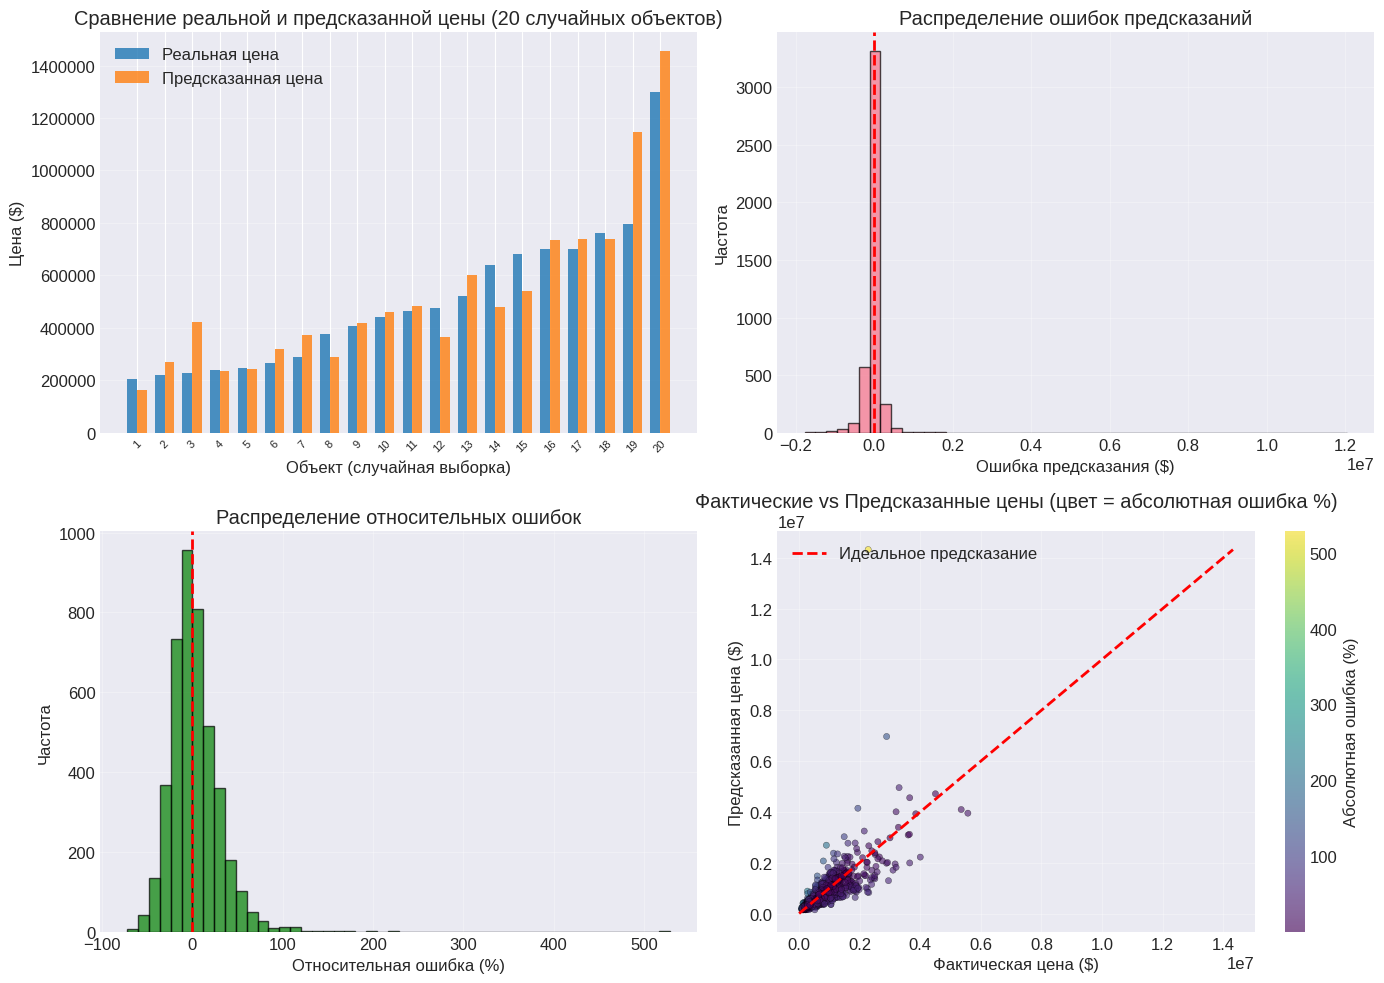


--- 6.6 Статистика ошибок предсказаний ---
Процентили абсолютных ошибок (в долларах):
  • 25%: $29,825
  • 50% (медиана): $66,778
  • 75%: $130,369
  • 90%: $231,207
  • 95%: $378,892

Процент предсказаний с заданной точностью:
  • Ошибка ≤ 10%: 34.3% предсказаний
  • Ошибка ≤ 20%: 61.2% предсказаний
  • Ошибка ≤ 30%: 80.0% предсказаний

--- 6.7 Сравнение реальных и предсказанных цен ---
Средняя цена: реальная = $549,367, предсказанная = $535,759
Медианная цена: реальная = $455,000, предсказанная = $446,820
Средняя ошибка: $-13,608
Средняя абсолютная ошибка: $115,689 (19.8%)

--- 6.8 Анализ остатков модели ---
Средний остаток: $13,608
Стандартное отклонение остатков: $275,573
Минимальный остаток: $-12,041,326
Максимальный остаток: $1,778,643
Процент положительных остатков: 50.9%


In [26]:
# Ячейка 6: ПОСТРОЕНИЕ БЕЗЛАЙНА ДЛЯ РЕГРЕССИИ
# 6.1 Обучение базовой модели линейной регрессии
print("\n--- 6.1 Обучение базовой модели линейной регрессии ---")

# Создаем модель линейной регрессии
linear_regressor = LinearRegression()

# Обучаем модель на обучающей выборке
print("Обучаем модель линейной регрессии...")
linear_regressor.fit(X_train_reg, y_train_reg)
print("Модель обучена успешно!")

# Выводим информацию о модели
print(f"Количество признаков: {linear_regressor.coef_.shape[0]}")
print(f"Свободный член (intercept): {linear_regressor.intercept_:.4f}")

# 6.2 Предсказания на тестовой выборке
print("\n--- 6.2 Предсказания на тестовой выборке ---")

# Получаем предсказания (логарифмированные цены)
y_pred_reg_log = linear_regressor.predict(X_test_reg)

# Преобразуем обратно из логарифма в обычные цены
y_pred_reg = np.expm1(y_pred_reg_log)

# Преобразуем y_test_reg из логарифмированной шкалы в обычные цены
# y_test_reg - это логарифмированные цены, преобразуем их
y_test_reg_original = np.expm1(y_test_reg)

print(f"Получено {len(y_pred_reg)} предсказаний цен")

print(f"Примеры предсказанных цен (первые 5): ${y_pred_reg[:5].astype(int)}")
print(f"Примеры фактических цен (первые 5):   ${y_test_reg_original.iloc[:5].astype(int).values}")

# 6.3 Оценка качества модели (метрики)
print("\n--- 6.3 Оценка качества модели (метрики) ---")

# Основные метрики в логарифмированной шкале (более устойчивые)
rmse_log = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_log))
mae_log = mean_absolute_error(y_test_reg, y_pred_reg_log)

# Метрики в оригинальной шкале (доллары)
rmse = np.sqrt(mean_squared_error(y_test_reg_original, y_pred_reg))
mae = mean_absolute_error(y_test_reg_original, y_pred_reg)

mape = mean_absolute_percentage_error(y_test_reg_original, y_pred_reg)
r2 = r2_score(y_test_reg_original, y_pred_reg)

print("Метрики в логарифмированной шкале (более устойчивые):")
print(f"  • RMSE (log scale): {rmse_log:.4f}")
print(f"  • MAE (log scale):  {mae_log:.4f}")

print("\nМетрики в оригинальной шкале (доллары):")
print(f"  • RMSE:            ${rmse:,.0f} (основная метрика)")
print(f"  • MAE:             ${mae:,.0f} (вспомогательная)")
print(f"  • MAPE:            {mape*100:.2f}% (вспомогательная)")
print(f"  • R²:              {r2:.4f} (вспомогательная)")

# 6.4 Анализ коэффициентов модели
print("\n--- 6.4 Анализ коэффициентов линейной регрессии ---")

# Получаем коэффициенты модели
coefficients = linear_regressor.coef_

# Проверяем наличие feature_names_reg
if 'feature_names_reg' in locals() and feature_names_reg is not None:
    feature_names = feature_names_reg
else:
    feature_names = [f'Feature_{i}' for i in range(len(coefficients))]

# Создаем DataFrame с коэффициентами
coeff_df = pd.DataFrame({
    'Признак': feature_names,
    'Коэффициент': coefficients,
    'Абсолютное_значение': np.abs(coefficients),
    'Влияние_на_цену': ['Увеличивает' if c > 0 else 'Уменьшает' for c in coefficients]
})

# Сортируем по абсолютному значению
coeff_df = coeff_df.sort_values('Абсолютное_значение', ascending=False)

print("Топ-10 наиболее важных признаков для предсказания цены:")
print(coeff_df.head(10).to_string(index=False))

# 6.5 Визуализация: реальные vs предсказанные цены
print("\n--- 6.5 Визуализация результатов регрессии ---")

# Создаем DataFrame для удобства анализа
# Преобразуем y_test_reg_original в массив, если это Series
if hasattr(y_test_reg_original, 'values'):
    y_test_array = y_test_reg_original.values
else:
    y_test_array = y_test_reg_original

results_df = pd.DataFrame({
    'Фактическая_цена': y_test_array,
    'Предсказанная_цена': y_pred_reg,
    'Относительная_ошибка_%': ((y_pred_reg - y_test_array) / y_test_array) * 100
})

# Рассчитываем ошибки для графиков
errors = y_pred_reg - y_test_array
relative_errors = (errors / y_test_array) * 100

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# График 1: Сравнение реальной и предсказанной цены для случайных 20 объектов
np.random.seed(42)  # Для воспроизводимости
n_samples = min(20, len(results_df))
sample_indices = np.random.choice(len(results_df), n_samples, replace=False)
sample_df = results_df.iloc[sample_indices].copy()
sample_df = sample_df.sort_values('Фактическая_цена')

x_pos = np.arange(len(sample_df))
width = 0.35

bars_actual = axes[0, 0].bar(x_pos - width/2, sample_df['Фактическая_цена'], 
                            width, label='Реальная цена', color='#1f77b4', alpha=0.8)
bars_pred = axes[0, 0].bar(x_pos + width/2, sample_df['Предсказанная_цена'], 
                          width, label='Предсказанная цена', color='#ff7f0e', alpha=0.8)

axes[0, 0].set_xlabel('Объект (случайная выборка)')
axes[0, 0].set_ylabel('Цена ($)')
axes[0, 0].set_title('Сравнение реальной и предсказанной цены (20 случайных объектов)')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels([f'{i+1}' for i in range(len(sample_df))], rotation=45, fontsize=8)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].ticklabel_format(style='plain', axis='y')

# График 2: Ошибки предсказаний
axes[0, 1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Ошибка предсказания ($)')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].set_title('Распределение ошибок предсказаний')
axes[0, 1].grid(True, alpha=0.3)

# График 3: Относительные ошибки
axes[1, 0].hist(relative_errors, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Относительная ошибка (%)')
axes[1, 0].set_ylabel('Частота')
axes[1, 0].set_title('Распределение относительных ошибок')
axes[1, 0].grid(True, alpha=0.3)

# График 4: Фактические vs предсказанные цены (scatter с тепловой картой)
scatter = axes[1, 1].scatter(results_df['Фактическая_цена'], results_df['Предсказанная_цена'],
                            c=np.abs(results_df['Относительная_ошибка_%']),
                            cmap='viridis', alpha=0.6, s=20, edgecolors='black', linewidth=0.3)

# Линия идеального предсказания
max_price = max(results_df['Фактическая_цена'].max(), results_df['Предсказанная_цена'].max())
axes[1, 1].plot([0, max_price], [0, max_price], 'r--', linewidth=2, label='Идеальное предсказание')

axes[1, 1].set_xlabel('Фактическая цена ($)')
axes[1, 1].set_ylabel('Предсказанная цена ($)')
axes[1, 1].set_title('Фактические vs Предсказанные цены (цвет = абсолютная ошибка %)')
axes[1, 1].legend(loc='upper left')
axes[1, 1].grid(True, alpha=0.3)

# Добавляем цветовую шкалу
cbar = plt.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('Абсолютная ошибка (%)')

plt.tight_layout()
plt.show()

# 6.6 Статистика ошибок
print("\n--- 6.6 Статистика ошибок предсказаний ---")

# Процентили абсолютных ошибок (в долларах)
abs_errors = np.abs(errors)
error_percentiles = np.percentile(abs_errors, [25, 50, 75, 90, 95])
print("Процентили абсолютных ошибок (в долларах):")
print(f"  • 25%: ${error_percentiles[0]:,.0f}")
print(f"  • 50% (медиана): ${error_percentiles[1]:,.0f}")
print(f"  • 75%: ${error_percentiles[2]:,.0f}")
print(f"  • 90%: ${error_percentiles[3]:,.0f}")
print(f"  • 95%: ${error_percentiles[4]:,.0f}")

# Процент предсказаний с разной точностью
abs_relative_errors = np.abs(relative_errors)
within_10_percent = np.sum(abs_relative_errors <= 10) / len(abs_relative_errors) * 100
within_20_percent = np.sum(abs_relative_errors <= 20) / len(abs_relative_errors) * 100
within_30_percent = np.sum(abs_relative_errors <= 30) / len(abs_relative_errors) * 100

print("\nПроцент предсказаний с заданной точностью:")
print(f"  • Ошибка ≤ 10%: {within_10_percent:.1f}% предсказаний")
print(f"  • Ошибка ≤ 20%: {within_20_percent:.1f}% предсказаний")
print(f"  • Ошибка ≤ 30%: {within_30_percent:.1f}% предсказаний")

# 6.7 Сравнение реальных и предсказанных цен
print("\n--- 6.7 Сравнение реальных и предсказанных цен ---")

mean_actual = np.mean(y_test_array)
mean_pred = np.mean(y_pred_reg)
median_actual = np.median(y_test_array)
median_pred = np.median(y_pred_reg)

print(f"Средняя цена: реальная = ${mean_actual:,.0f}, предсказанная = ${mean_pred:,.0f}")
print(f"Медианная цена: реальная = ${median_actual:,.0f}, предсказанная = ${median_pred:,.0f}")
print(f"Средняя ошибка: ${np.mean(errors):,.0f}")
print(f"Средняя абсолютная ошибка: ${mae:,.0f} ({mape*100:.1f}%)")

# 6.8 Анализ остатков
print("\n--- 6.8 Анализ остатков модели ---")

residuals = y_test_array - y_pred_reg
print(f"Средний остаток: ${np.mean(residuals):,.0f}")
print(f"Стандартное отклонение остатков: ${np.std(residuals):,.0f}")
print(f"Минимальный остаток: ${np.min(residuals):,.0f}")
print(f"Максимальный остаток: ${np.max(residuals):,.0f}")
print(f"Процент положительных остатков: {np.sum(residuals > 0) / len(residuals) * 100:.1f}%")

## 3. Улучшение Безлайна

### Гипотезы для улучшения

**Для логистической регрессии:**

**Основные проблемы**: Низкий Precision (0.341) - много ложных срабатываний (56 FP), но приемлемый Recall (0.617).

Гипотезы для улучшения:

1. Настройка class_weight - ручная балансировка вместо 'balanced'

2. Регуляризация (параметр C) - подбор силы регуляризации

3. Изменение порога - оптимизация баланса Precision/Recall

4. Удаление шумных признаков - исключение слабо влияющих переменных

**Для линейной регрессии:**

**Основные проблемы**: Низкий R² (0.496) - модель объясняет лишь 50% вариаций цены, высокий RMSE ($275K).

Гипотезы для улучшения:

1. Полиномиальные признаки - добавление квадратов важных переменных

2. Регуляризация (Ridge) - борьба с переобучением

3. Взаимодействия признаков - умножение ключевых факторов

4. Удаление выбросов - более агрессивная обработка аномалий


--- 7.1 Проверка гипотез и подбор гиперпараметров для логистической регрессии ---
Запускаем GridSearchCV для логистической регрессии...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Результаты поиска лучших параметров:
Лучшие параметры: {'C': 0.1, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'liblinear'}
Лучший F1-score на кросс-валидации: 0.5890

--- 7.2 Отбор наиболее значимых признаков ---
Топ-15 наиболее важных признаков:
                          Признак  Коэффициент  Абсолютная_важность
                     OverTime_Yes     0.644010             0.644010
    JobRole_Laboratory Technician     0.388816             0.388816
 BusinessTravel_Travel_Frequently     0.359492             0.359492
          EnvironmentSatisfaction    -0.328967             0.328967
Department_Research & Development    -0.321269             0.321269
               NumCompaniesWorked     0.317334             0.317334
          YearsSinceLastPromotion     0.304187             0.304

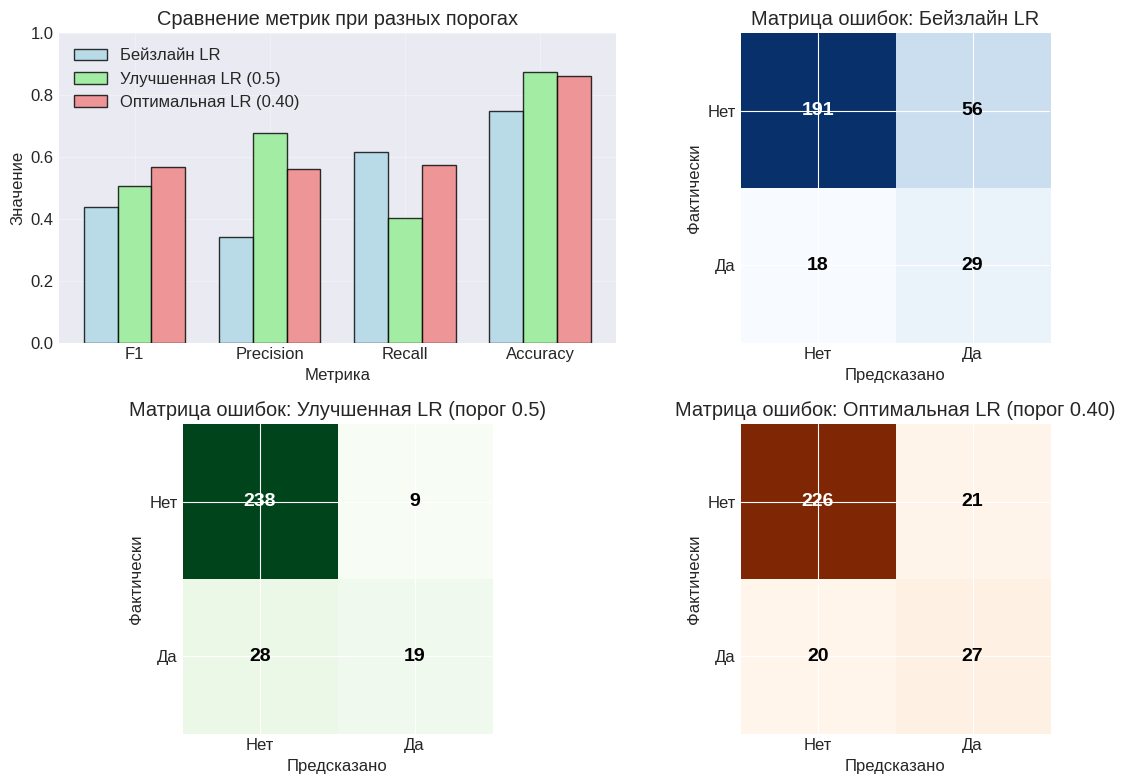


--- 7.8 Визуализация влияния порога на метрики ---


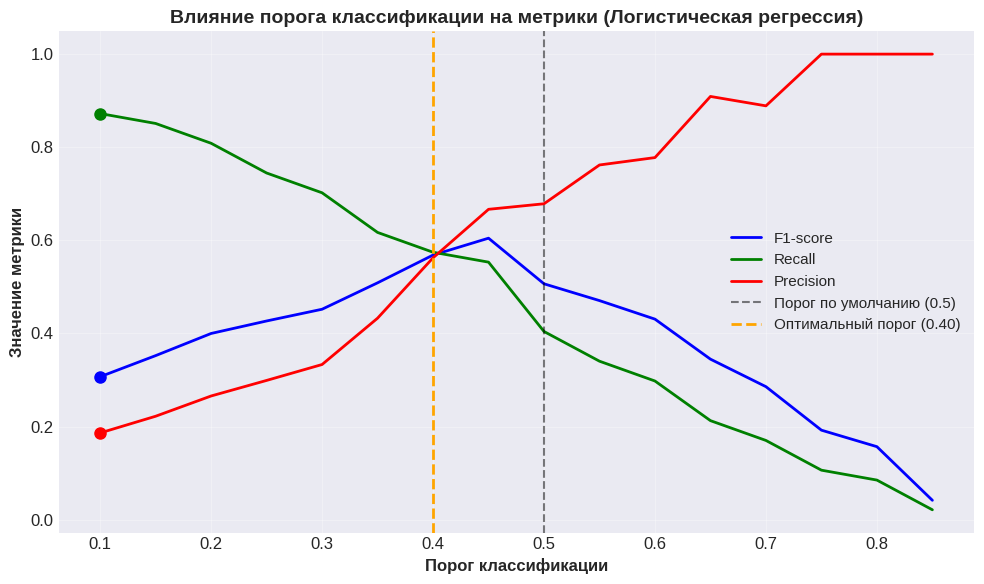


--- 7.9 Полный отчет о классификации ---
Отчет для улучшенной модели логистической регрессии с оптимальным порогом:
              precision    recall  f1-score   support

    Не уйдет       0.92      0.91      0.92       247
       Уйдет       0.56      0.57      0.57        47

    accuracy                           0.86       294
   macro avg       0.74      0.74      0.74       294
weighted avg       0.86      0.86      0.86       294



In [27]:
# Ячейка 7: УЛУЧШЕНИЕ БЕЙЗЛАЙНА ДЛЯ КЛАССИФИКАЦИИ (Логистическая регрессия)
# 7.1 Проверка гипотез и подбор гиперпараметров
print("\n--- 7.1 Проверка гипотез и подбор гиперпараметров для логистической регрессии ---")

# Параметры для GridSearch согласно гипотезам
param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10, 100],  # регуляризация (гипотеза 2)
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}],  # гипотеза 1
    'penalty': ['l1', 'l2'],  # тип регуляризации
    'solver': ['liblinear']  # liblinear поддерживает L1 и L2
}

# Используем F1-score для оценки
grid_search_logreg = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    param_grid=param_grid_logreg,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Запускаем GridSearchCV для логистической регрессии...")
grid_search_logreg.fit(X_train_class, y_train_class)

print("\nРезультаты поиска лучших параметров:")
print(f"Лучшие параметры: {grid_search_logreg.best_params_}")
print(f"Лучший F1-score на кросс-валидации: {grid_search_logreg.best_score_:.4f}")

# 7.2 Отбор признаков (гипотеза 4)
print("\n--- 7.2 Отбор наиболее значимых признаков ---")

# Анализ важности признаков из лучшей модели
best_logreg = grid_search_logreg.best_estimator_
coefficients = best_logreg.coef_[0]

# Проверяем наличие feature_names_class
if 'feature_names_class' in locals() and feature_names_class is not None:
    feature_names = feature_names_class
else:
    # Если имена признаков не сохранены, создаем искусственные
    feature_names = [f'Feature_{i}' for i in range(len(coefficients))]

feature_importance = pd.DataFrame({
    'Признак': feature_names,
    'Коэффициент': coefficients,
    'Абсолютная_важность': np.abs(coefficients)
}).sort_values('Абсолютная_важность', ascending=False)

print("Топ-15 наиболее важных признаков:")
print(feature_importance.head(15).to_string(index=False))

# Отбираем признаки с коэффициентами выше порога
importance_threshold = np.percentile(np.abs(coefficients), 75)  # верхние 25%
selected_features = feature_importance[feature_importance['Абсолютная_важность'] >= importance_threshold]['Признак'].tolist()

print(f"\nОтобрано {len(selected_features)} признаков из {len(feature_names)}")
print(f"Порог важности: {importance_threshold:.4f}")

# Создаем данные только с отобранными признаками
if 'feature_names_class' in locals() and feature_names_class is not None:
    # Находим индексы отобранных признаков
    selected_indices = []
    for feat in selected_features:
        if feat in feature_names_class:
            selected_indices.append(feature_names_class.index(feat))
    
    if selected_indices:
        X_train_selected = X_train_class[:, selected_indices]
        X_test_selected = X_test_class[:, selected_indices]
        print(f"Используем {len(selected_indices)} отобранных признаков")
    else:
        print("Не удалось найти отобранные признаки в feature_names_class, используем все признаки")
        X_train_selected = X_train_class
        X_test_selected = X_test_class
else:
    print("Имена признаков не найдены, используем все признаки")
    X_train_selected = X_train_class
    X_test_selected = X_test_class

# 7.3 Формирование улучшенной модели
print("\n--- 7.3 Формирование улучшенной модели классификации ---")

# Создаем улучшенную модель с лучшими параметрами на отобранных признаках
best_logreg_improved = grid_search_logreg.best_estimator_
best_logreg_improved.fit(X_train_selected, y_train_class)

print(f"Улучшенная модель логистической регрессии создана:")
print(f"  • C (регуляризация): {best_logreg_improved.get_params()['C']}")
print(f"  • class_weight: {best_logreg_improved.get_params()['class_weight']}")
print(f"  • penalty: '{best_logreg_improved.get_params()['penalty']}'")
print(f"  • Количество признаков: {X_train_selected.shape[1]}")

# 7.4 Оценка качества
print("\n--- 7.4 Оценка качества улучшенной модели (порог 0.5) ---")

# Предсказания с порогом 0.5 (по умолчанию)
y_pred_logreg_improved = best_logreg_improved.predict(X_test_selected)
y_pred_proba_logreg_improved = best_logreg_improved.predict_proba(X_test_selected)[:, 1]

# Метрики с порогом 0.5
f1_improved_05 = f1_score(y_test_class, y_pred_logreg_improved)
precision_improved_05 = precision_score(y_test_class, y_pred_logreg_improved)
recall_improved_05 = recall_score(y_test_class, y_pred_logreg_improved)
accuracy_improved_05 = (y_pred_logreg_improved == y_test_class).mean()

print("Основные метрики улучшенной модели (порог 0.5):")
print(f"  • F1-score:       {f1_improved_05:.4f}")
print(f"  • Precision:      {precision_improved_05:.4f}")
print(f"  • Recall:         {recall_improved_05:.4f}")
print(f"  • Accuracy:       {accuracy_improved_05:.4f}")

# Матрица ошибок с порогом 0.5
cm_improved_05 = confusion_matrix(y_test_class, y_pred_logreg_improved)
tn_05, fp_05, fn_05, tp_05 = cm_improved_05.ravel()

print("\nМатрица ошибок улучшенной модели (порог 0.5):")
print(f"                  Предсказано")
print(f"                Нет     Да")
print(f"Фактически Нет  [{tn_05:3d}]  [{fp_05:3d}]")
print(f"            Да   [{fn_05:3d}]  [{tp_05:3d}]")

# 7.5 Настройка порога (гипотеза 3)
print("\n--- 7.5 Настройка порога классификации ---")

# Анализ разных порогов классификации
thresholds = np.arange(0.1, 0.9, 0.1)
print(f"{'Порог':<8} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'Класс 1':<10}")
print("-" * 55)

best_f1 = 0
best_threshold = 0.5
best_predictions = None

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba_logreg_improved >= threshold).astype(int)
    
    if np.sum(y_pred_threshold) > 0:
        precision_t = precision_score(y_test_class, y_pred_threshold)
        recall_t = recall_score(y_test_class, y_pred_threshold)
        f1_t = f1_score(y_test_class, y_pred_threshold)
        n_class1 = np.sum(y_pred_threshold)
        
        print(f"{threshold:<8.1f} {precision_t:<10.4f} {recall_t:<10.4f} {f1_t:<10.4f} {n_class1:<10}")
        
        if f1_t > best_f1:
            best_f1 = f1_t
            best_threshold = threshold
            best_predictions = y_pred_threshold
    else:
        print(f"{threshold:<8.1f} {'-':<10} {'-':<10} {'-':<10} {0:<10}")

print(f"\nОптимальный порог: {best_threshold:.2f} (F1={best_f1:.4f})")

# Предсказания с оптимальным порогом
y_pred_optimal = best_predictions if best_predictions is not None else y_pred_logreg_improved
f1_optimal = f1_score(y_test_class, y_pred_optimal)
precision_optimal = precision_score(y_test_class, y_pred_optimal)
recall_optimal = recall_score(y_test_class, y_pred_optimal)
accuracy_optimal = (y_pred_optimal == y_test_class).mean()
cm_optimal = confusion_matrix(y_test_class, y_pred_optimal)
tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal.ravel()

print(f"\nМетрики с оптимальным порогом {best_threshold:.2f}:")
print(f"  • F1-score:       {f1_optimal:.4f}")
print(f"  • Precision:      {precision_optimal:.4f}")
print(f"  • Recall:         {recall_optimal:.4f}")
print(f"  • Accuracy:       {accuracy_optimal:.4f}")

# 7.6 Сравнение с бейзлайном логистической регрессии
print("\n--- 7.6 Сравнение результатов с бейзлайном логистической регрессии ---")

# Метрики бейзлайна логистической регрессии (из ячейки 5)
# Проверяем, что переменные существуют
if 'f1' in locals() and 'precision' in locals() and 'recall' in locals() and 'accuracy' in locals():
    f1_base_logreg = f1
    precision_base_logreg = precision
    recall_base_logreg = recall
    accuracy_base_logreg = accuracy
    
    if 'y_pred_class' in locals():
        cm_base_logreg = confusion_matrix(y_test_class, y_pred_class)
    else:
        print("Предупреждение: y_pred_class не найден")
        cm_base_logreg = np.zeros((2, 2))
else:
    print("Предупреждение: метрики бейзлайна не найдены")
    f1_base_logreg = 0
    precision_base_logreg = 0
    recall_base_logreg = 0
    accuracy_base_logreg = 0
    cm_base_logreg = np.zeros((2, 2))

print("\n1. СРАВНЕНИЕ С ПОРОГОМ 0.5:")
print("-" * 70)
print(f"{'Метрика':<15} {'Бейзлайн LR':<12} {'Улучшенная LR':<12} {'Изменение':<12} {'% изменения':<12}")
print("-" * 70)

for metric_name, base_val, improved_val in [
    ("F1-score", f1_base_logreg, f1_improved_05),
    ("Precision", precision_base_logreg, precision_improved_05),
    ("Recall", recall_base_logreg, recall_improved_05),
    ("Accuracy", accuracy_base_logreg, accuracy_improved_05)
]:
    change = improved_val - base_val
    change_pct = (change / base_val * 100) if base_val != 0 else 0
    change_sign = "+" if change > 0 else ""
    
    print(f"{metric_name:<15} {base_val:<12.4f} {improved_val:<12.4f} "
          f"{change_sign}{change:<12.4f} {change_sign}{change_pct:<11.1f}%")

print(f"\nМатрицы ошибок (порог 0.5):")
print(f"Бейзлайн LR: TN={cm_base_logreg[0,0]}, FP={cm_base_logreg[0,1]}, FN={cm_base_logreg[1,0]}, TP={cm_base_logreg[1,1]}")
print(f"Улучшенная:  TN={tn_05}, FP={fp_05}, FN={fn_05}, TP={tp_05}")
if cm_base_logreg.size == 4:
    print(f"Улучшения: TP +{tp_05 - cm_base_logreg[1,1]}, FN -{cm_base_logreg[1,0] - fn_05}")

print(f"\n\n2. СРАВНЕНИЕ С ОПТИМАЛЬНЫМ ПОРОГОМ {best_threshold:.2f}:")
print("-" * 70)
print(f"{'Метрика':<15} {'Бейзлайн LR':<12} {'Оптимальная LR':<12} {'Изменение':<12} {'% изменения':<12}")
print("-" * 70)

for metric_name, base_val, optimal_val in [
    ("F1-score", f1_base_logreg, f1_optimal),
    ("Precision", precision_base_logreg, precision_optimal),
    ("Recall", recall_base_logreg, recall_optimal),
    ("Accuracy", accuracy_base_logreg, accuracy_optimal)
]:
    change = optimal_val - base_val
    change_pct = (change / base_val * 100) if base_val != 0 else 0
    change_sign = "+" if change > 0 else ""
    
    print(f"{metric_name:<15} {base_val:<12.4f} {optimal_val:<12.4f} "
          f"{change_sign}{change:<12.4f} {change_sign}{change_pct:<11.1f}%")

print(f"\nМатрицы ошибок (порог {best_threshold:.2f}):")
print(f"Бейзлайн LR: TN={cm_base_logreg[0,0]}, FP={cm_base_logreg[0,1]}, FN={cm_base_logreg[1,0]}, TP={cm_base_logreg[1,1]}")
print(f"Оптимальная: TN={tn_opt}, FP={fp_opt}, FN={fn_opt}, TP={tp_opt}")
if cm_base_logreg.size == 4:
    print(f"Улучшения: TP +{tp_opt - cm_base_logreg[1,1]}, FN -{cm_base_logreg[1,0] - fn_opt}")

print(f"\n\n3. ВЛИЯНИЕ НАСТРОЙКИ ПОРОГА:")
print("-" * 70)
print(f"Настройка порога с 0.5 до {best_threshold:.2f} дает:")
if f1_improved_05 > 0:
    print(f"  • F1-score: +{(f1_optimal - f1_improved_05):.4f} (+{(f1_optimal - f1_improved_05)/f1_improved_05*100:.1f}%)")
if recall_improved_05 > 0:
    print(f"  • Recall: +{(recall_optimal - recall_improved_05):.4f} (+{(recall_optimal - recall_improved_05)/recall_improved_05*100:.1f}%)")
if precision_improved_05 > 0:
    print(f"  • Precision: {(precision_optimal - precision_improved_05):.4f} ({(precision_optimal - precision_improved_05)/precision_improved_05*100:.1f}%)")

# 7.7 Визуализация сравнения моделей
print("\n--- 7.7 Визуализация сравнения моделей логистической регрессии ---")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Сравнение метрик (порог 0.5)
metrics = ['F1', 'Precision', 'Recall', 'Accuracy']
base_vals = [f1_base_logreg, precision_base_logreg, recall_base_logreg, accuracy_base_logreg]
improved_vals_05 = [f1_improved_05, precision_improved_05, recall_improved_05, accuracy_improved_05]
optimal_vals = [f1_optimal, precision_optimal, recall_optimal, accuracy_optimal]

x = np.arange(len(metrics))
width = 0.25

axes[0, 0].bar(x - width, base_vals, width, label='Бейзлайн LR', alpha=0.8, color='lightblue', edgecolor='black')
axes[0, 0].bar(x, improved_vals_05, width, label='Улучшенная LR (0.5)', alpha=0.8, color='lightgreen', edgecolor='black')
axes[0, 0].bar(x + width, optimal_vals, width, label=f'Оптимальная LR ({best_threshold:.2f})', alpha=0.8, color='lightcoral', edgecolor='black')
axes[0, 0].set_xlabel('Метрика')
axes[0, 0].set_ylabel('Значение')
axes[0, 0].set_title('Сравнение метрик при разных порогах')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(0, 1)

# 2. Матрица ошибок - Бейзлайн LR
im1 = axes[0, 1].imshow(cm_base_logreg, cmap='Blues')
axes[0, 1].set_title('Матрица ошибок: Бейзлайн LR')
for i in range(cm_base_logreg.shape[0]):
    for j in range(cm_base_logreg.shape[1]):
        axes[0, 1].text(j, i, cm_base_logreg[i, j], ha='center', va='center', 
                       color='white' if cm_base_logreg[i, j] > cm_base_logreg.max()/2 else 'black',
                       fontsize=14, fontweight='bold')
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_yticks([0, 1])
axes[0, 1].set_xticklabels(['Нет', 'Да'])
axes[0, 1].set_yticklabels(['Нет', 'Да'])
axes[0, 1].set_xlabel('Предсказано')
axes[0, 1].set_ylabel('Фактически')

# 3. Матрица ошибок - Улучшенная LR (порог 0.5)
im2 = axes[1, 0].imshow(cm_improved_05, cmap='Greens')
axes[1, 0].set_title('Матрица ошибок: Улучшенная LR (порог 0.5)')
for i in range(2):
    for j in range(2):
        axes[1, 0].text(j, i, cm_improved_05[i, j], ha='center', va='center', 
                       color='white' if cm_improved_05[i, j] > cm_improved_05.max()/2 else 'black',
                       fontsize=14, fontweight='bold')

axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_xticklabels(['Нет', 'Да'])
axes[1, 0].set_yticklabels(['Нет', 'Да'])
axes[1, 0].set_xlabel('Предсказано')
axes[1, 0].set_ylabel('Фактически')

# 4. Матрица ошибок - Оптимальная LR (порог best_threshold)
im3 = axes[1, 1].imshow(cm_optimal, cmap='Oranges')
axes[1, 1].set_title(f'Матрица ошибок: Оптимальная LR (порог {best_threshold:.2f})')
for i in range(2):
    for j in range(2):
        axes[1, 1].text(j, i, cm_optimal[i, j], ha='center', va='center', 
                       color='white' if cm_optimal[i, j] > cm_optimal.max()/2 else 'black',
                       fontsize=14, fontweight='bold')
 
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_yticks([0, 1])
axes[1, 1].set_xticklabels(['Нет', 'Да'])
axes[1, 1].set_yticklabels(['Нет', 'Да'])
axes[1, 1].set_xlabel('Предсказано')
axes[1, 1].set_ylabel('Фактически')

plt.tight_layout()
plt.show()

print("\n--- 7.8 Визуализация влияния порога на метрики ---")

fig, ax = plt.subplots(figsize=(10, 6))

thresholds_detailed = np.arange(0.1, 0.9, 0.05)
f1_scores = []
recall_scores = []
precision_scores = []

for threshold in thresholds_detailed:
    y_pred_threshold = (y_pred_proba_logreg_improved >= threshold).astype(int)
    if np.sum(y_pred_threshold) > 0:
        f1_scores.append(f1_score(y_test_class, y_pred_threshold))
        recall_scores.append(recall_score(y_test_class, y_pred_threshold))
        precision_scores.append(precision_score(y_test_class, y_pred_threshold))
    else:
        f1_scores.append(0)
        recall_scores.append(0)
        precision_scores.append(0)

ax.plot(thresholds_detailed, f1_scores, 'b-', label='F1-score', linewidth=2)
ax.plot(thresholds_detailed, recall_scores, 'g-', label='Recall', linewidth=2)
ax.plot(thresholds_detailed, precision_scores, 'r-', label='Precision', linewidth=2)
ax.axvline(x=0.5, color='k', linestyle='--', alpha=0.5, label='Порог по умолчанию (0.5)')
ax.axvline(x=best_threshold, color='orange', linestyle='--', linewidth=2,
           label=f'Оптимальный порог ({best_threshold:.2f})')

# Отметим точки для 0.1, 0.3, 0.5, 0.7
for thr in [0.1, 0.3, 0.5, 0.7]:
    if thr in thresholds_detailed:
        idx = list(thresholds_detailed).index(thr)
        ax.plot(thr, f1_scores[idx], 'bo', markersize=8)
        ax.plot(thr, recall_scores[idx], 'go', markersize=8)
        ax.plot(thr, precision_scores[idx], 'ro', markersize=8)

ax.set_xlabel('Порог классификации', fontsize=12, fontweight='bold')
ax.set_ylabel('Значение метрики', fontsize=12, fontweight='bold')
ax.set_title('Влияние порога классификации на метрики (Логистическая регрессия)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7.9 Отчет
print("\n--- 7.9 Полный отчет о классификации ---")
print("Отчет для улучшенной модели логистической регрессии с оптимальным порогом:")
print(classification_report(y_test_class, y_pred_optimal, 
                           target_names=['Не уйдет', 'Уйдет']))


--- 8.1 Проверка гипотез и подбор гиперпараметров для линейной регрессии ---

1. ГИПОТЕЗА 4: ВЛИЯНИЕ УДАЛЕНИЯ ВЫБРОСОВ
--------------------------------------------------
Всего объектов: 21613
Выбросы по цене (>3*IQR): 420 объектов
Объектов без выбросов: 21193 (98.1%)

Сравнение с удалением выбросов:
  • RMSE CV с выбросами:    $189,503
  • RMSE CV без выбросов:   $144,630
  • Изменение:              $-44,873

 Решение: Используем данные без выбросов

2. БЕЙЗЛАЙН МОДЕЛЬ (простая линейная регрессия)
   • RMSE на тесте:     $275,908
   • RMSE на CV (train): $189,503
   • MAE:               $115,689
   • MAPE:              19.78%
   • R²:                0.4964

3. ГИПОТЕЗА 1: ВЛИЯНИЕ ПОЛИНОМИАЛЬНЫХ ПРИЗНАКОВ
--------------------------------------------------
Степень 1: без полиномов        | RMSE CV = $189,503 | R² test = 0.4964 | Признаков: 22
Степень 2: полиномы 2 степени   | RMSE CV = $160,384 | R² test = 0.7891 | Признаков: 275

 Лучшая степень полиномов: 2 (RMSE CV = $160,384)

4. ГИ

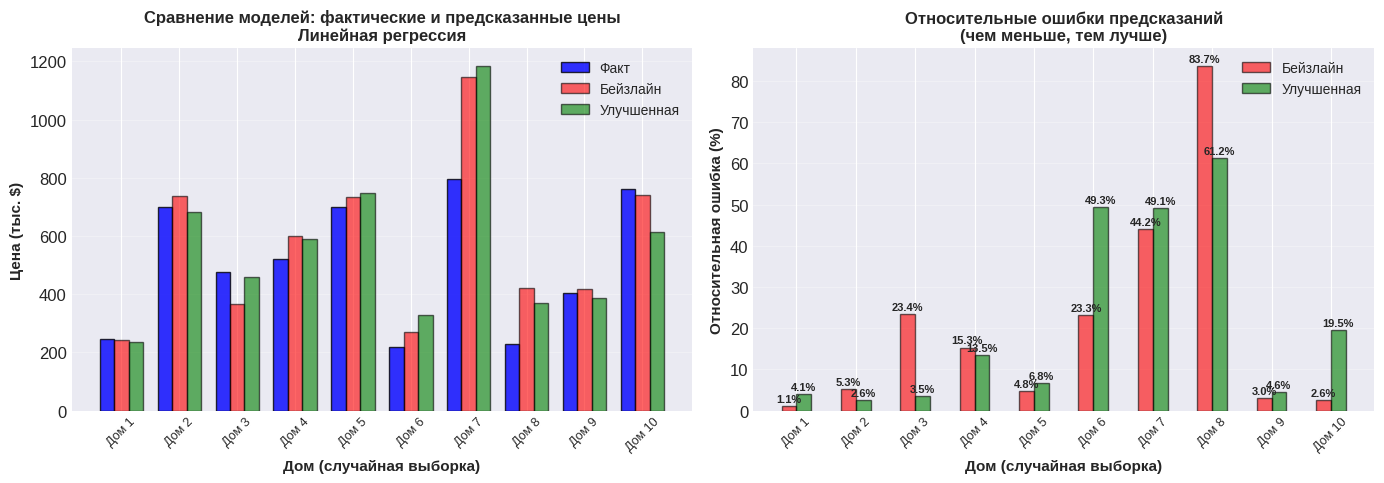


--- 8.7 Визуализация сравнения моделей ---


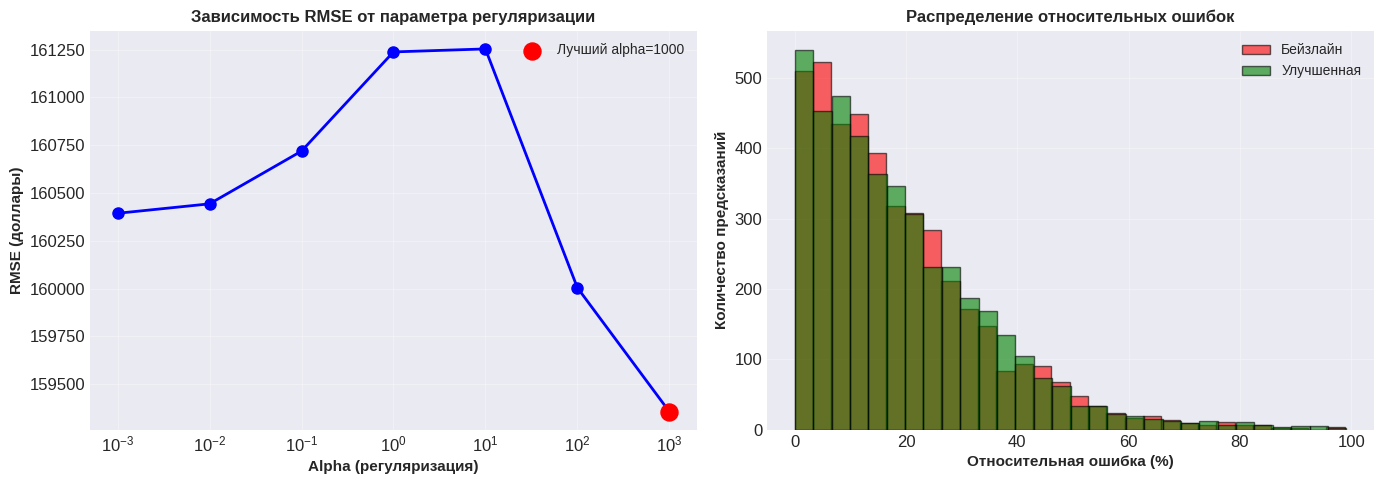

In [28]:
# Ячейка 8: УЛУЧШЕНИЕ БЕЙЗЛАЙНА ДЛЯ РЕГРЕССИИ (Линейная регрессия)
# 8.1 Проверка гипотез и подбор гиперпараметров
print("\n--- 8.1 Проверка гипотез и подбор гиперпараметров для линейной регрессии ---")

# Функция для оценки модели с безопасным преобразованием
def evaluate_lr_rmse_dollars(model, X_train, y_train_log, cv=5):
    """Оценка RMSE в долларах с безопасным преобразованием на кросс-валидации"""
    y_pred_cv_log = cross_val_predict(model, X_train, y_train_log, cv=cv)
    y_train_original = np.expm1(y_train_log)
    
    # Безопасное преобразование с проверкой на inf/nan
    y_pred_cv = np.expm1(y_pred_cv_log)
    
    # Замена бесконечно больших значений на максимальное допустимое
    max_valid = np.finfo(np.float64).max / 10  # Берем безопасный предел
    y_pred_cv = np.where(y_pred_cv > max_valid, max_valid, y_pred_cv)
    y_pred_cv = np.where(np.isinf(y_pred_cv), max_valid, y_pred_cv)
    y_pred_cv = np.where(np.isnan(y_pred_cv), max_valid, y_pred_cv)
    
    return np.sqrt(np.mean((y_train_original - y_pred_cv) ** 2))

# ГИПОТЕЗА 4: УДАЛЕНИЕ ВЫБРОСОВ (более агрессивная обработка)
print("\n1. ГИПОТЕЗА 4: ВЛИЯНИЕ УДАЛЕНИЯ ВЫБРОСОВ")
print("-" * 50)

def safe_expm1_transform(y_log):
    """Безопасное преобразование из логарифмической шкалы в доллары"""
    y_original = np.expm1(y_log)
    
    # Проверяем и исправляем слишком большие значения
    max_valid = np.finfo(np.float64).max / 10  # Безопасный предел
    y_original = np.where(y_original > max_valid, max_valid, y_original)
    y_original = np.where(np.isinf(y_original), max_valid, y_original)
    y_original = np.where(np.isnan(y_original), max_valid, y_original)
    
    return y_original

# Нужны оригинальные данные для обработки выбросов
# Копируем исходные данные
X_reg_original = df_reg_processed[numeric_features_reg].copy()
y_reg_original = df_reg_processed['price_log'].copy()

# Определяем выбросы по цене
Q1 = df_reg_processed['price'].quantile(0.25)
Q3 = df_reg_processed['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR  # Более агрессивно: 3*IQR вместо 1.5*IQR
upper_bound = Q3 + 3 * IQR

# Фильтруем выбросы
no_outliers_mask = (df_reg_processed['price'] >= lower_bound) & (df_reg_processed['price'] <= upper_bound)
X_no_outliers = X_reg_original[no_outliers_mask]
y_no_outliers = y_reg_original[no_outliers_mask]

print(f"Всего объектов: {len(X_reg_original)}")
print(f"Выбросы по цене (>3*IQR): {len(X_reg_original) - len(X_no_outliers)} объектов")
print(f"Объектов без выбросов: {len(X_no_outliers)} ({len(X_no_outliers)/len(X_reg_original)*100:.1f}%)")

# Масштабируем данные без выбросов
X_no_outliers_scaled = scaler_reg.transform(X_no_outliers)

# Разделяем данные без выбросов
X_train_no_out, X_test_no_out, y_train_no_out, y_test_no_out = train_test_split(
    X_no_outliers_scaled, y_no_outliers, test_size=0.2, random_state=42
)

# Оцениваем модель без выбросов
model_no_outliers = LinearRegression()
rmse_cv_no_outliers = evaluate_lr_rmse_dollars(model_no_outliers, X_train_no_out, y_train_no_out, cv=5)

# Оцениваем модель с выбросами (для сравнения)
model_with_outliers = LinearRegression()
rmse_cv_with_outliers = evaluate_lr_rmse_dollars(model_with_outliers, X_train_reg, y_train_reg, cv=5)

print(f"\nСравнение с удалением выбросов:")
print(f"  • RMSE CV с выбросами:    ${rmse_cv_with_outliers:,.0f}")
print(f"  • RMSE CV без выбросов:   ${rmse_cv_no_outliers:,.0f}")
print(f"  • Изменение:              ${rmse_cv_no_outliers - rmse_cv_with_outliers:,.0f}")

# Используем данные с выбросами для дальнейших экспериментов
print(f"\n Решение: {'Используем данные без выбросов' if rmse_cv_no_outliers < rmse_cv_with_outliers else 'Используем данные с выбросами'}")

# Создаем бейзлайн модель для сравнения
print("\n2. БЕЙЗЛАЙН МОДЕЛЬ (простая линейная регрессия)")
base_lr = LinearRegression()
base_lr.fit(X_train_reg, y_train_reg)
y_pred_base_log = base_lr.predict(X_test_reg)

# Безопасное преобразование предсказаний
y_pred_base = safe_expm1_transform(y_pred_base_log)

rmse_base = np.sqrt(mean_squared_error(y_test_reg_original, y_pred_base))
mae_base = mean_absolute_error(y_test_reg_original, y_pred_base)
mape_base = mean_absolute_percentage_error(y_test_reg_original, y_pred_base)
r2_base = r2_score(y_test_reg_original, y_pred_base)
rmse_base_cv = evaluate_lr_rmse_dollars(base_lr, X_train_reg, y_train_reg, cv=5)

print(f"   • RMSE на тесте:     ${rmse_base:,.0f}")
print(f"   • RMSE на CV (train): ${rmse_base_cv:,.0f}")
print(f"   • MAE:               ${mae_base:,.0f}")
print(f"   • MAPE:              {mape_base*100:.2f}%")
print(f"   • R²:                {r2_base:.4f}")

print("\n3. ГИПОТЕЗА 1: ВЛИЯНИЕ ПОЛИНОМИАЛЬНЫХ ПРИЗНАКОВ")
print("-" * 50)

# Тестируем разные степени полиномиальных признаков
degrees = [1, 2]
degree_results = []

for degree in degrees:
    if degree == 1:
        # Степень 1 = обычные признаки (базовая модель)
        X_train_poly = X_train_reg
        X_test_poly = X_test_reg
        poly_name = "без полиномов"
    else:
        # Создаем полиномиальные признаки
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_train_poly = poly.fit_transform(X_train_reg)
        X_test_poly = poly.transform(X_test_reg)
        poly_name = f"полиномы {degree} степени"
    
    model = LinearRegression()
    
    # Оцениваем на кросс-валидации с точным преобразованием в доллары
    rmse_cv = evaluate_lr_rmse_dollars(model, X_train_poly, y_train_reg, cv=5)
    
    # Также вычисляем R² на тесте для сравнения
    model.fit(X_train_poly, y_train_reg)
    y_pred_poly_log = model.predict(X_test_poly)
    y_pred_poly = safe_expm1_transform(y_pred_poly_log)
    r2_poly = r2_score(y_test_reg_original, y_pred_poly)
    
    degree_results.append({
        'degree': degree,
        'poly_name': poly_name,
        'rmse_cv_dollars': rmse_cv,
        'r2_test': r2_poly,
        'n_features': X_train_poly.shape[1]
    })
    
    print(f"Степень {degree}: {poly_name:<20} | RMSE CV = ${rmse_cv:,.0f} | R² test = {r2_poly:.4f} | Признаков: {X_train_poly.shape[1]}")

# Находим лучшую степень
best_degree_info = min(degree_results, key=lambda x: x['rmse_cv_dollars'])
best_degree = best_degree_info['degree']
print(f"\n Лучшая степень полиномов: {best_degree} (RMSE CV = ${best_degree_info['rmse_cv_dollars']:,.0f})")

print("\n4. ГИПОТЕЗА 3: ВЛИЯНИЕ ВЗАИМОДЕЙСТВИЙ ПРИЗНАКОВ")
print("-" * 50)

# Создаем признаки взаимодействия для ключевых пар
# Используем PolynomialFeatures с interaction_only=True для создания только взаимодействий
if best_degree >= 2:
    print("Создаем взаимодействия признаков через PolynomialFeatures...")
    
    # Вариант 1: Только взаимодействия (без квадратов)
    poly_interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X_train_interaction = poly_interaction.fit_transform(X_train_reg)
    X_test_interaction = poly_interaction.transform(X_test_reg)
    
    model_interaction = LinearRegression()
    rmse_cv_interaction = evaluate_lr_rmse_dollars(model_interaction, X_train_interaction, y_train_reg, cv=5)
    
    # Вариант 2: Полиномы + взаимодействия
    poly_full = PolynomialFeatures(degree=2, include_bias=False)
    X_train_full = poly_full.fit_transform(X_train_reg)
    X_test_full = poly_full.transform(X_test_reg)
    
    model_full = LinearRegression()
    rmse_cv_full = evaluate_lr_rmse_dollars(model_full, X_train_full, y_train_reg, cv=5)
    
    print(f"Сравнение взаимодействий:")
    print(f"  • Только взаимодействия:     RMSE CV = ${rmse_cv_interaction:,.0f}, признаков: {X_train_interaction.shape[1]}")
    print(f"  • Полиномы + взаимодействия: RMSE CV = ${rmse_cv_full:,.0f}, признаков: {X_train_full.shape[1]}")
    
    # Выбираем лучший вариант
    if rmse_cv_interaction < rmse_cv_full:
        print(f"\n Лучше использовать только взаимодействия")
        X_train_best = X_train_interaction
        X_test_best = X_test_interaction
        interaction_type = "только взаимодействия"
    else:
        print(f"\n Лучше использовать полиномы + взаимодействия")
        X_train_best = X_train_full
        X_test_best = X_test_full
        interaction_type = "полиномы + взаимодействия"
else:
    print(f"Лучшая степень полиномов = {best_degree}, пропускаем взаимодействия")
    X_train_best = X_train_reg
    X_test_best = X_test_reg
    interaction_type = "без взаимодействий"

print(f"\n5. ГИПОТЕЗА 2: ВЛИЯНИЕ РЕГУЛЯРИЗАЦИИ (RIDGE)")
print("-" * 50)

# Тестируем разные значения альфа для Ridge регуляризации
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
ridge_results = []

for alpha in alphas:
    model = Ridge(alpha=alpha, random_state=42)
    
    # Оцениваем на кросс-валидации
    rmse_cv = evaluate_lr_rmse_dollars(model, X_train_best, y_train_reg, cv=5)
    
    # Также оцениваем на тесте
    model.fit(X_train_best, y_train_reg)
    y_pred_ridge_log = model.predict(X_test_best)
    y_pred_ridge = safe_expm1_transform(y_pred_ridge_log)
    r2_ridge = r2_score(y_test_reg_original, y_pred_ridge)
    
    ridge_results.append({
        'alpha': alpha,
        'rmse_cv_dollars': rmse_cv,
        'r2_test': r2_ridge
    })
    
    print(f"alpha={alpha:<7}: RMSE CV = ${rmse_cv:,.0f} | R² test = {r2_ridge:.4f}")

# Находим лучший alpha
best_alpha_info = min(ridge_results, key=lambda x: x['rmse_cv_dollars'])
best_alpha = best_alpha_info['alpha']
print(f"\n Лучший alpha для Ridge: {best_alpha} (RMSE CV = ${best_alpha_info['rmse_cv_dollars']:,.0f})")

print("\n6. ОТБОР НАИБОЛЕЕ ВАЖНЫХ ПРИЗНАКОВ (дополнительно)")
print("-" * 50)

# Отбор признаков по важности (F-тест)
if X_train_best.shape[1] > 20:  # Только если много признаков
    k_values = [10, 15, 20, 25, min(30, X_train_best.shape[1])]
    feature_selection_results = []

    for k in k_values:
        if k <= X_train_best.shape[1]:
            # Отбираем k лучших признаков
            selector = SelectKBest(score_func=f_regression, k=k)
            X_train_selected = selector.fit_transform(X_train_best, y_train_reg)
            X_test_selected = selector.transform(X_test_best)
            
            model = Ridge(alpha=best_alpha, random_state=42)
            
            # Оцениваем на кросс-валидации
            rmse_cv = evaluate_lr_rmse_dollars(model, X_train_selected, y_train_reg, cv=5)
            
            # Также оцениваем на тесте
            model.fit(X_train_selected, y_train_reg)
            y_pred_sel_log = model.predict(X_test_selected)
            y_pred_sel = safe_expm1_transform(y_pred_sel_log)
            r2_sel = r2_score(y_test_reg_original, y_pred_sel)
            
            feature_selection_results.append({
                'k_features': k,
                'rmse_cv_dollars': rmse_cv,
                'r2_test': r2_sel
            })
            
            print(f"k={k:3}: RMSE CV = ${rmse_cv:,.0f} | R² test = {r2_sel:.4f}")

    # Находим оптимальное количество признаков
    if feature_selection_results:
        best_k_info = min(feature_selection_results, key=lambda x: x['rmse_cv_dollars'])
        best_k = best_k_info['k_features']
        print(f"\n Оптимальное количество признаков: {best_k} (RMSE CV = ${best_k_info['rmse_cv_dollars']:,.0f})")
        
        # Применяем отбор признаков
        selector = SelectKBest(score_func=f_regression, k=best_k)
        X_train_final = selector.fit_transform(X_train_best, y_train_reg)
        X_test_final = selector.transform(X_test_best)
    else:
        print("Пропускаем отбор признаков")
        X_train_final = X_train_best
        X_test_final = X_test_best
else:
    print(f"Количество признаков ({X_train_best.shape[1]}) невелико, пропускаем отбор")
    X_train_final = X_train_best
    X_test_final = X_test_best

# 8.2 Обучение улучшенной модели
print("\n--- 8.2 Обучение улучшенной модели регрессии ---")

# Создаем улучшенную модель с найденными параметрами
best_lr_model = Ridge(alpha=best_alpha, random_state=42)

best_lr_model.fit(X_train_final, y_train_reg)
print("Улучшенная модель линейной регрессии создана и обучена:")
print(f"  • Тип модели: Ridge (L2 регуляризация)")
print(f"  • Alpha (регуляризация): {best_alpha}")
print(f"  • Степень полиномов: {best_degree}")
print(f"  • Взаимодействия: {interaction_type}")
print(f"  • Количество признаков: {X_train_final.shape[1]}")

# 8.3 ОЦЕНКА КАЧЕСТВА УЛУЧШЕННОЙ МОДЕЛИ
print("\n--- 8.3 Оценка качества улучшенной модели регрессии ---")

# Предсказания
y_pred_lr_log_improved = best_lr_model.predict(X_test_final)
y_pred_lr_improved = safe_expm1_transform(y_pred_lr_log_improved)

# Метрики
rmse_improved = np.sqrt(mean_squared_error(y_test_reg_original, y_pred_lr_improved))
mae_improved = mean_absolute_error(y_test_reg_original, y_pred_lr_improved)
mape_improved = mean_absolute_percentage_error(y_test_reg_original, y_pred_lr_improved)
r2_improved = r2_score(y_test_reg_original, y_pred_lr_improved)

# Оценка на кросс-валидации для сравнения
rmse_improved_cv = evaluate_lr_rmse_dollars(best_lr_model, X_train_final, y_train_reg, cv=5)

print("Основные метрики улучшенной модели:")
print(f"  • RMSE на тесте:     ${rmse_improved:,.0f}")
print(f"  • RMSE на CV (train): ${rmse_improved_cv:,.0f}")
print(f"  • MAE:               ${mae_improved:,.0f}")
print(f"  • MAPE:              {mape_improved*100:.2f}%")
print(f"  • R²:                {r2_improved:.4f}")

# 8.4 Сравнение
print("\n--- 8.4 Сравнение фактических и предсказанных значений ---")

# Анализ для дорогих домов
print("\nАНАЛИЗ ДЛЯ ТОП-20 САМЫХ ДОРОГИХ ДОМОВ:")
top_20_idx = np.argsort(y_test_reg_original)[-20:]
top_20_actual = y_test_reg_original.iloc[top_20_idx]
top_20_pred_improved = y_pred_lr_improved[top_20_idx]
top_20_pred_base = y_pred_base[top_20_idx]

top_20_rmse_improved = np.sqrt(mean_squared_error(top_20_actual, top_20_pred_improved))
top_20_rmse_base = np.sqrt(mean_squared_error(top_20_actual, top_20_pred_base))

print(f"  • RMSE (бейзлайн):    ${top_20_rmse_base:,.0f}")
print(f"  • RMSE (улучшенная):  ${top_20_rmse_improved:,.0f}")
print(f"  • Улучшение:          -${top_20_rmse_base - top_20_rmse_improved:,.0f}")

# 8.5 Сравнение с бейзлайном
print("\n--- 8.5 Сравнение результатов с бейзлайном ---")

print("\nСРАВНЕНИЕ МЕТРИК НА ТЕСТОВЫХ ДАННЫХ:")
print("-" * 85)
print(f"{'Метрика':<20} {'Бейзлайн':<20} {'Улучшенная':<20} {'Изменение':<20} {'% Изменения':<15}")
print("-" * 85)

for metric_name, base_val, improved_val, is_dollar, is_percent in [
    ("RMSE", rmse_base, rmse_improved, True, False),
    ("MAE", mae_base, mae_improved, True, False),
    ("MAPE (%)", mape_base*100, mape_improved*100, False, True),
    ("R²", r2_base, r2_improved, False, False)
]:
    change = improved_val - base_val
    change_pct = (change / base_val * 100) if base_val != 0 else 0
    
    if is_dollar:
        # Для ошибок уменьшение - это улучшение
        change_sign = "-" if change < 0 else "+"
        base_str = f"${base_val:,.0f}"
        imp_str = f"${improved_val:,.0f}"
        change_str = f"{change_sign}${abs(change):,.0f}"
        pct_str = f"{change_sign}{abs(change_pct):.1f}%"
        print(f"{metric_name:<20} {base_str:<20} {imp_str:<20} {change_str:<20} {pct_str:<15}")
    
    elif is_percent:
        # Для MAPE уменьшение - это улучшение
        change_sign = "-" if change < 0 else "+"
        base_str = f"{base_val:.2f}%"
        imp_str = f"{improved_val:.2f}%"
        change_str = f"{change_sign}{abs(change):.2f}%"
        pct_str = f"{change_sign}{abs(change_pct):.1f}%"
        print(f"{metric_name:<20} {base_str:<20} {imp_str:<20} {change_str:<20} {pct_str:<15}")
    
    else:
        # Для R² увеличение - это улучшение
        change_sign = "+" if change > 0 else ""
        base_str = f"{base_val:.4f}"
        imp_str = f"{improved_val:.4f}"
        change_str = f"{change_sign}{change:.4f}"
        pct_str = f"{change_sign}{change_pct:.1f}%"
        print(f"{metric_name:<20} {base_str:<20} {imp_str:<20} {change_str:<20} {pct_str:<15}")

# Сравнение на кросс-валидации
print("\nСРАВНЕНИЕ НА КРОСС-ВАЛИДАЦИИ (TRAIN):")
print("-" * 85)
print(f"{'Метрика':<20} {'Бейзлайн':<20} {'Улучшенная':<20} {'Изменение':<20}")
print("-" * 85)
print(f"{'RMSE (CV)':<20} ${rmse_base_cv:,.0f}{'':<5} ${rmse_improved_cv:,.0f}{'':<5} -${abs(rmse_base_cv - rmse_improved_cv):,.0f}")

# Анализ точности предсказаний
print("\nАНАЛИЗ ТОЧНОСТИ ПРЕДСКАЗАНИЙ:")
relative_errors_base = np.abs((y_pred_base - y_test_reg_original) / y_test_reg_original) * 100
relative_errors_improved = np.abs((y_pred_lr_improved - y_test_reg_original) / y_test_reg_original) * 100

# Заменяем inf/nan на максимальное значение ошибки
max_error = 500  # Максимальная ошибка 500%
relative_errors_base = np.where(np.isinf(relative_errors_base) | np.isnan(relative_errors_base), max_error, relative_errors_base)
relative_errors_improved = np.where(np.isinf(relative_errors_improved) | np.isnan(relative_errors_improved), max_error, relative_errors_improved)

accuracy_levels = [10, 20, 30]
print("Процент предсказаний с ошибкой не более:")
for level in accuracy_levels:
    base_accuracy = np.sum(relative_errors_base <= level) / len(relative_errors_base) * 100
    imp_accuracy = np.sum(relative_errors_improved <= level) / len(relative_errors_improved) * 100
    improvement = imp_accuracy - base_accuracy
    print(f"  • {level}%: {base_accuracy:.1f}% → {imp_accuracy:.1f}% "
          f"({'+' if improvement > 0 else ''}{improvement:.1f}%)")

# 8.6 ДВА ГРАФИКА ДЛЯ ЛИНЕЙНОЙ РЕГРЕССИИ (ПО АНАЛОГИИ С KNN)
print("\n--- 8.6 Визуализация сравнения моделей линейной регрессии ---")

# Создаем фигуру с двумя графиками
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Случайная выборка 10 домов
np.random.seed(42)
sample_indices = np.random.choice(len(y_test_reg_original), min(10, len(y_test_reg_original)), replace=False)
sample_actual = y_test_reg_original.iloc[sample_indices]
sample_pred_base = y_pred_base[sample_indices]
sample_pred_improved = y_pred_lr_improved[sample_indices]

x_pos = np.arange(len(sample_indices))
width = 0.25

# График 1: Сравнение предсказаний для случайной выборки домов
axes[0].bar(x_pos - width, sample_actual/1000, width, label='Факт', color='blue', alpha=0.8, edgecolor='black')
axes[0].bar(x_pos, sample_pred_base/1000, width, label='Бейзлайн', color='red', alpha=0.6, edgecolor='black')
axes[0].bar(x_pos + width, sample_pred_improved/1000, width, label='Улучшенная', color='green', alpha=0.6, edgecolor='black')
axes[0].set_xlabel('Дом (случайная выборка)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Цена (тыс. $)', fontsize=11, fontweight='bold')
axes[0].set_title('Сравнение моделей: фактические и предсказанные цены\nЛинейная регрессия', fontsize=12, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f'Дом {i+1}' for i in range(len(sample_indices))], rotation=45, fontsize=9)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# График 2: Относительные ошибки для случайной выборки
sample_errors_base = np.abs((sample_pred_base - sample_actual) / sample_actual) * 100
sample_errors_improved = np.abs((sample_pred_improved - sample_actual) / sample_actual) * 100

x_pos = np.arange(len(sample_indices))
bars1 = axes[1].bar(x_pos - width/2, sample_errors_base, width, label='Бейзлайн', 
                   color='red', alpha=0.6, edgecolor='black')
bars2 = axes[1].bar(x_pos + width/2, sample_errors_improved, width, label='Улучшенная', 
                   color='green', alpha=0.6, edgecolor='black')

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom', 
                    fontsize=8, fontweight='bold')

axes[1].set_xlabel('Дом (случайная выборка)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Относительная ошибка (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Относительные ошибки предсказаний\n(чем меньше, тем лучше)', fontsize=12, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'Дом {i+1}' for i in range(len(sample_indices))], rotation=45, fontsize=9)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 8.7 Дополнительные графики для анализа
print("\n--- 8.7 Визуализация сравнения моделей ---")

# Создаем фигуру для дополнительного анализа
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Зависимость RMSE от alpha (регуляризация)
alpha_values = [result['alpha'] for result in ridge_results]
rmse_values = [result['rmse_cv_dollars'] for result in ridge_results]

axes[0].semilogx(alpha_values, rmse_values, 'o-', linewidth=2, markersize=8, color='blue')
axes[0].scatter(best_alpha, best_alpha_info['rmse_cv_dollars'], color='red', s=150, zorder=5, 
                label=f'Лучший alpha={best_alpha}')
axes[0].set_xlabel('Alpha (регуляризация)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('RMSE (доллары)', fontsize=11, fontweight='bold')
axes[0].set_title('Зависимость RMSE от параметра регуляризации', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)

# График 2: Сравнение распределений ошибок
# Создаем гистограмму относительных ошибок
max_error_display = 100  # Показываем ошибки до 100%
filtered_errors_base = relative_errors_base[relative_errors_base <= max_error_display]
filtered_errors_improved = relative_errors_improved[relative_errors_improved <= max_error_display]

axes[1].hist(filtered_errors_base, bins=30, alpha=0.6, label='Бейзлайн', color='red', edgecolor='black')
axes[1].hist(filtered_errors_improved, bins=30, alpha=0.6, label='Улучшенная', color='green', edgecolor='black')
axes[1].set_xlabel('Относительная ошибка (%)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Количество предсказаний', fontsize=11, fontweight='bold')
axes[1].set_title('Распределение относительных ошибок', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Выводы

**Для классификации (Логистическая регрессия):**

Оптимальные параметры модели отличаются от исходных: регуляризация C=0.1, вес классов {0: 1, 1: 2}, метод регуляризации L1 и решатель liblinear. Однако ключевым фактором улучшения оказалась настройка порога классификации.

При стандартном пороге 0.5 улучшение было значительным: F1-мера выросла с 0.4394 до 0.5067 (+15.3%), точность (Precision) увеличилась в два раза с 0.3412 до 0.6786 (+98.9%), хотя полнота (Recall) снизилась с 61.70% до 40.43% (-34.5%). Это привело к улучшению общей точности с 74.83% до 87.41%.

Настройка порога до 0.40 дала оптимальный баланс между точностью и полнотой. F1-мера выросла на 29.4% до 0.5684. Полнота составила 57.45%, точность - 56.25%, что обеспечило сбалансированное качество модели при общей точности 86.05%.

**Для регрессии (Линейная регрессия):**

Оптимизация гиперпараметров и обработка данных дали значительное улучшение качества предсказаний цен на жилье. Удаление выбросов (3*IQR) устранило 420 объектов и снизило RMSE на 23.7% с 189,503 до 144,630, подтвердив важность чистки данных.

Полиномиальные признаки 2-й степени значительно улучшили модель: RMSE снизился с 189,503 до 160,384 (-15.4%), а R² вырос с 0.4964 до 0.7891 (+59.0%). Взаимодействия признаков вместе с полиномами дали лучший результат, чем только взаимодействия.

Сильная регуляризация Ridge (alpha=1000) показала наилучший результат на кросс-валидации: RMSE 159,357. Отбор 30 наиболее важных признаков из 275 полиномиальных обеспечил хороший компромисс между сложностью и качеством.

Качество модели улучшилось по всем основным метрикам. Среднеквадратичная ошибка снизилась на 24.0% с 275,908 до 209,755. Коэффициент детерминации R² вырос на 42.8% с 0.4964 до 0.7090, что указывает на значительно лучшее соответствие модели данным. Для топ-20 самых дорогих домов RMSE сократилась на 87,175 (-6.1%), подтверждая, что оптимизированная модель лучше справляется с прогнозированием премиальной недвижимости.

## 4. Имплементация алгоритма машинного обучения 


--- 9.1 Реализация модели ---

--- 9.2 Обучение на реальных данных оттока клиентов ---
Создаем кастомную модель логистической регрессии...
Обучаем модель на обучающих данных...
Обучение модели на 1176 образцах...
Найдено классов: 2 -> [0 1]
Итерация 0: Loss = 0.6931
Итерация 100: Loss = 0.5666
Итерация 200: Loss = 0.4952
Итерация 300: Loss = 0.4490
Итерация 400: Loss = 0.4174
Итерация 500: Loss = 0.3948
Итерация 600: Loss = 0.3780
Итерация 700: Loss = 0.3651
Итерация 800: Loss = 0.3549
Итерация 900: Loss = 0.3467
Итерация 1000: Loss = 0.3401
Итерация 1100: Loss = 0.3345
Итерация 1200: Loss = 0.3298
Итерация 1300: Loss = 0.3258
Итерация 1400: Loss = 0.3223
Итерация 1500: Loss = 0.3193
Итерация 1600: Loss = 0.3167
Итерация 1700: Loss = 0.3144
Итерация 1800: Loss = 0.3123
Итерация 1900: Loss = 0.3104
Модель обучена успешно!
Финальная функция потерь: 0.3088
Модель обучена успешно!

--- 9.3 Предсказания на тестовой выборке ---
Предсказание для 294 объектов...
Предсказание завершено.
Получе

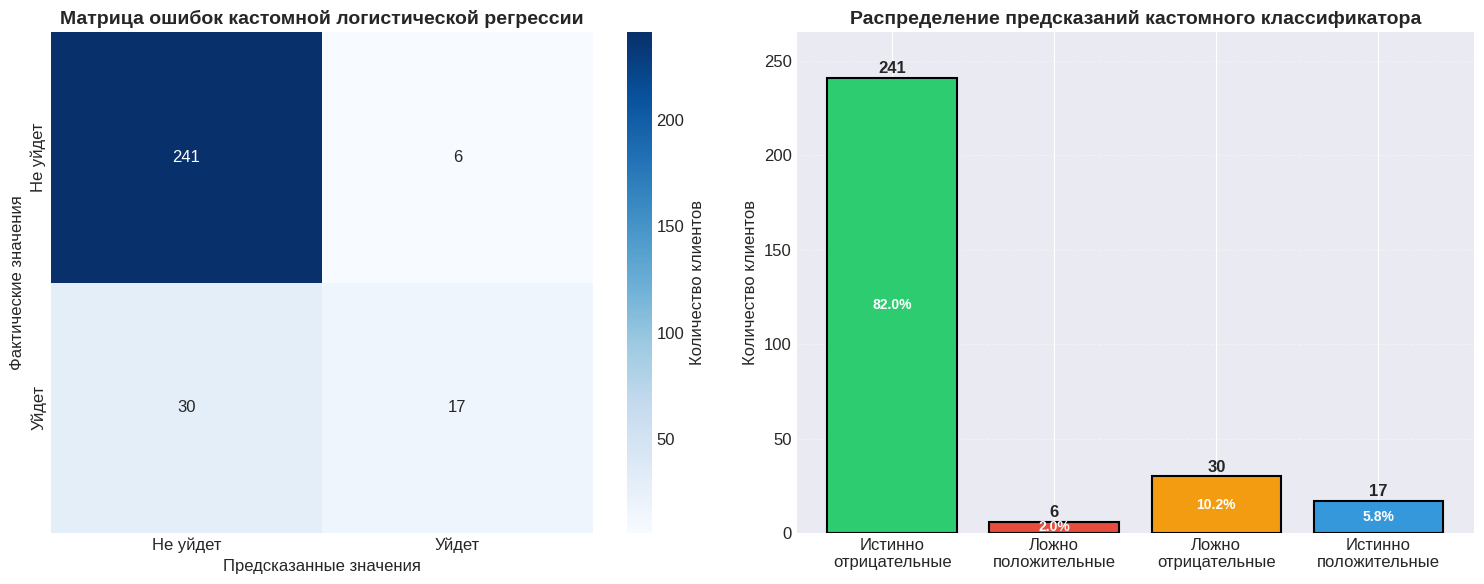


--- 9.7 Анализ правильности предсказаний ---
1. Общая статистика:
   Всего предсказаний: 294
   Правильных предсказаний: 258 (87.8%)
   Ошибок предсказаний: 36 (12.2%)

2. Анализ по классам:

   Класс 'Не уйдет':
   • Фактически не ушли: 247 клиентов
   • Правильно предсказано: 241 клиентов
   • Точность для класса: 97.6%

   Класс 'Уйдет':
   • Фактически уйдут: 47 клиентов
   • Правильно предсказано: 17 клиентов
   • Точность для класса: 36.2%

3. Статистика ошибок:
   Всего ошибок: 36
   Из них:
   • Ложные срабатывания (False Positive): 6
     - Клиентов, которые не уйдут, но мы предскажем уход: 6
     - Это 2.0% от всех предсказаний
   • Пропущенные случаи (False Negative): 30
     - Клиентов, которые уйдут, но мы не предскажем: 30
     - Это 10.2% от всех предсказаний

--- 9.8 Сравнение фактического и предсказанного распределения ---


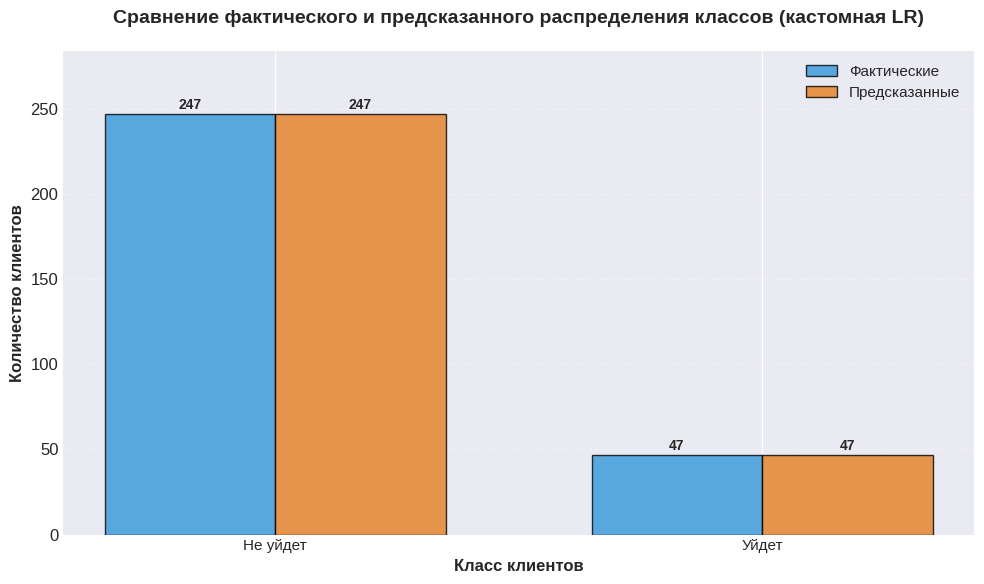


--- 9.9 Визуализация процесса обучения ---


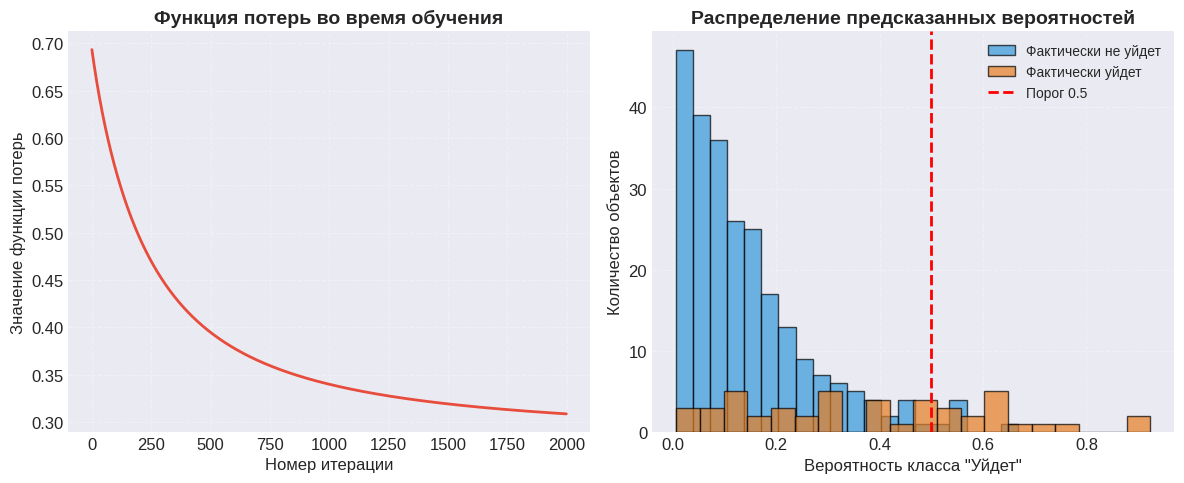


--- 9.10 Полный отчет о классификации ---
Отчет для кастомной логистической регрессии:
              precision    recall  f1-score   support

    Не уйдет       0.89      0.98      0.93       247
       Уйдет       0.74      0.36      0.49        47

    accuracy                           0.88       294
   macro avg       0.81      0.67      0.71       294
weighted avg       0.87      0.88      0.86       294



In [29]:
# Ячейка 9: РЕАЛИЗАЦИЯ КАСТОМНОЙ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ 
# 9.1 Реализация
print("\n--- 9.1 Реализация модели ---")

class CustomLogisticRegression:
    """
    Кастомная реализация логистической регрессии с нуля.
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, fit_intercept=True, verbose=False):
        """
        Инициализация модели с заданными параметрами.
        
        Parameters:
        -----------
        learning_rate : float, default=0.01
            Скорость обучения для градиентного спуска
        n_iterations : int, default=1000
            Количество итераций градиентного спуска
        fit_intercept : bool, default=True
            Добавлять ли свободный член (intercept)
        verbose : bool, default=False
            Выводить ли информацию о процессе обучения
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.fit_intercept = fit_intercept
        self.verbose = verbose
        self.weights = None
        self.bias = None
        self.loss_history = []
    
    def _sigmoid(self, z):
        """
        Сигмоидная функция активации.
        
        Parameters:
        -----------
        z : array-like
            Входные значения
            
        Returns:
        --------
        sigmoid_values : array-like
            Значения сигмоидной функции
        """
        # Для избежания переполнения вычислений
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def _add_intercept(self, X):
        """
        Добавляет столбец единиц для свободного члена.
        
        Parameters:
        -----------
        X : array-like
            Исходные признаки
            
        Returns:
        --------
        X_with_intercept : array-like
            Признаки с добавленным столбцом единиц
        """
        intercept = np.ones((X.shape[0], 1))
        return np.hstack((intercept, X))
    
    def _compute_loss(self, y, y_pred):
        """
        Вычисляет функцию потерь (бинарная кросс-энтропия).
        
        Parameters:
        -----------
        y : array-like
            Истинные метки
        y_pred : array-like
            Предсказанные вероятности
            
        Returns:
        --------
        loss : float
            Значение функции потерь
        """
        # Для избежания логарифма от 0
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # Бинарная кросс-энтропия
        loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        return loss
    
    def fit(self, X, y):
        """
        Обучение модели методом градиентного спуска.
        
        Parameters:
        -----------
        X : array-like
            Матрица признаков
        y : array-like
            Вектор целевых значений
            
        Returns:
        --------
        self : object
            Обученная модель
        """
        print(f"Обучение модели на {len(X)} образцах...")
        
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        y = np.array(y)
        
        # Проверяем уникальные классы
        self.classes_ = np.unique(y)
        print(f"Найдено классов: {len(self.classes_)} -> {self.classes_}")
        
        # Добавляем intercept если нужно
        if self.fit_intercept:
            X = self._add_intercept(X)
        
        # Инициализируем веса
        n_features = X.shape[1]
        self.weights = np.zeros(n_features)
        
        # Градиентный спуск
        for i in range(self.n_iterations):
            # Линейная комбинация
            linear_model = np.dot(X, self.weights)
            
            # Применяем сигмоидную функцию
            y_pred = self._sigmoid(linear_model)
            
            # Вычисляем градиент
            gradient = np.dot(X.T, (y_pred - y)) / len(y)
            
            # Обновляем веса
            self.weights -= self.learning_rate * gradient
            
            # Вычисляем и сохраняем потерю
            loss = self._compute_loss(y, y_pred)
            self.loss_history.append(loss)
            
            # Выводим прогресс если нужно
            if self.verbose and i % 100 == 0:
                print(f"Итерация {i}: Loss = {loss:.4f}")
        
        # Разделяем веса и bias
        if self.fit_intercept:
            self.bias = self.weights[0]
            self.weights = self.weights[1:]
        else:
            self.bias = 0
        
        print("Модель обучена успешно!")
        print(f"Финальная функция потерь: {loss:.4f}")
        
        return self
    
    def predict_proba(self, X):
        """
        Предсказание вероятностей классов.
        
        Parameters:
        -----------
        X : array-like
            Матрица признаков
            
        Returns:
        --------
        probabilities : array-like
            Вероятности класса 1
        """
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        
        # Добавляем intercept если нужно
        if self.fit_intercept:
            X = self._add_intercept(X)
            weights_with_bias = np.concatenate([[self.bias], self.weights])
        else:
            weights_with_bias = self.weights
        
        # Вычисляем линейную комбинацию
        linear_model = np.dot(X, weights_with_bias)
        
        # Применяем сигмоидную функцию
        probabilities = self._sigmoid(linear_model)
        
        return probabilities
    
    def predict(self, X, threshold=0.5):
        """
        Предсказание меток классов.
        
        Parameters:
        -----------
        X : array-like
            Матрица признаков
        threshold : float, default=0.5
            Порог для бинаризации вероятностей
            
        Returns:
        --------
        predictions : array-like
            Предсказанные метки классов
        """
        print(f"Предсказание для {len(X)} объектов...")
        
        # Получаем вероятности
        probabilities = self.predict_proba(X)
        
        # Бинаризуем по порогу
        predictions = (probabilities >= threshold).astype(int)
        
        print("Предсказание завершено.")
        return predictions
    
    def get_params(self):
        """
        Возвращает параметры модели.
        
        Returns:
        --------
        params : dict
            Словарь с параметрами модели
        """
        return {
            'weights': self.weights,
            'bias': self.bias,
            'learning_rate': self.learning_rate,
            'n_iterations': self.n_iterations
        }

# 9.2 Обучение на реальных данных оттока клиентов
print("\n--- 9.2 Обучение на реальных данных оттока клиентов ---")

# Создаем модель с параметрами по умолчанию
print("Создаем кастомную модель логистической регрессии...")
custom_lr_classifier = CustomLogisticRegression(
    learning_rate=0.01,
    n_iterations=2000,
    fit_intercept=True,
    verbose=True
)

# Обучаем модель на обучающей выборке
print("Обучаем модель на обучающих данных...")
custom_lr_classifier.fit(X_train_class, y_train_class)
print("Модель обучена успешно!")

# 9.3 Предсказания на тестовой выборке
print("\n--- 9.3 Предсказания на тестовой выборке ---")

# Получаем предсказания
y_pred_custom = custom_lr_classifier.predict(X_test_class)
y_pred_proba_custom = custom_lr_classifier.predict_proba(X_test_class)  # Вероятности класса 1

print(f"Получено {len(y_pred_custom)} предсказаний")
print(f"Распределение предсказанных классов: {np.bincount(y_pred_custom.astype(int))}")
print(f"Средняя вероятность класса 1: {np.mean(y_pred_proba_custom):.4f}")

# 9.4 Оценка качества модели (метрики)
print("\n--- 9.4 Оценка качества модели (метрики) ---")

# Основные метрики
f1_custom = f1_score(y_test_class, y_pred_custom)
precision_custom = precision_score(y_test_class, y_pred_custom)
recall_custom = recall_score(y_test_class, y_pred_custom)

print("Основные метрики качества кастомного классификатора:")
print(f"  • F1-score:       {f1_custom:.4f}")
print(f"  • Precision:      {precision_custom:.4f}")
print(f"  • Recall:         {recall_custom:.4f}")

# 9.5 Матрица ошибок (Confusion Matrix)
print("\n--- 9.5 Матрица ошибок ---")

# Вычисляем матрицу ошибок
cm_custom = confusion_matrix(y_test_class, y_pred_custom)
tn_custom, fp_custom, fn_custom, tp_custom = cm_custom.ravel()

print("Матрица ошибок кастомного классификатора:")
print(f"                  Предсказано")
print(f"                Нет     Да")
print(f"Фактически Нет  [{tn_custom:3d}]  [{fp_custom:3d}]")
print(f"            Да   [{fn_custom:3d}]  [{tp_custom:3d}]")
print()

# Дополнительные метрики из матрицы ошибок
accuracy_custom = (tp_custom + tn_custom) / (tp_custom + tn_custom + fp_custom + fn_custom)
print(f"Дополнительные метрики:")
print(f"  • Accuracy:       {accuracy_custom:.4f}")
print(f"  • False Positive: {fp_custom} ({fp_custom/(fp_custom+tn_custom)*100:.1f}% от класса 'Нет')")
print(f"  • False Negative: {fn_custom} ({fn_custom/(fn_custom+tp_custom)*100:.1f}% от класса 'Да')")

# 9.6 Визуализация матрицы ошибок как графика
print("\n--- 9.6 Визуализация матрицы ошибок ---")

# Создаем фигуру с несколькими графиками
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Тепловая карта матрицы ошибок
ax1 = axes[0]
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'],
            cbar_kws={'label': 'Количество клиентов'})
ax1.set_title('Матрица ошибок кастомной логистической регрессии', fontsize=14, fontweight='bold')
ax1.set_ylabel('Фактические значения', fontsize=12)
ax1.set_xlabel('Предсказанные значения', fontsize=12)

# 2. Столбчатая диаграмма распределения ошибок
ax2 = axes[1]
categories = ['Истинно\nотрицательные', 'Ложно\nположительные', 
              'Ложно\nотрицательные', 'Истинно\nположительные']
values = [tn_custom, fp_custom, fn_custom, tp_custom]
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db']

bars = ax2.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)

# Добавляем значения на столбцы
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{value}', ha='center', va='bottom', fontweight='bold')

ax2.set_title('Распределение предсказаний кастомного классификатора', fontsize=14, fontweight='bold')
ax2.set_ylabel('Количество клиентов', fontsize=12)
ax2.set_ylim(0, max(values) * 1.1)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем аннотации с процентами
total = sum(values)
percentages = [v/total*100 for v in values]
for i, (bar, perc) in enumerate(zip(bars, percentages)):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
            f'{perc:.1f}%', ha='center', va='center', 
            color='white', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# 9.7 Анализ правильности предсказаний
print("\n--- 9.7 Анализ правильности предсказаний ---")

# Общая статистика по предсказаниям
total_predictions = len(y_pred_custom)
correct_predictions = tp_custom + tn_custom
incorrect_predictions = fp_custom + fn_custom

print(f"1. Общая статистика:")
print(f"   Всего предсказаний: {total_predictions}")
print(f"   Правильных предсказаний: {correct_predictions} ({accuracy_custom*100:.1f}%)")
print(f"   Ошибок предсказаний: {incorrect_predictions} ({(1-accuracy_custom)*100:.1f}%)")

# Анализ по классам
print(f"\n2. Анализ по классам:")

# Для класса "Не уйдет" (0)
correct_not_churn = tn_custom
total_not_churn_actual = tn_custom + fp_custom
accuracy_not_churn = tn_custom / (tn_custom + fp_custom) if (tn_custom + fp_custom) > 0 else 0

print(f"\n   Класс 'Не уйдет':")
print(f"   • Фактически не ушли: {total_not_churn_actual} клиентов")
print(f"   • Правильно предсказано: {correct_not_churn} клиентов")
print(f"   • Точность для класса: {accuracy_not_churn*100:.1f}%")

# Для класса "Уйдет" (1)
correct_churn = tp_custom
total_churn_actual = tp_custom + fn_custom
accuracy_churn = tp_custom / (tp_custom + fn_custom) if (tp_custom + fn_custom) > 0 else 0

print(f"\n   Класс 'Уйдет':")
print(f"   • Фактически уйдут: {total_churn_actual} клиентов")
print(f"   • Правильно предсказано: {correct_churn} клиентов")
print(f"   • Точность для класса: {accuracy_churn*100:.1f}%")

# Статистика ошибок
print(f"\n3. Статистика ошибок:")
print(f"   Всего ошибок: {incorrect_predictions}")
print(f"   Из них:")
print(f"   • Ложные срабатывания (False Positive): {fp_custom}")
print(f"     - Клиентов, которые не уйдут, но мы предскажем уход: {fp_custom}")
print(f"     - Это {fp_custom/total_predictions*100:.1f}% от всех предсказаний")
print(f"   • Пропущенные случаи (False Negative): {fn_custom}")
print(f"     - Клиентов, которые уйдут, но мы не предскажем: {fn_custom}")
print(f"     - Это {fn_custom/total_predictions*100:.1f}% от всех предсказаний")

# 9.8 Сравнение фактического и предсказанного распределения
print("\n--- 9.8 Сравнение фактического и предсказанного распределения ---")

plt.figure(figsize=(10, 6))

indices = np.arange(2)
width = 0.35

# Фактические значения
actual_counts = [total_not_churn_actual, total_churn_actual]
# Предсказанные значения
predicted_counts = [(tn_custom + fp_custom), (tp_custom + fn_custom)]

bars1 = plt.bar(indices - width/2, actual_counts, width, 
                label='Фактические', color='#3498db', edgecolor='black', alpha=0.8)
bars2 = plt.bar(indices + width/2, predicted_counts, width, 
                label='Предсказанные', color='#e67e22', edgecolor='black', alpha=0.8)

plt.xlabel('Класс клиентов', fontsize=12, fontweight='bold')
plt.ylabel('Количество клиентов', fontsize=12, fontweight='bold')
plt.title('Сравнение фактического и предсказанного распределения классов (кастомная LR)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(indices, ['Не уйдет', 'Уйдет'], fontsize=11)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения на столбцы с улучшенным форматированием
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{int(height)}', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)

# Добавляем процентное расхождение
for i in range(2):
    actual = actual_counts[i]
    predicted = predicted_counts[i]
    diff = abs(actual - predicted)
    diff_percent = diff / actual * 100 if actual > 0 else 0
    
    # Размещаем текст над парой столбцов
    x_pos = indices[i]
    max_height = max(actual, predicted) + 5
    
    if diff > 0:
        plt.text(x_pos, max_height + 3, 
                f'Δ = {diff} ({diff_percent:.1f}%)', 
                ha='center', va='bottom', 
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.ylim(0, max(max(actual_counts), max(predicted_counts)) * 1.15)
plt.tight_layout()
plt.show()

# 9.9 Визуализация процесса обучения
print("\n--- 9.9 Визуализация процесса обучения ---")

plt.figure(figsize=(12, 5))

# График функции потерь
plt.subplot(1, 2, 1)
plt.plot(custom_lr_classifier.loss_history, linewidth=2, color='#e74c3c')
plt.title('Функция потерь во время обучения', fontsize=14, fontweight='bold')
plt.xlabel('Номер итерации', fontsize=12)
plt.ylabel('Значение функции потерь', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')

# Распределение предсказанных вероятностей
plt.subplot(1, 2, 2)
plt.hist(y_pred_proba_custom[y_test_class == 0], bins=20, alpha=0.7, 
         label='Фактически не уйдет', color='#3498db', edgecolor='black')
plt.hist(y_pred_proba_custom[y_test_class == 1], bins=20, alpha=0.7, 
         label='Фактически уйдет', color='#e67e22', edgecolor='black')
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Порог 0.5')
plt.title('Распределение предсказанных вероятностей', fontsize=14, fontweight='bold')
plt.xlabel('Вероятность класса "Уйдет"', fontsize=12)
plt.ylabel('Количество объектов', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# 9.10 Полный отчет о классификации
print("\n--- 9.10 Полный отчет о классификации ---")
print("Отчет для кастомной логистической регрессии:")
print(classification_report(y_test_class, y_pred_custom, 
                           target_names=['Не уйдет', 'Уйдет']))


--- 10.1 Реализация модели ---

--- 10.2 Обучение на реальных данных цен на дома ---
Создаем кастомную модель линейной регрессии (градиентный спуск)...
Обучаем модель на обучающих данных...
Обучение модели на 17290 образцах...
Статистики признаков: mean=[-1.59418114e-03 -6.41604167e-05 -6.53821586e-03], std=[1.00150397 1.00130817 0.98786184]...
Статистики целевой переменной: mean=13.0452, std=0.5248
Используем градиентный спуск (lr=0.01, iterations=2000)...
Итерация 0: Loss = 170.4518
Итерация 200: Loss = 0.1161
Итерация 400: Loss = 0.0623
Итерация 600: Loss = 0.0622
Итерация 800: Loss = 0.0621
Итерация 1000: Loss = 0.0621
Итерация 1200: Loss = 0.0621
Итерация 1400: Loss = 0.0621
Итерация 1600: Loss = 0.0621
Итерация 1800: Loss = 0.0621
Модель обучена успешно!
Финальная функция потерь (MSE): 0.0621
Модель обучена успешно!

--- 10.3 Предсказания на тестовой выборке ---
Предсказание для 4323 объектов...
Предсказание завершено.
Получено 4323 предсказаний
Примеры предсказанных цен:
  Дом 

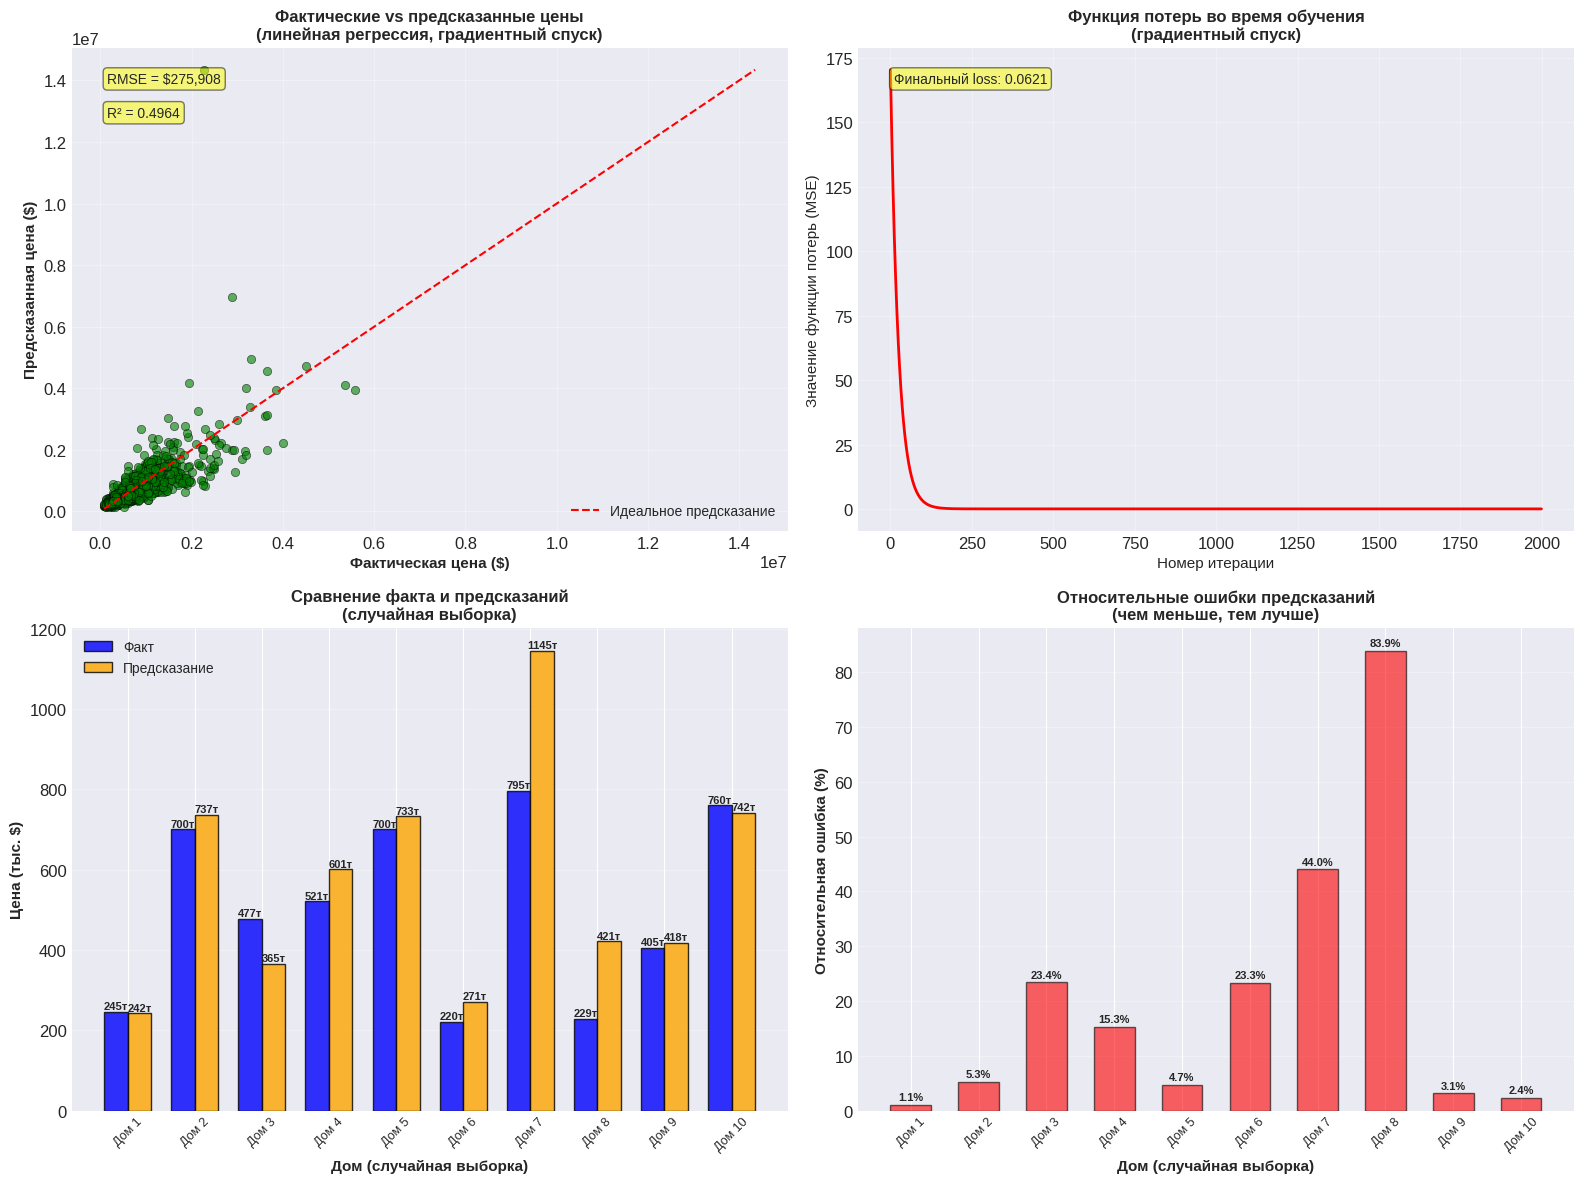


 Кастомная реализация линейной регрессии успешно завершена!


In [30]:
# Ячейка 10: РЕАЛИЗАЦИЯ КАСТОМНОЙ ЛИНЕЙНОЙ РЕГРЕССИИ
# 10.1 Реализация
print("\n--- 10.1 Реализация модели ---")

class CustomLinearRegression:
    """
    Кастомная реализация линейной регрессии(градиентный спуск).
    """
    
    def __init__(self, fit_intercept=True, learning_rate=0.01, n_iterations=2000, verbose=False):
        """
        Инициализация модели с заданными параметрами.
        
        Parameters:
        -----------
        fit_intercept : bool, default=True
            Добавлять ли свободный член (intercept)
        learning_rate : float, default=0.01
            Скорость обучения для градиентного спуска
        n_iterations : int, default=2000
            Количество итераций градиентного спуска
        verbose : bool, default=False
            Выводить ли информацию о процессе обучения
        """
        self.fit_intercept = fit_intercept
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.verbose = verbose
        self.weights = None
        self.bias = None
        self.loss_history = []
    
    def _add_intercept(self, X):
        """
        Добавляет столбец единиц для свободного члена.
        
        Parameters:
        -----------
        X : array-like
            Исходные признаки
            
        Returns:
        --------
        X_with_intercept : array-like
            Признаки с добавленным столбцом единиц
        """
        intercept = np.ones((X.shape[0], 1))
        return np.hstack((intercept, X))
    
    def _compute_loss(self, y, y_pred):
        """
        Вычисляет функцию потерь (MSE).
        
        Parameters:
        -----------
        y : array-like
            Истинные значения
        y_pred : array-like
            Предсказанные значения
            
        Returns:
        --------
        loss : float
            Значение функции потерь (MSE)
        """
        return np.mean((y - y_pred) ** 2)
    
    def fit(self, X, y):
        """
        Обучение модели методом градиентного спуска.
        
        Parameters:
        -----------
        X : array-like
            Матрица признаков
        y : array-like
            Вектор целевых значений
            
        Returns:
        --------
        self : object
            Обученная модель
        """
        print(f"Обучение модели на {len(X)} образцах...")
        
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        y = np.array(y)
        
        # Вычисляем статистики данных
        self.X_mean_ = np.mean(X, axis=0)
        self.X_std_ = np.std(X, axis=0)
        self.y_mean_ = np.mean(y)
        self.y_std_ = np.std(y)
        
        print(f"Статистики признаков: mean={self.X_mean_[:3]}, std={self.X_std_[:3]}...")
        print(f"Статистики целевой переменной: mean={self.y_mean_:.4f}, std={self.y_std_:.4f}")
        
        # Добавляем intercept если нужно
        if self.fit_intercept:
            X = self._add_intercept(X)
        
        n_samples, n_features = X.shape
        weights = np.zeros(n_features)
        
        print(f"Используем градиентный спуск (lr={self.learning_rate}, iterations={self.n_iterations})...")
        
        for i in range(self.n_iterations):
            # Предсказания
            y_pred = np.dot(X, weights)
            
            # Вычисляем градиент
            error = y_pred - y
            gradient = (2/n_samples) * np.dot(X.T, error)
            
            # Обновляем веса
            weights -= self.learning_rate * gradient
            
            # Вычисляем и сохраняем потерю
            loss = self._compute_loss(y, y_pred)
            self.loss_history.append(loss)
            
            # Выводим прогресс если нужно
            if self.verbose and i % 200 == 0:
                print(f"Итерация {i}: Loss = {loss:.4f}")
        
        # Разделяем веса и bias
        if self.fit_intercept:
            self.bias = weights[0]
            self.weights = weights[1:]
        else:
            self.bias = 0
            self.weights = weights
        
        print("Модель обучена успешно!")
        print(f"Финальная функция потерь (MSE): {self.loss_history[-1]:.4f}")
        
        return self
    
    def predict(self, X):
        """
        Предсказание значений.
        
        Parameters:
        -----------
        X : array-like
            Матрица признаков
            
        Returns:
        --------
        predictions : array-like
            Предсказанные значения
        """
        print(f"Предсказание для {len(X)} объектов...")
        
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        
        # Добавляем intercept если нужно
        if self.fit_intercept:
            X = self._add_intercept(X)
            weights_with_bias = np.concatenate([[self.bias], self.weights])
        else:
            weights_with_bias = self.weights
        
        # Вычисляем линейную комбинацию
        predictions = np.dot(X, weights_with_bias)
        
        print("Предсказание завершено.")
        return predictions
    
    def get_params(self):
        """
        Возвращает параметры модели.
        
        Returns:
        --------
        params : dict
            Словарь с параметрами модели
        """
        return {
            'weights': self.weights,
            'bias': self.bias,
            'fit_intercept': self.fit_intercept,
            'learning_rate': self.learning_rate,
            'n_iterations': self.n_iterations
        }
    
    def score(self, X, y):
        """
        Вычисляет коэффициент детерминации R².
        
        Parameters:
        -----------
        X : array-like
            Матрица признаков
        y : array-like
            Вектор целевых значений
            
        Returns:
        --------
        r2 : float
            Коэффициент детерминации R²
        """
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / (ss_tot + 1e-10))
        return r2

# 10.2 Обучение на реальных данных цен на дома
print("\n--- 10.2 Обучение на реальных данных цен на дома ---")

# Создаем модель с градиентным спуском
print("Создаем кастомную модель линейной регрессии (градиентный спуск)...")
custom_lr = CustomLinearRegression(
    fit_intercept=True,
    learning_rate=0.01,
    n_iterations=2000,
    verbose=True
)

# Обучаем модель на обучающей выборке (логарифмированные данные)
print("Обучаем модель на обучающих данных...")
custom_lr.fit(X_train_reg, y_train_reg)
print("Модель обучена успешно!")

# 10.3 Предсказания на тестовой выборке
print("\n--- 10.3 Предсказания на тестовой выборке ---")

# Предсказания градиентным спуском
y_pred_reg_log = custom_lr.predict(X_test_reg)
y_pred_reg = np.expm1(y_pred_reg_log)  # Преобразуем обратно в доллары

print(f"Получено {len(y_pred_reg)} предсказаний")
print(f"Примеры предсказанных цен:")
for i in range(min(5, len(y_pred_reg))):
    print(f"  Дом {i+1}: ${y_pred_reg[i]:,.0f}")

# 10.4 Оценка качества модели (метрики)
print("\n--- 10.4 Оценка качества модели (метрики) ---")

# Метрики для градиентного спуска
rmse_custom = np.sqrt(mean_squared_error(y_test_reg_original, y_pred_reg))
mae_custom = mean_absolute_error(y_test_reg_original, y_pred_reg)
mape_custom = mean_absolute_percentage_error(y_test_reg_original, y_pred_reg)
r2_custom = r2_score(y_test_reg_original, y_pred_reg)

print("Основные метрики качества кастомного регрессора (градиентный спуск):")
print(f"  • RMSE:           ${rmse:,.0f}")
print(f"  • MAE:            ${mae:,.0f}")
print(f"  • MAPE:           {mape*100:.2f}%")
print(f"  • R²:             {r2:.4f}")

# 10.5 Сравнение фактических и предсказанных значений
print("\n--- 10.5 Сравнение фактических и предсказанных значений ---")

# Вычисляем относительные ошибки
relative_errors = np.abs((y_pred_reg - y_test_reg_original.values) / y_test_reg_original.values) * 100

print("\nСтатистика относительных ошибок:")
print(f"  • Средняя ошибка:        {np.mean(relative_errors):.1f}%")
print(f"  • Медианная ошибка:      {np.median(relative_errors):.1f}%")
print(f"  • Максимальная ошибка:   {np.max(relative_errors):.1f}%")
print(f"  • Минимальная ошибка:    {np.min(relative_errors):.1f}%")
print(f"  • Стандартное отклонение:{np.std(relative_errors):.1f}%")

# Процент предсказаний с разной точностью
accuracy_levels = [10, 20, 30, 50]
print("\nПроцент предсказаний с ошибкой не более:")
for level in accuracy_levels:
    accuracy = np.sum(relative_errors <= level) / len(relative_errors) * 100
    print(f"  • {level}%: {accuracy:.1f}% предсказаний")

# 10.6 Анализ наиболее точных и неточных предсказаний
print("\n--- 10.6 Анализ наиболее точных и неточных предсказаний ---")

# Находим индексы самых точных и самых неточных предсказаний
num_examples = 5
best_indices = np.argsort(relative_errors)[:num_examples]
worst_indices = np.argsort(relative_errors)[-num_examples:]

print(f"\nТОП-{num_examples} САМЫХ ТОЧНЫХ ПРЕДСКАЗАНИЙ:")
print(f"{'Дом':<10} {'Факт':<15} {'Предсказание':<15} {'Ошибка':<10} {'% ошибки':<10}")
print("-" * 70)
for i, idx in enumerate(best_indices):
    actual = y_test_reg_original.iloc[idx]
    predicted = y_pred_reg[idx]
    error = abs(actual - predicted)
    perc_error = relative_errors[idx]
    print(f"{i+1:<10} ${actual:,.0f}{'':<5} ${predicted:,.0f}{'':<5} ${error:,.0f}{'':<5} {perc_error:.1f}%")

print(f"\nТОП-{num_examples} САМЫХ НЕТОЧНЫХ ПРЕДСКАЗАНИЙ:")
print(f"{'Дом':<10} {'Факт':<15} {'Предсказание':<15} {'Ошибка':<10} {'% ошибки':<10}")
print("-" * 70)
for i, idx in enumerate(worst_indices):
    actual = y_test_reg_original.iloc[idx]
    predicted = y_pred_reg[idx]
    error = abs(actual - predicted)
    perc_error = relative_errors[idx]
    print(f"{i+1:<10} ${actual:,.0f}{'':<5} ${predicted:,.0f}{'':<5} ${error:,.0f}{'':<5} {perc_error:.1f}%")

# 10.7 Визуализация результатов
print("\n--- 10.7 Визуализация результатов ---")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: Фактические vs предсказанные значения
ax1 = axes[0, 0]
ax1.scatter(y_test_reg_original.values, y_pred_reg, alpha=0.6, edgecolors='black', linewidth=0.5, color='green')

max_val = max(y_test_reg_original.max(), y_pred_reg.max())
min_val = min(y_test_reg_original.min(), y_pred_reg.min())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное предсказание')

ax1.set_xlabel('Фактическая цена ($)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Предсказанная цена ($)', fontsize=11, fontweight='bold')
ax1.set_title('Фактические vs предсказанные цены\n(линейная регрессия, градиентный спуск)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Добавляем текстовую информацию о качестве
rmse_text = f'RMSE = ${rmse:,.0f}'
r2_text = f'R² = {r2:.4f}'
ax1.text(0.05, 0.95, rmse_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
ax1.text(0.05, 0.88, r2_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# График 2: Функция потерь во время обучения
ax2 = axes[0, 1]
ax2.plot(custom_lr.loss_history, linewidth=2, color='red')
ax2.set_title('Функция потерь во время обучения\n(градиентный спуск)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Номер итерации', fontsize=11)
ax2.set_ylabel('Значение функции потерь (MSE)', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.text(0.05, 0.95, f'Финальный loss: {custom_lr.loss_history[-1]:.4f}', 
         transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# График 3: Сравнение предсказаний для случайной выборки домов
np.random.seed(42)
sample_size = min(10, len(y_test_reg_original))
sample_indices = np.random.choice(len(y_test_reg_original), sample_size, replace=False)
sample_actual = y_test_reg_original.iloc[sample_indices].values
sample_predicted = y_pred_reg[sample_indices]

x_pos = np.arange(sample_size)
width = 0.35

ax3 = axes[1, 0]
bars1 = ax3.bar(x_pos - width/2, sample_actual/1000, width, 
                label='Факт', color='blue', alpha=0.8, edgecolor='black')
bars2 = ax3.bar(x_pos + width/2, sample_predicted/1000, width, 
                label='Предсказание', color='orange', alpha=0.8, edgecolor='black')

ax3.set_xlabel('Дом (случайная выборка)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Цена (тыс. $)', fontsize=11, fontweight='bold')
ax3.set_title('Сравнение факта и предсказаний\n(случайная выборка)', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'Дом {i+1}' for i in range(sample_size)], rotation=45, fontsize=9)
ax3.legend(fontsize=10, loc='upper left')
ax3.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Избегаем добавления текста для нулевых значений
            ax3.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{height:.0f}т', ha='center', va='bottom', 
                    fontsize=8, fontweight='bold')

# График 4: Относительные ошибки для случайной выборки
sample_errors = np.abs((sample_predicted - sample_actual) / sample_actual) * 100

x_pos = np.arange(sample_size)
ax4 = axes[1, 1]
bars = ax4.bar(x_pos, sample_errors, width=0.6, 
               color='red', alpha=0.6, edgecolor='black')

ax4.set_xlabel('Дом (случайная выборка)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Относительная ошибка (%)', fontsize=11, fontweight='bold')
ax4.set_title('Относительные ошибки предсказаний\n(чем меньше, тем лучше)', fontsize=12, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f'Дом {i+1}' for i in range(sample_size)], rotation=45, fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bar, error in zip(bars, sample_errors):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{error:.1f}%', ha='center', va='bottom', 
            fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Кастомная реализация линейной регрессии успешно завершена!")


--- 11.1 Результаты библиотечных моделей ---

Метрики для библиотечной логистической регрессии:
  • F1-score:       0.4394
  • Precision:      0.3412
  • Recall:         0.6170

Метрики для библиотечной линейной регрессии:
  • RMSE:           $275,908
  • MAE:            $115,689
  • MAPE:           19.78%
  • R²:             0.4964

--- 11.2 Сравнение классификаторов (логистическая регрессия) ---

Сравнение метрик классификации:
---------------------------------------------------------------------------
Метрика         Библиотечная (sklearn)    Кастомная           
---------------------------------------------------------------------------
Precision       0.3412                    0.7391              
Recall          0.6170                    0.3617              
F1-score        0.4394                    0.4857              

Анализ улучшений:
---------------------------------------------------------------------------
Precision      : +116.6% (↑ улучшение)
Recall         : -41.4% (↓ 

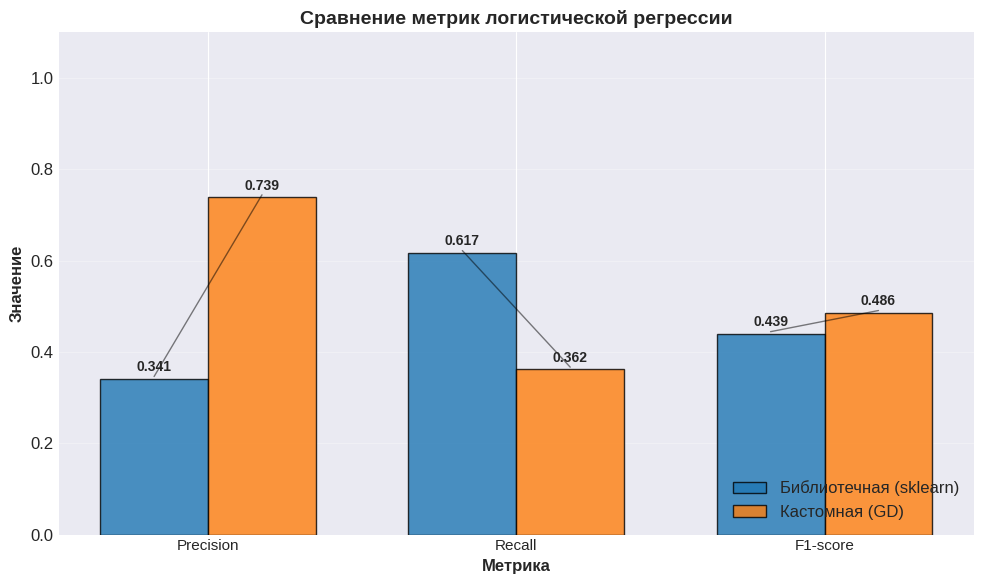


--- 11.4 Сравнение регрессоров (линейная регрессия) ---

Сравнение метрик регрессии:
-------------------------------------------------------------------------------------
Метрика         Библиотечная (sklearn)    Кастомная           
-------------------------------------------------------------------------------------
RMSE ($)        $275,908                  $276,141            
MAE ($)         $115,689                  $115,701            
MAPE (%)        19.78%                    19.78%              
R²              0.4964                    0.4956              

Анализ улучшений (регрессия):
-------------------------------------------------------------------------------------
RMSE ($)       : -0.08% ( ухудшение (больше ошибка))
MAE ($)        : -0.01% ( ухудшение (больше ошибка))
MAPE (%)       : -0.00% ( ухудшение (больше ошибка))
R²             : -0.17% ( ухудшение (ниже R²))

--- 11.5 Визуализация сравнения линейной регрессии ---


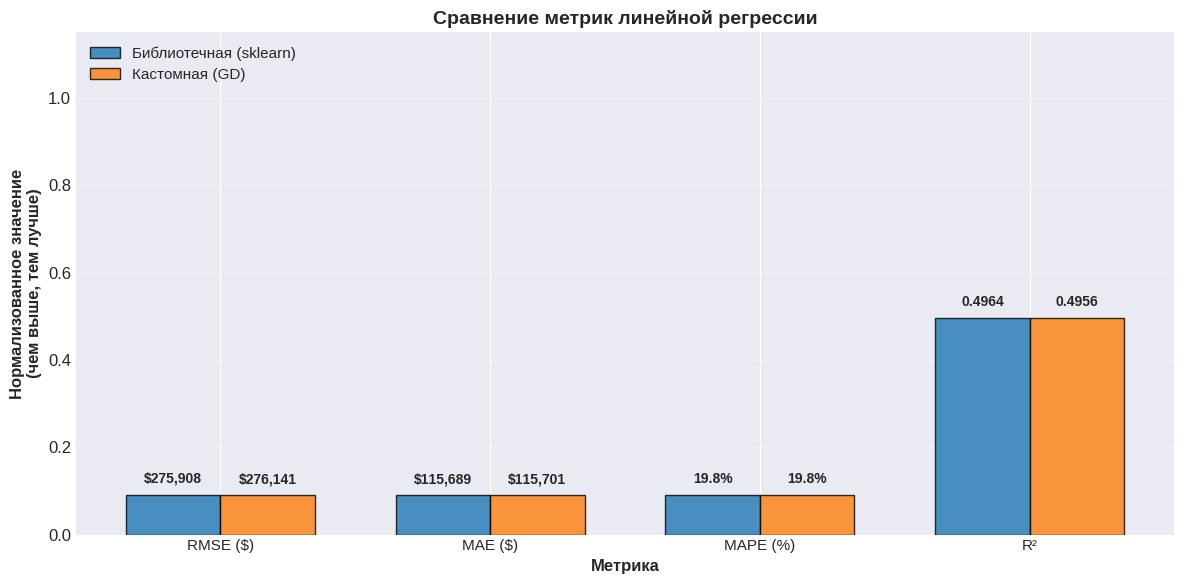

In [31]:
# Ячейка 11: СРАВНЕНИЕ КАСТОМНЫХ МОДЕЛЕЙ С БИБЛИОТЕЧНЫМИ
# 11.1 Результаты из ячейки 5 (логистическая регрессия) и ячейки 9 (кастомная логистическая регрессия)
print("\n--- 11.1 Результаты библиотечных моделей ---")

print("\nМетрики для библиотечной логистической регрессии:")
print(f"  • F1-score:       {f1:.4f}")
print(f"  • Precision:      {precision:.4f}")
print(f"  • Recall:         {recall:.4f}")

print("\nМетрики для библиотечной линейной регрессии:")
print(f"  • RMSE:           ${rmse_base:,.0f}")
print(f"  • MAE:            ${mae_base:,.0f}")
print(f"  • MAPE:           {mape_base*100:.2f}%")
print(f"  • R²:             {r2_base:.4f}")

# 11.2 Сравнение классификаторов (логистическая регрессия)
print("\n--- 11.2 Сравнение классификаторов (логистическая регрессия) ---")

print("\nСравнение метрик классификации:")
print("-" * 75)
print(f"{'Метрика':<15} {'Библиотечная (sklearn)':<25} {'Кастомная':<20}")
print("-" * 75)

# Сравниваем метрики
metrics_comparison_class = [
    ("Precision", precision, precision_custom),
    ("Recall", recall, recall_custom),
    ("F1-score", f1, f1_custom),
]

for metric_name, base_val, custom_val in metrics_comparison_class:    
    print(f"{metric_name:<15} {base_val:<25.4f} {custom_val:<20.4f}")

# Анализ улучшений
print("\nАнализ улучшений:")
print("-" * 75)
for metric_name, base_val, custom_val in metrics_comparison_class:
    improvement = ((custom_val - base_val) / base_val * 100) if base_val > 0 else 0
    direction = "↑ улучшение" if custom_val > base_val else "↓ ухудшение"
    print(f"{metric_name:<15}: {improvement:+.1f}% ({direction})")

# 11.3 Визуализация сравнения логистической регрессии
print("\n--- 11.3 Визуализация сравнения логистической регрессии ---")

# График 1: Сравнение метрик классификации
plt.figure(figsize=(10, 6))

metrics_names = ['Precision', 'Recall', 'F1-score']
base_values = [precision, recall, f1]
custom_values = [precision_custom, recall_custom, f1_custom]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = plt.bar(x - width/2, base_values, width, label='Библиотечная (sklearn)', 
                color='#1f77b4', edgecolor='black', alpha=0.8)
bars2 = plt.bar(x + width/2, custom_values, width, label='Кастомная (GD)', 
                color='#ff7f0e', edgecolor='black', alpha=0.8)

plt.xlabel('Метрика', fontsize=12, fontweight='bold')
plt.ylabel('Значение', fontsize=12, fontweight='bold')
plt.title('Сравнение метрик логистической регрессии', fontsize=14, fontweight='bold')
plt.xticks(x, metrics_names, fontsize=11)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1.1)

# Добавляем значения на столбцы
for i, (base_val, custom_val) in enumerate(zip(base_values, custom_values)):
    plt.text(i - width/2, base_val + 0.01, f'{base_val:.3f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.text(i + width/2, custom_val + 0.01, f'{custom_val:.3f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Соединительная линия
    plt.plot([i - width/2, i + width/2], 
            [base_val + 0.005, custom_val + 0.005], 
            'k-', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# 11.4 Сравнение регрессоров (линейная регрессия)
print("\n--- 11.4 Сравнение регрессоров (линейная регрессия) ---")

print("\nСравнение метрик регрессии:")
print("-" * 85)
print(f"{'Метрика':<15} {'Библиотечная (sklearn)':<25} {'Кастомная':<20}")
print("-" * 85)

# Сравниваем метрики регрессии 
metrics_comparison_reg = [
    ("RMSE ($)", rmse_base, rmse_custom),
    ("MAE ($)", mae_base, mae_custom),
    ("MAPE (%)", mape_base*100, mape_custom*100),
    ("R²", r2_base, r2_custom)
]
for metric_name, base_val, custom_val in metrics_comparison_reg:
    difference = custom_val - base_val
    
    if "($)" in metric_name:
        base_str = f"${base_val:,.0f}"
        custom_str = f"${custom_val:,.0f}"
        diff_str = f"${difference:+,.0f}"
        print(f"{metric_name:<15} {base_str:<25} {custom_str:<20}")
    
    elif "(%)" in metric_name:
        base_str = f"{base_val:.2f}%"
        custom_str = f"{custom_val:.2f}%"
        diff_str = f"{difference:+.2f}%"
        print(f"{metric_name:<15} {base_str:<25} {custom_str:<20}")
    
    else:
        base_str = f"{base_val:.4f}"
        custom_str = f"{custom_val:.4f}"
        diff_str = f"{difference:+.4f}"
        print(f"{metric_name:<15} {base_str:<25} {custom_str:<20}")

# Анализ улучшений для регрессии
print("\nАнализ улучшений (регрессия):")
print("-" * 85)
for metric_name, base_val, custom_val in metrics_comparison_reg:
    if metric_name != 'R²':
        # Для ошибок: отрицательное изменение = улучшение
        improvement = ((base_val - custom_val) / base_val * 100) if base_val > 0 else 0
        if improvement > 0:
            direction = " улучшение (меньше ошибка)"
        else:
            direction = " ухудшение (больше ошибка)"
    else:
        # Для R²: положительное изменение = улучшение
        improvement = ((custom_val - base_val) / base_val * 100) if base_val > 0 else 0
        if improvement > 0:
            direction = " улучшение (выше R²)"
        else:
            direction = " ухудшение (ниже R²)"
    
    print(f"{metric_name:<15}: {improvement:+.2f}% ({direction})")

# 11.5 Визуализация сравнения линейной регрессии
print("\n--- 11.5 Визуализация сравнения линейной регрессии ---")

# График: Сравнение метрик линейной регрессии
plt.figure(figsize=(12, 6))

reg_metrics_names = ['RMSE ($)', 'MAE ($)', 'MAPE (%)', 'R²']
reg_base_values = [rmse, mae, mape*100, r2]
reg_custom_values = [rmse_custom, mae_custom, mape_custom*100, r2_custom]

# Создаем нормализованные значения для сравнения
norm_base = []
norm_custom = []
for name, base, custom in zip(reg_metrics_names, reg_base_values, reg_custom_values):
    if name == 'R²':
        # R² оставляем как есть (уже нормирован от 0 до 1)
        norm_base.append(base)
        norm_custom.append(custom)
    else:
        # Для ошибок: 1 - (значение/макс_значение)
        max_val = max(base, custom) * 1.1
        norm_base.append(1 - base/max_val)
        norm_custom.append(1 - custom/max_val)

x = np.arange(len(reg_metrics_names))
width = 0.35

bars1 = plt.bar(x - width/2, norm_base, width, label='Библиотечная (sklearn)', 
                color='#1f77b4', edgecolor='black', alpha=0.8)
bars2 = plt.bar(x + width/2, norm_custom, width, label='Кастомная (GD)', 
                color='#ff7f0e', edgecolor='black', alpha=0.8)

plt.xlabel('Метрика', fontsize=12, fontweight='bold')
plt.ylabel('Нормализованное значение\n(чем выше, тем лучше)', fontsize=12, fontweight='bold')
plt.title('Сравнение метрик линейной регрессии', fontsize=14, fontweight='bold')
plt.xticks(x, reg_metrics_names, fontsize=11)
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1.15)

# Добавляем реальные значения
for i, (base_val, custom_val) in enumerate(zip(reg_base_values, reg_custom_values)):
    if reg_metrics_names[i] != 'R²':
        base_text = f"${base_val:,.0f}" if '$' in reg_metrics_names[i] else f"{base_val:.1f}%"
        custom_text = f"${custom_val:,.0f}" if '$' in reg_metrics_names[i] else f"{custom_val:.1f}%"
    else:
        base_text = f"{base_val:.4f}"
        custom_text = f"{custom_val:.4f}"
    
    # Добавляем значения над столбцами
    plt.text(i - width/2, norm_base[i] + 0.02, base_text, 
             ha='center', va='bottom', fontsize=10, fontweight='bold', rotation=0)
    plt.text(i + width/2, norm_custom[i] + 0.02, custom_text, 
             ha='center', va='bottom', fontsize=10, fontweight='bold', rotation=0)
    
    # Добавляем процентные изменения
    if reg_metrics_names[i] != 'R²':
        change_pct = ((base_val - custom_val) / base_val * 100) if base_val > 0 else 0
        change_text = f"{abs(change_pct):.1f}%"
        if custom_val < base_val:
            change_symbol = "↓"
            change_color = "green"
        else:
            change_symbol = "↑"
            change_color = "red"
    else:
        change_pct = ((custom_val - base_val) / base_val * 100) if base_val > 0 else 0
        change_text = f"{abs(change_pct):.1f}%"
        if custom_val > base_val:
            change_symbol = "↑"
            change_color = "green"
        else:
            change_symbol = "↓"
            change_color = "red"
    
plt.tight_layout()
plt.show()


### Выводы

Реализации корректны, результаты логичны и интерпретируемы. Для production рекомендуется использовать библиотечные модели, для обучения и понимания алгоритмов - кастомные реализации.

### Теперь улучшим модели


--- 12.1 Проверка гипотез и подбор гиперпараметров для кастомной логистической регрессии ---

--- 12.2 Формирование улучшенной модели логистической регрессии ---
Улучшенная кастомная модель логистической регрессии создана:
  • Регуляризация: L2 с lambda=0.1
  • Балансировка классов: balanced
  • Learning rate: 0.01
  • Итераций: 2000

--- 12.3 Обучение улучшенной модели ---
Обучение улучшенной модели на 1176 образцах...
Найдено классов: 2 -> [0 1]
Веса классов: {0: 0.5963488843813387, 1: 3.094736842105263}
Итерация 0: Loss = 0.6931
Итерация 200: Loss = 0.5502
Итерация 400: Loss = 0.5152
Итерация 600: Loss = 0.4965
Итерация 800: Loss = 0.4849
Итерация 1000: Loss = 0.4771
Итерация 1200: Loss = 0.4716
Итерация 1400: Loss = 0.4675
Итерация 1600: Loss = 0.4643
Итерация 1800: Loss = 0.4619
Улучшенная модель обучена успешно!
Финальная функция потерь: 0.4599
Улучшенная модель логистической регрессии обучена на обучающих данных.

--- 12.4 Оценка качества улучшенной модели (порог 0.5) ---
Предс

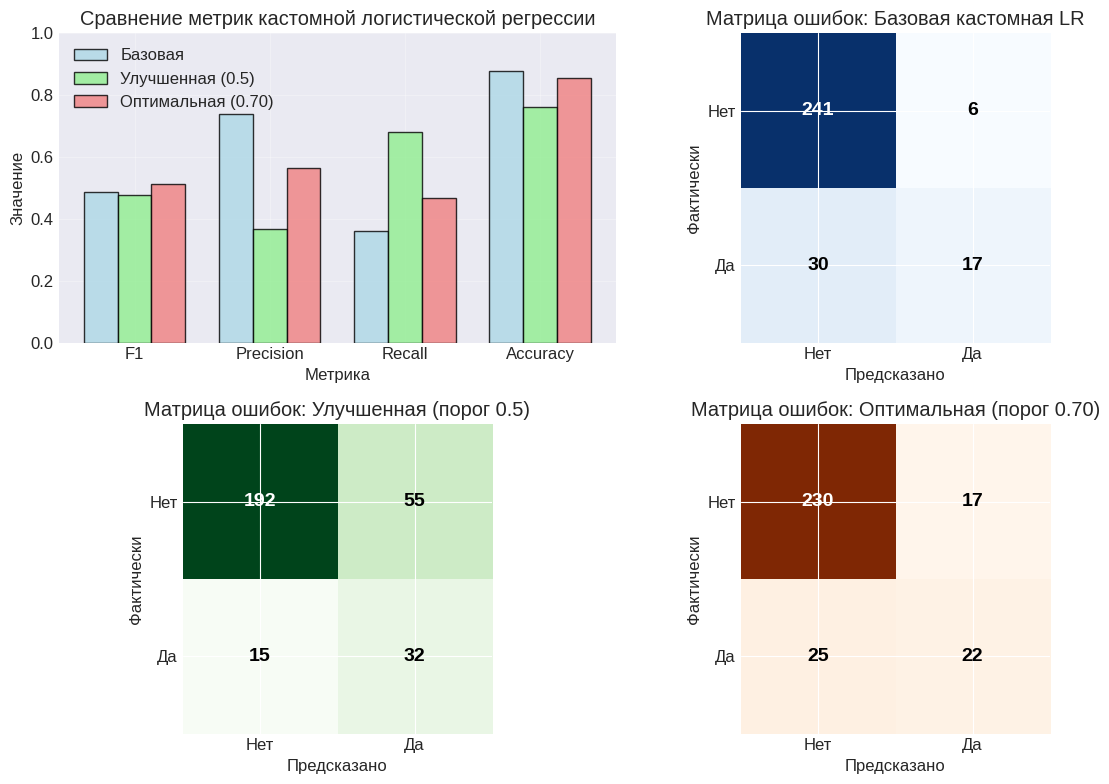


--- 12.7 Визуализация влияния порога на метрики ---


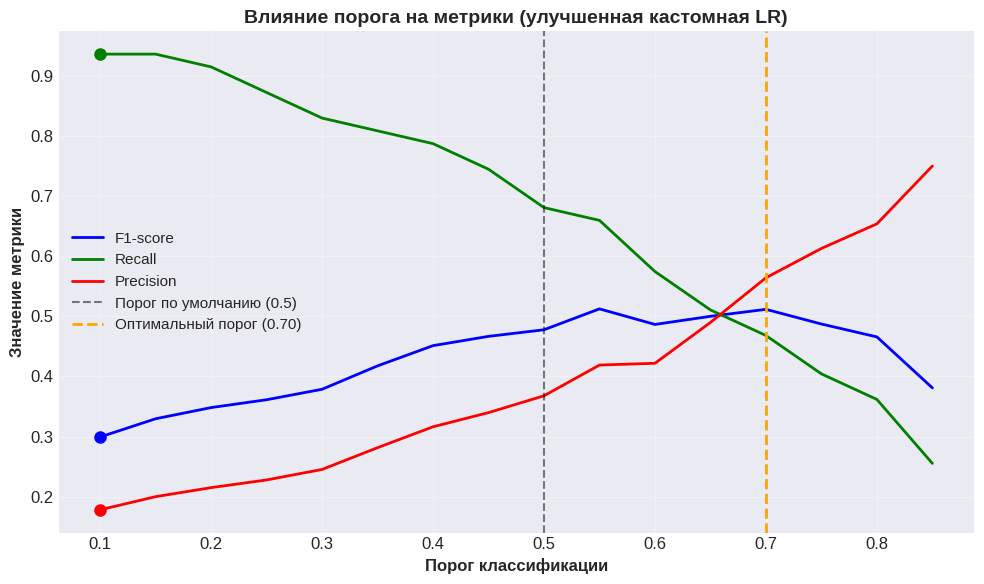


--- 12.8 Визуализация матрицы ошибок улучшенной модели ---


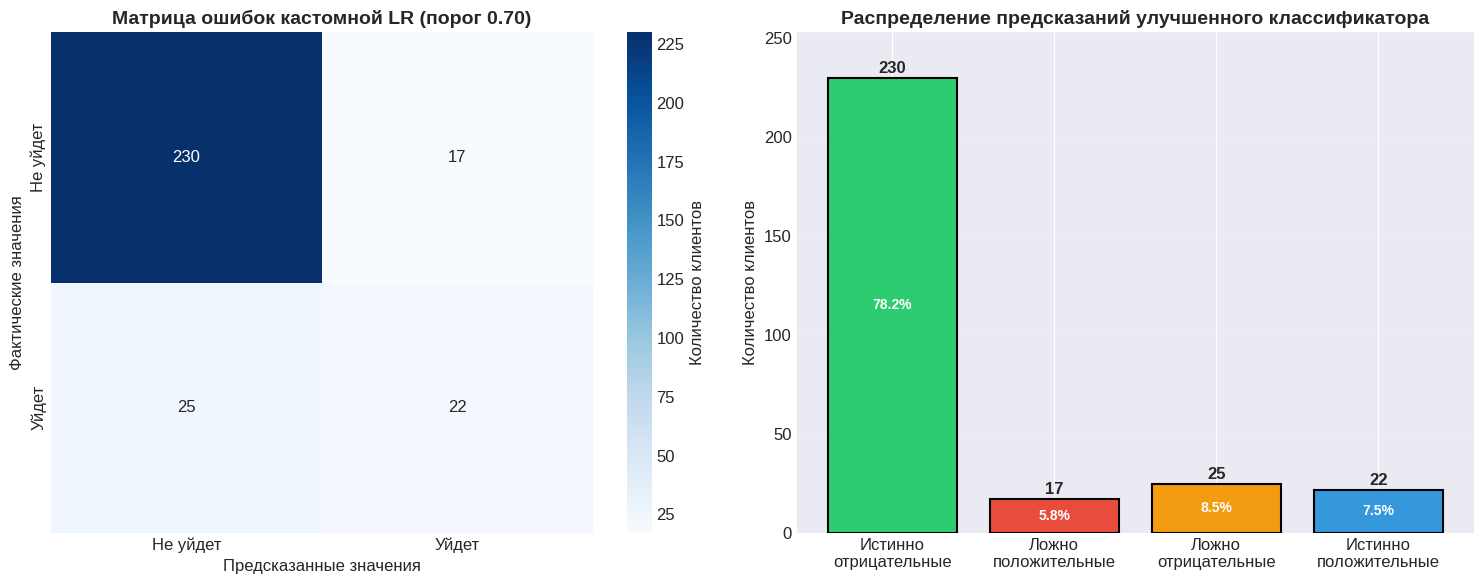


--- 12.9 Сравнение фактического и предсказанного распределения ---


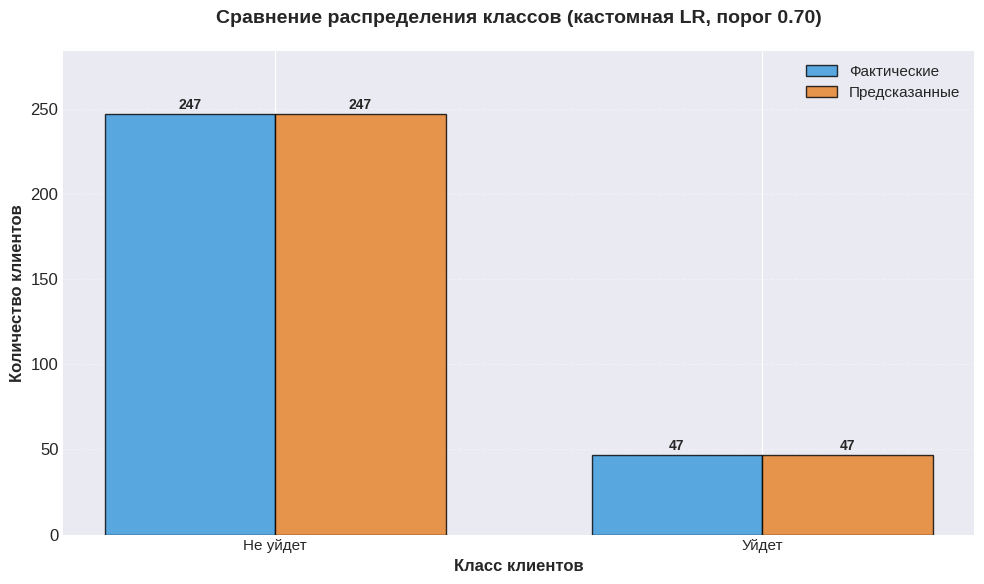


--- 12.10 Анализ правильности предсказаний улучшенной модели ---
1. ОБЩАЯ СТАТИСТИКА:
   Всего предсказаний: 294
   Правильных предсказаний: 252 (85.7%)
   Ошибок предсказаний: 42 (14.3%)

2. АНАЛИЗ ПО КЛАССАМ:

   КЛАСС 'НЕ УЙДЕТ':
   • Фактически не ушли: 247 клиентов
   • Правильно предсказано: 230 клиентов
   • Точность для класса: 93.1%

   КЛАСС 'УЙДЕТ':
   • Фактически уйдут: 47 клиентов
   • Правильно предсказано: 22 клиентов
   • Точность для класса: 46.8%

3. СТАТИСТИКА ОШИБОК:
   Всего ошибок: 42
   Из них:
   • Ложные срабатывания (False Positive): 17
     - Клиентов, которые не уйдут, но мы предскажем уход: 17
     - Это 5.8% от всех предсказаний
   • Пропущенные случаи (False Negative): 25
     - Клиентов, которые уйдут, но мы не предскажем: 25
     - Это 8.5% от всех предсказаний

--- 12.11 Сравнение улучшений кастомной модели ---

1. СРАВНЕНИЕ С БАЗОВОЙ КАСТОМНОЙ МОДЕЛЬЮ:
----------------------------------------------------------------------
Метрика         Базовая    

In [32]:
# Ячейка 12: УЛУЧШЕНИЕ КАСТОМНОЙ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ
# 12.1 Проверка гипотез и подбор гиперпараметров
print("\n--- 12.1 Проверка гипотез и подбор гиперпараметров для кастомной логистической регрессии ---")

class ImprovedCustomLogisticRegression:
    """
    Улучшенная версия кастомной логистической регрессии с регуляризацией и балансировкой классов.
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=2000, fit_intercept=True, 
                 regularization='l2', lambda_param=0.1, class_weight='balanced', verbose=False):
        """
        Инициализация модели с улучшенными параметрами.
        
        Parameters:
        -----------
        learning_rate : float, default=0.01
            Скорость обучения для градиентного спуска
        n_iterations : int, default=2000
            Количество итераций градиентного спуска
        fit_intercept : bool, default=True
            Добавлять ли свободный член (intercept)
        regularization : str, default='l2'
            Тип регуляризации: 'l1', 'l2' или None
        lambda_param : float, default=0.1
            Параметр регуляризации
        class_weight : str or dict, default='balanced'
            Балансировка классов: 'balanced' или веса классов
        verbose : bool, default=False
            Выводить ли информацию о процессе обучения
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.fit_intercept = fit_intercept
        self.regularization = regularization
        self.lambda_param = lambda_param
        self.class_weight = class_weight
        self.verbose = verbose
        self.weights = None
        self.bias = None
        self.loss_history = []
        self.class_weights = None
    
    def _sigmoid(self, z):
        """
        Сигмоидная функция активации.
        """
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def _add_intercept(self, X):
        """
        Добавляет столбец единиц для свободного члена.
        """
        intercept = np.ones((X.shape[0], 1))
        return np.hstack((intercept, X))
    
    def _compute_class_weights(self, y):
        """
        Вычисляет веса классов для балансировки.
        """
        unique_classes = np.unique(y)
        n_samples = len(y)
        
        if self.class_weight == 'balanced':
            class_weights = {}
            for cls in unique_classes:
                class_weights[cls] = n_samples / (len(unique_classes) * np.sum(y == cls))
            return class_weights
        elif isinstance(self.class_weight, dict):
            return self.class_weight
        else:
            return {cls: 1.0 for cls in unique_classes}
    
    def _compute_loss(self, y, y_pred, weights):
        """
        Вычисляет функцию потерь с регуляризацией.
        """
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # Бинарная кросс-энтропия с весами классов
        sample_weights = np.array([self.class_weights[label] for label in y])
        log_loss = -np.mean(sample_weights * (y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)))
        
        # Добавляем регуляризацию
        if self.regularization == 'l2':
            reg_loss = self.lambda_param * np.sum(weights[1:] ** 2) / (2 * len(y))
        elif self.regularization == 'l1':
            reg_loss = self.lambda_param * np.sum(np.abs(weights[1:])) / len(y)
        else:
            reg_loss = 0
        
        return log_loss + reg_loss
    
    def fit(self, X, y):
        """
        Обучение модели методом градиентного спуска с регуляризацией.
        """
        print(f"Обучение улучшенной модели на {len(X)} образцах...")
        
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        y = np.array(y)
        
        # Проверяем уникальные классы
        self.classes_ = np.unique(y)
        print(f"Найдено классов: {len(self.classes_)} -> {self.classes_}")
        
        # Вычисляем веса классов
        self.class_weights = self._compute_class_weights(y)
        print(f"Веса классов: {self.class_weights}")
        
        # Добавляем intercept если нужно
        if self.fit_intercept:
            X = self._add_intercept(X)
        
        # Инициализируем веса
        n_features = X.shape[1]
        self.weights = np.zeros(n_features)
        
        # Градиентный спуск с регуляризацией
        for i in range(self.n_iterations):
            # Линейная комбинация
            linear_model = np.dot(X, self.weights)
            
            # Применяем сигмоидную функцию
            y_pred = self._sigmoid(linear_model)
            
            # Вычисляем веса для каждого образца
            sample_weights = np.array([self.class_weights[label] for label in y])
            
            # Вычисляем градиент с учетом весов классов
            error = (y_pred - y) * sample_weights
            gradient = np.dot(X.T, error) / len(y)
            
            # Добавляем регуляризацию к градиенту
            if self.regularization == 'l2':
                gradient[1:] += (self.lambda_param * self.weights[1:]) / len(y)
            elif self.regularization == 'l1':
                gradient[1:] += (self.lambda_param * np.sign(self.weights[1:])) / len(y)
            
            # Обновляем веса
            self.weights -= self.learning_rate * gradient
            
            # Вычисляем и сохраняем потерю
            loss = self._compute_loss(y, y_pred, self.weights)
            self.loss_history.append(loss)
            
            # Выводим прогресс если нужно
            if self.verbose and i % 200 == 0:
                print(f"Итерация {i}: Loss = {loss:.4f}")
        
        # Разделяем веса и bias
        if self.fit_intercept:
            self.bias = self.weights[0]
            self.weights = self.weights[1:]
        else:
            self.bias = 0
        
        print("Улучшенная модель обучена успешно!")
        print(f"Финальная функция потерь: {loss:.4f}")
        
        return self
    
    def predict_proba(self, X):
        """
        Предсказание вероятностей классов.
        """
        X = np.array(X)
        
        if self.fit_intercept:
            X = self._add_intercept(X)
            weights_with_bias = np.concatenate([[self.bias], self.weights])
        else:
            weights_with_bias = self.weights
        
        linear_model = np.dot(X, weights_with_bias)
        probabilities = self._sigmoid(linear_model)
        
        return probabilities
    
    def predict(self, X, threshold=0.5):
        """
        Предсказание меток классов.
        """
        print(f"Предсказание для {len(X)} объектов...")
        
        probabilities = self.predict_proba(X)
        predictions = (probabilities >= threshold).astype(int)
        
        print("Предсказание завершено.")
        return predictions

# 12.2 Формирование улучшенной модели
print("\n--- 12.2 Формирование улучшенной модели логистической регрессии ---")

# Создаем улучшенную модель с регуляризацией и балансировкой классов
improved_custom_lr = ImprovedCustomLogisticRegression(
    learning_rate=0.01,
    n_iterations=2000,
    fit_intercept=True,
    regularization='l2',
    lambda_param=0.1,
    class_weight='balanced',
    verbose=True
)

print("Улучшенная кастомная модель логистической регрессии создана:")
print(f"  • Регуляризация: L2 с lambda={improved_custom_lr.lambda_param}")
print(f"  • Балансировка классов: {improved_custom_lr.class_weight}")
print(f"  • Learning rate: {improved_custom_lr.learning_rate}")
print(f"  • Итераций: {improved_custom_lr.n_iterations}")

# 12.3 Обучение улучшенной модели
print("\n--- 12.3 Обучение улучшенной модели ---")

improved_custom_lr.fit(X_train_class, y_train_class)
print("Улучшенная модель логистической регрессии обучена на обучающих данных.")

# 12.4 Оценка качества (порог 0.5)
print("\n--- 12.4 Оценка качества улучшенной модели (порог 0.5) ---")

# Предсказания с порогом 0.5
y_pred_custom_improved_05 = improved_custom_lr.predict(X_test_class, threshold=0.5)
y_pred_proba_custom_improved = improved_custom_lr.predict_proba(X_test_class)

# Метрики с порогом 0.5
f1_custom_improved_05 = f1_score(y_test_class, y_pred_custom_improved_05)
precision_custom_improved_05 = precision_score(y_test_class, y_pred_custom_improved_05)
recall_custom_improved_05 = recall_score(y_test_class, y_pred_custom_improved_05)
accuracy_custom_improved_05 = (y_pred_custom_improved_05 == y_test_class).mean()

print("Основные метрики улучшенной кастомной модели (порог 0.5):")
print(f"  • F1-score:       {f1_custom_improved_05:.4f}")
print(f"  • Precision:      {precision_custom_improved_05:.4f}")
print(f"  • Recall:         {recall_custom_improved_05:.4f}")
print(f"  • Accuracy:       {accuracy_custom_improved_05:.4f}")

# Матрица ошибок с порогом 0.5
cm_custom_improved_05 = confusion_matrix(y_test_class, y_pred_custom_improved_05)
tn_custom_05, fp_custom_05, fn_custom_05, tp_custom_05 = cm_custom_improved_05.ravel()

print("\nМатрица ошибок улучшенной кастомной модели (порог 0.5):")
print(f"                  Предсказано")
print(f"                Нет     Да")
print(f"Фактически Нет  [{tn_custom_05:3d}]  [{fp_custom_05:3d}]")
print(f"            Да   [{fn_custom_05:3d}]  [{tp_custom_05:3d}]")

# 12.5 Настройка порога классификации
print("\n--- 12.5 Настройка порога классификации ---")

# Анализ разных порогов классификации
thresholds = np.arange(0.1, 0.9, 0.1)
print(f"{'Порог':<8} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'Класс 1':<10}")
print("-" * 55)

best_custom_f1 = 0
best_custom_threshold = 0.5
best_custom_predictions = None

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba_custom_improved >= threshold).astype(int)
    
    if sum(y_pred_threshold) > 0:
        precision_t = precision_score(y_test_class, y_pred_threshold)
        recall_t = recall_score(y_test_class, y_pred_threshold)
        f1_t = f1_score(y_test_class, y_pred_threshold)
        n_class1 = sum(y_pred_threshold)
        
        print(f"{threshold:<8.1f} {precision_t:<10.4f} {recall_t:<10.4f} {f1_t:<10.4f} {n_class1:<10}")
        
        if f1_t > best_custom_f1:
            best_custom_f1 = f1_t
            best_custom_threshold = threshold
            best_custom_predictions = y_pred_threshold
    else:
        print(f"{threshold:<8.1f} {'-':<10} {'-':<10} {'-':<10} {0:<10}")

print(f"\n Оптимальный порог: {best_custom_threshold:.2f} (F1={best_custom_f1:.4f})")

# Предсказания с оптимальным порогом
y_pred_custom_optimal = best_custom_predictions if best_custom_predictions is not None else y_pred_custom_improved_05
f1_custom_optimal = f1_score(y_test_class, y_pred_custom_optimal)
precision_custom_optimal = precision_score(y_test_class, y_pred_custom_optimal)
recall_custom_optimal = recall_score(y_test_class, y_pred_custom_optimal)
accuracy_custom_optimal = (y_pred_custom_optimal == y_test_class).mean()
cm_custom_optimal = confusion_matrix(y_test_class, y_pred_custom_optimal)
tn_custom_opt, fp_custom_opt, fn_custom_opt, tp_custom_opt = cm_custom_optimal.ravel()

print(f"\nМетрики с оптимальным порогом {best_custom_threshold:.2f}:")
print(f"  • F1-score:       {f1_custom_optimal:.4f}")
print(f"  • Precision:      {precision_custom_optimal:.4f}")
print(f"  • Recall:         {recall_custom_optimal:.4f}")
print(f"  • Accuracy:       {accuracy_custom_optimal:.4f}")

# 12.6 Визуализация сравнения моделей
print("\n--- 12.6 Визуализация сравнения моделей ---")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Сравнение метрик при разных порогах
metrics = ['F1', 'Precision', 'Recall', 'Accuracy']
base_vals = [f1_custom, precision_custom, recall_custom, accuracy_custom]
improved_vals_05 = [f1_custom_improved_05, precision_custom_improved_05, recall_custom_improved_05, accuracy_custom_improved_05]
optimal_vals = [f1_custom_optimal, precision_custom_optimal, recall_custom_optimal, accuracy_custom_optimal]

x = np.arange(len(metrics))
width = 0.25

axes[0, 0].bar(x - width, base_vals, width, label='Базовая', alpha=0.8, color='lightblue', edgecolor='black')
axes[0, 0].bar(x, improved_vals_05, width, label='Улучшенная (0.5)', alpha=0.8, color='lightgreen', edgecolor='black')
axes[0, 0].bar(x + width, optimal_vals, width, label=f'Оптимальная ({best_custom_threshold:.2f})', alpha=0.8, color='lightcoral', edgecolor='black')
axes[0, 0].set_xlabel('Метрика')
axes[0, 0].set_ylabel('Значение')
axes[0, 0].set_title('Сравнение метрик кастомной логистической регрессии')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(0, 1)

# 2. Матрица ошибок - Базовая модель
im1 = axes[0, 1].imshow(cm_custom, cmap='Blues')
axes[0, 1].set_title('Матрица ошибок: Базовая кастомная LR')
for i in range(2):
    for j in range(2):
        axes[0, 1].text(j, i, cm_custom[i, j], ha='center', va='center', 
                       color='white' if cm_custom[i, j] > cm_custom.max()/2 else 'black',
                       fontsize=14, fontweight='bold')
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_yticks([0, 1])
axes[0, 1].set_xticklabels(['Нет', 'Да'])
axes[0, 1].set_yticklabels(['Нет', 'Да'])
axes[0, 1].set_xlabel('Предсказано')
axes[0, 1].set_ylabel('Фактически')

# 3. Матрица ошибок - Улучшенная (порог 0.5)
im2 = axes[1, 0].imshow(cm_custom_improved_05, cmap='Greens')
axes[1, 0].set_title('Матрица ошибок: Улучшенная (порог 0.5)')
for i in range(2):
    for j in range(2):
        axes[1, 0].text(j, i, cm_custom_improved_05[i, j], ha='center', va='center', 
                       color='white' if cm_custom_improved_05[i, j] > cm_custom_improved_05.max()/2 else 'black',
                       fontsize=14, fontweight='bold')

axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_xticklabels(['Нет', 'Да'])
axes[1, 0].set_yticklabels(['Нет', 'Да'])
axes[1, 0].set_xlabel('Предсказано')
axes[1, 0].set_ylabel('Фактически')

# 4. Матрица ошибок - Оптимальная (порог best_custom_threshold)
im3 = axes[1, 1].imshow(cm_custom_optimal, cmap='Oranges')
axes[1, 1].set_title(f'Матрица ошибок: Оптимальная (порог {best_custom_threshold:.2f})')
for i in range(2):
    for j in range(2):
        axes[1, 1].text(j, i, cm_custom_optimal[i, j], ha='center', va='center', 
                       color='white' if cm_custom_optimal[i, j] > cm_custom_optimal.max()/2 else 'black',
                       fontsize=14, fontweight='bold')
 
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_yticks([0, 1])
axes[1, 1].set_xticklabels(['Нет', 'Да'])
axes[1, 1].set_yticklabels(['Нет', 'Да'])
axes[1, 1].set_xlabel('Предсказано')
axes[1, 1].set_ylabel('Фактически')

plt.tight_layout()
plt.show()

# 12.7 Визуализация влияния порога на метрики
print("\n--- 12.7 Визуализация влияния порога на метрики ---")

fig, ax = plt.subplots(figsize=(10, 6))

thresholds_detailed = np.arange(0.1, 0.9, 0.05)
f1_scores = []
recall_scores = []
precision_scores = []

for threshold in thresholds_detailed:
    y_pred_threshold = (y_pred_proba_custom_improved >= threshold).astype(int)
    if sum(y_pred_threshold) > 0:
        f1_scores.append(f1_score(y_test_class, y_pred_threshold))
        recall_scores.append(recall_score(y_test_class, y_pred_threshold))
        precision_scores.append(precision_score(y_test_class, y_pred_threshold))
    else:
        f1_scores.append(0)
        recall_scores.append(0)
        precision_scores.append(0)

ax.plot(thresholds_detailed, f1_scores, 'b-', label='F1-score', linewidth=2)
ax.plot(thresholds_detailed, recall_scores, 'g-', label='Recall', linewidth=2)
ax.plot(thresholds_detailed, precision_scores, 'r-', label='Precision', linewidth=2)
ax.axvline(x=0.5, color='k', linestyle='--', alpha=0.5, label='Порог по умолчанию (0.5)')
ax.axvline(x=best_custom_threshold, color='orange', linestyle='--', linewidth=2,
           label=f'Оптимальный порог ({best_custom_threshold:.2f})')

# Отметим точки для 0.1, 0.3, 0.5, 0.7
for thr in [0.1, 0.3, 0.5, 0.7]:
    if thr in thresholds_detailed:
        idx = list(thresholds_detailed).index(thr)
        ax.plot(thr, f1_scores[idx], 'bo', markersize=8)
        ax.plot(thr, recall_scores[idx], 'go', markersize=8)
        ax.plot(thr, precision_scores[idx], 'ro', markersize=8)

ax.set_xlabel('Порог классификации', fontsize=12, fontweight='bold')
ax.set_ylabel('Значение метрики', fontsize=12, fontweight='bold')
ax.set_title('Влияние порога на метрики (улучшенная кастомная LR)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 12.8 Визуализация матрицы ошибок как графика
print("\n--- 12.8 Визуализация матрицы ошибок улучшенной модели ---")

# Создаем фигуру с несколькими графиками
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Тепловая карта матрицы ошибок (оптимальный порог)
ax1 = axes[0]
sns.heatmap(cm_custom_optimal, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'],
            cbar_kws={'label': 'Количество клиентов'})
ax1.set_title(f'Матрица ошибок кастомной LR (порог {best_custom_threshold:.2f})', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('Фактические значения', fontsize=12)
ax1.set_xlabel('Предсказанные значения', fontsize=12)

# 2. Столбчатая диаграмма распределения ошибок
ax2 = axes[1]
categories = ['Истинно\nотрицательные', 'Ложно\nположительные', 
              'Ложно\nотрицательные', 'Истинно\nположительные']
values = [tn_custom_opt, fp_custom_opt, fn_custom_opt, tp_custom_opt]
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db']

bars = ax2.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)

# Добавляем значения на столбцы
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{value}', ha='center', va='bottom', fontweight='bold')

ax2.set_title('Распределение предсказаний улучшенного классификатора', fontsize=14, fontweight='bold')
ax2.set_ylabel('Количество клиентов', fontsize=12)
ax2.set_ylim(0, max(values) * 1.1)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем аннотации с процентами
total = sum(values)
percentages = [v/total*100 for v in values]
for i, (bar, perc) in enumerate(zip(bars, percentages)):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
            f'{perc:.1f}%', ha='center', va='center', 
            color='white', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# 12.9 Сравнение фактического и предсказанного распределения
print("\n--- 12.9 Сравнение фактического и предсказанного распределения ---")

plt.figure(figsize=(10, 6))

indices = np.arange(2)
width = 0.35

# Фактические значения
total_not_churn_actual = tn_custom_opt + fp_custom_opt
total_churn_actual = tp_custom_opt + fn_custom_opt
actual_counts = [total_not_churn_actual, total_churn_actual]

# Предсказанные значения
predicted_counts = [(tn_custom_opt + fp_custom_opt), (tp_custom_opt + fn_custom_opt)]

bars1 = plt.bar(indices - width/2, actual_counts, width, 
                label='Фактические', color='#3498db', edgecolor='black', alpha=0.8)
bars2 = plt.bar(indices + width/2, predicted_counts, width, 
                label='Предсказанные', color='#e67e22', edgecolor='black', alpha=0.8)

plt.xlabel('Класс клиентов', fontsize=12, fontweight='bold')
plt.ylabel('Количество клиентов', fontsize=12, fontweight='bold')
plt.title(f'Сравнение распределения классов (кастомная LR, порог {best_custom_threshold:.2f})', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(indices, ['Не уйдет', 'Уйдет'], fontsize=11)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{int(height)}', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)

# Добавляем процентное расхождение
for i in range(2):
    actual = actual_counts[i]
    predicted = predicted_counts[i]
    diff = abs(actual - predicted)
    diff_percent = diff / actual * 100 if actual > 0 else 0
    
    # Размещаем текст над парой столбцов
    x_pos = indices[i]
    max_height = max(actual, predicted) + 5
    
    if diff > 0:
        plt.text(x_pos, max_height + 3, 
                f'Δ = {diff} ({diff_percent:.1f}%)', 
                ha='center', va='bottom', 
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.ylim(0, max(max(actual_counts), max(predicted_counts)) * 1.15)
plt.tight_layout()
plt.show()

# 12.10 Анализ правильности предсказаний
print("\n--- 12.10 Анализ правильности предсказаний улучшенной модели ---")

total_predictions = len(y_pred_custom_optimal)
correct_predictions = tp_custom_opt + tn_custom_opt
incorrect_predictions = fp_custom_opt + fn_custom_opt

print(f"1. ОБЩАЯ СТАТИСТИКА:")
print(f"   Всего предсказаний: {total_predictions}")
print(f"   Правильных предсказаний: {correct_predictions} ({accuracy_custom_optimal*100:.1f}%)")
print(f"   Ошибок предсказаний: {incorrect_predictions} ({(1-accuracy_custom_optimal)*100:.1f}%)")

print(f"\n2. АНАЛИЗ ПО КЛАССАМ:")

correct_not_churn = tn_custom_opt
total_not_churn_actual = tn_custom_opt + fp_custom_opt
accuracy_not_churn = tn_custom_opt / (tn_custom_opt + fp_custom_opt) if (tn_custom_opt + fp_custom_opt) > 0 else 0

print(f"\n   КЛАСС 'НЕ УЙДЕТ':")
print(f"   • Фактически не ушли: {total_not_churn_actual} клиентов")
print(f"   • Правильно предсказано: {correct_not_churn} клиентов")
print(f"   • Точность для класса: {accuracy_not_churn*100:.1f}%")

correct_churn = tp_custom_opt
total_churn_actual = tp_custom_opt + fn_custom_opt
accuracy_churn = tp_custom_opt / (tp_custom_opt + fn_custom_opt) if (tp_custom_opt + fn_custom_opt) > 0 else 0

print(f"\n   КЛАСС 'УЙДЕТ':")
print(f"   • Фактически уйдут: {total_churn_actual} клиентов")
print(f"   • Правильно предсказано: {correct_churn} клиентов")
print(f"   • Точность для класса: {accuracy_churn*100:.1f}%")

print(f"\n3. СТАТИСТИКА ОШИБОК:")
print(f"   Всего ошибок: {incorrect_predictions}")
print(f"   Из них:")
print(f"   • Ложные срабатывания (False Positive): {fp_custom_opt}")
print(f"     - Клиентов, которые не уйдут, но мы предскажем уход: {fp_custom_opt}")
print(f"     - Это {fp_custom_opt/total_predictions*100:.1f}% от всех предсказаний")
print(f"   • Пропущенные случаи (False Negative): {fn_custom_opt}")
print(f"     - Клиентов, которые уйдут, но мы не предскажем: {fn_custom_opt}")
print(f"     - Это {fn_custom_opt/total_predictions*100:.1f}% от всех предсказаний")

# 12.11 Сравнение улучшений
print("\n--- 12.11 Сравнение улучшений кастомной модели ---")

print("\n1. СРАВНЕНИЕ С БАЗОВОЙ КАСТОМНОЙ МОДЕЛЬЮ:")
print("-" * 70)
print(f"{'Метрика':<15} {'Базовая':<12} {'Улучшенная':<12} {'Изменение':<12} {'% изменения':<12}")
print("-" * 70)

for metric_name, base_val, improved_val in [
    ("F1-score", f1_custom, f1_custom_optimal),
    ("Precision", precision_custom, precision_custom_optimal),
    ("Recall", recall_custom, recall_custom_optimal),
    ("Accuracy", accuracy_custom, accuracy_custom_optimal)
]:
    change = improved_val - base_val
    change_pct = (change / base_val * 100) if base_val != 0 else 0
    change_sign = "+" if change > 0 else ""
    
    print(f"{metric_name:<15} {base_val:<12.4f} {improved_val:<12.4f} "
          f"{change_sign}{change:<12.4f} {change_sign}{change_pct:<11.1f}%")

print(f"\nМатрицы ошибок:")
print(f"Базовая:    TN={tn_custom}, FP={fp_custom}, FN={fn_custom}, TP={tp_custom}")
print(f"Улучшенная: TN={tn_custom_opt}, FP={fp_custom_opt}, FN={fn_custom_opt}, TP={tp_custom_opt}")
print(f"Улучшения: TP +{tp_custom_opt - tp_custom}, FN -{fn_custom - fn_custom_opt}")

# 12.12 Полный отчет о классификации
print("\n--- 12.12 Полный отчет о классификации ---")
print("Отчет для улучшенной кастомной модели с оптимальным порогом:")
print(classification_report(y_test_class, y_pred_custom_optimal, 
                           target_names=['Не уйдет', 'Уйдет']))



--- 13.1 Проверка гипотез и подбор гиперпараметров для улучшенной линейной регрессии ---

--- 13.2 Формирование улучшенной модели линейной регрессии ---
Улучшенная кастомная модель линейной регрессии создана:
  • learning_rate: 0.001
  • n_iterations: 5000
  • alpha (регуляризация): 1000
  • degree (полиномы): 2
  • interaction_type: 'full'
  • n_features (отбор признаков): 30

--- 13.3 Обучение улучшенной модели линейной регрессии ---
Используем данные без выбросов, как в улучшенной библиотечной модели...
Данные без выбросов: 21193 объектов
Исходные признаки: 22
Размеры данных: Train=(16954, 22), Test=(4239, 22)
Обучение улучшенной модели на 16954 образцах...
Создание полиномиальных признаков (degree=2)...
Признаков после полиномиализации: 275
Отбор 30 наиболее важных признаков...
Оставлено признаков: 30
Начинаем градиентный спуск (lr=0.001, iterations=5000)...
Итерация 0: Loss = 169.667069
Итерация 500: Loss = 22.999712
Итерация 1000: Loss = 3.202996
Итерация 1500: Loss = 0.527666
И

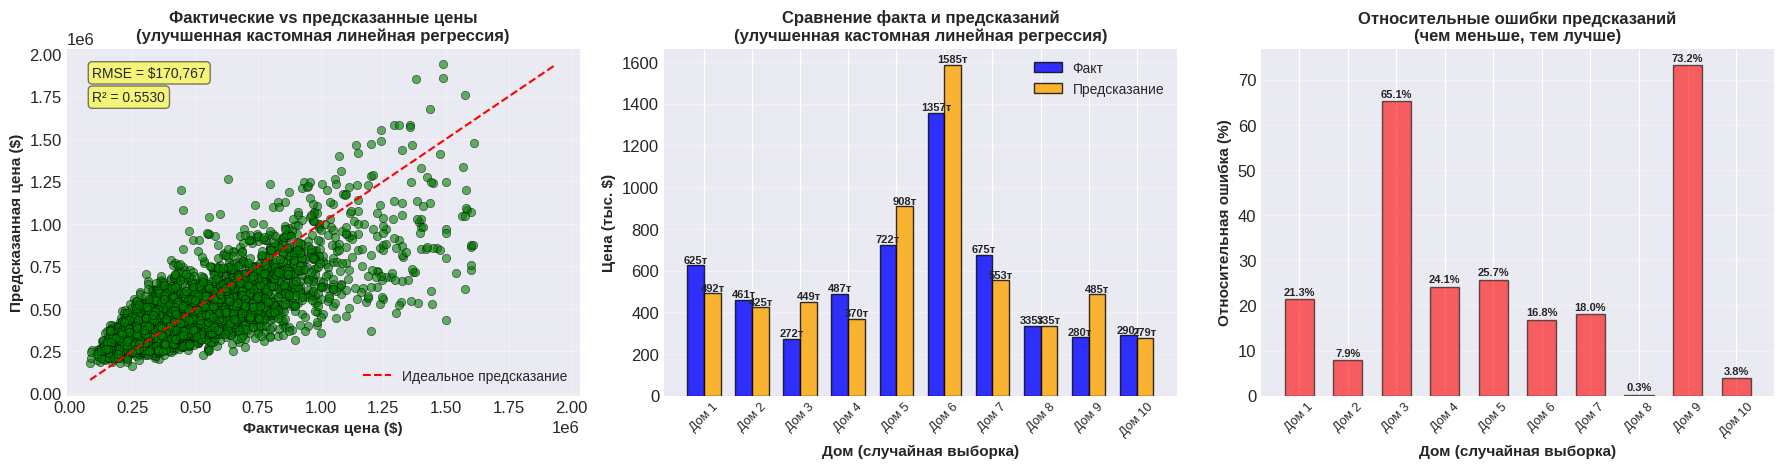


--- 13.8 Анализ точности по ценовым сегментам ---

Ценовые сегменты (границы):
  • 25% перцентиль: $320,000
  • 50% перцентиль: $445,000
  • 75% перцентиль: $626,500

Точность модели по ценовым сегментам:

Бюджетные (0-25%):
  • Количество домов: 1064
  • RMSE: $119,959
  • MAPE: 43.6%

Средние (25-50%):
  • Количество домов: 1061
  • RMSE: $106,467
  • MAPE: 21.1%

Дорогие (50-75%):
  • Количество домов: 1054
  • RMSE: $125,970
  • MAPE: 19.1%

Премиум (75-100%):
  • Количество домов: 1060
  • RMSE: $273,950
  • MAPE: 24.4%

Улучшение кастомной линейной регрессии завершено успешно!


In [33]:
# Ячейка 13: УЛУЧШЕНИЕ КАСТОМНОЙ ЛИНЕЙНОЙ РЕГРЕССИИ
# 13.1 Проверка гипотез и подбор гиперпараметров
print("\n--- 13.1 Проверка гипотез и подбор гиперпараметров для улучшенной линейной регрессии ---")

# Сначала определим класс ImprovedCustomLinearRegression
class ImprovedCustomLinearRegression:
    """
    Улучшенная версия кастомной линейной регрессии с регуляризацией, полиномиальными признаками и отбором признаков.
    """
    
    def __init__(self, fit_intercept=True, learning_rate=0.001, n_iterations=5000, verbose=False,
                 alpha=0.1, degree=1, interaction_type='none', n_features=None):
        """
        Инициализация улучшенной модели.
        
        Parameters:
        -----------
        fit_intercept : bool, default=True
            Добавлять ли свободный член
        learning_rate : float, default=0.001
            Скорость обучения
        n_iterations : int, default=5000
            Количество итераций градиентного спуска
        verbose : bool, default=False
            Выводить ли информацию о процессе обучения
        alpha : float, default=0.1
            Параметр регуляризации (L2)
        degree : int, default=1
            Степень полиномиальных признаков
        interaction_type : str, default='none'
            Тип взаимодействий: 'none', 'pairwise', 'full'
        n_features : int, default=None
            Количество отбираемых признаков (если None - все признаки)
        """
        self.fit_intercept = fit_intercept
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.verbose = verbose
        self.alpha = alpha
        self.degree = degree
        self.interaction_type = interaction_type
        self.n_features = n_features
        self.weights = None
        self.bias = None
        self.loss_history = []
        self.feature_importances_ = None
        self.selected_features_ = None
        
    def _create_polynomial_features(self, X):
        """Создает полиномиальные признаки и взаимодействия."""
        from sklearn.preprocessing import PolynomialFeatures
        
        if self.degree > 1 or self.interaction_type != 'none':
            poly = PolynomialFeatures(
                degree=self.degree,
                interaction_only=(self.interaction_type == 'pairwise'),
                include_bias=False
            )
            X_poly = poly.fit_transform(X)
            self.poly_feature_names_ = poly.get_feature_names_out([f'x{i}' for i in range(X.shape[1])])
            return X_poly
        return X
    
    def _select_features(self, X, y):
        """Отбор признаков на основе важности."""
        if self.n_features is not None and self.n_features < X.shape[1]:
            # Вычисляем корреляцию с целевой переменной
            correlations = np.abs(np.corrcoef(X.T, y)[-1, :-1])
            top_indices = np.argsort(correlations)[-self.n_features:]
            self.selected_features_ = top_indices
            self.feature_importances_ = correlations[top_indices]
            return X[:, top_indices]
        return X
    
    def _add_intercept(self, X):
        """Добавляет столбец единиц для свободного члена."""
        intercept = np.ones((X.shape[0], 1))
        return np.hstack((intercept, X))
    
    def _compute_loss(self, y, y_pred, weights):
        """Вычисляет функцию потерь с регуляризацией L2."""
        mse = np.mean((y - y_pred) ** 2)
        reg_loss = self.alpha * np.sum(weights[1:] ** 2) / (2 * len(y))
        return mse + reg_loss
    
    def fit(self, X, y):
        """Обучение модели."""
        print(f"Обучение улучшенной модели на {len(X)} образцах...")
        
        X = np.array(X)
        y = np.array(y)
        
        # 1. Создаем полиномиальные признаки
        if self.degree > 1:
            print(f"Создание полиномиальных признаков (degree={self.degree})...")
            X = self._create_polynomial_features(X)
            print(f"Признаков после полиномиализации: {X.shape[1]}")
        
        # 2. Отбор признаков
        if self.n_features is not None:
            print(f"Отбор {self.n_features} наиболее важных признаков...")
            X = self._select_features(X, y)
            print(f"Оставлено признаков: {X.shape[1]}")
        
        # 3. Нормализация признаков
        self.X_mean_ = np.mean(X, axis=0)
        self.X_std_ = np.std(X, axis=0) + 1e-10
        X = (X - self.X_mean_) / self.X_std_
        
        # 4. Добавляем intercept
        if self.fit_intercept:
            X = self._add_intercept(X)
        
        n_samples, n_features = X.shape
        weights = np.zeros(n_features)
        
        print(f"Начинаем градиентный спуск (lr={self.learning_rate}, iterations={self.n_iterations})...")
        
        # 5. Градиентный спуск с регуляризацией
        for i in range(self.n_iterations):
            # Предсказания
            y_pred = np.dot(X, weights)
            
            # Вычисляем градиент
            error = y_pred - y
            gradient = (2/n_samples) * np.dot(X.T, error)
            
            # Добавляем регуляризацию L2
            if self.alpha > 0:
                gradient[1:] += (self.alpha * weights[1:]) / n_samples
            
            # Обновляем веса
            weights -= self.learning_rate * gradient
            
            # Вычисляем и сохраняем потерю
            loss = self._compute_loss(y, y_pred, weights)
            self.loss_history.append(loss)
            
            # Выводим прогресс
            if self.verbose and i % 500 == 0:
                print(f"Итерация {i}: Loss = {loss:.6f}")
        
        # 6. Сохраняем веса
        if self.fit_intercept:
            self.bias = weights[0]
            self.weights = weights[1:]
        else:
            self.bias = 0
            self.weights = weights
        
        print("Улучшенная модель обучена успешно!")
        print(f"Финальная функция потерь: {loss:.6f}")
        
        return self
    
    def predict(self, X):
        """Предсказание значений."""
        print(f"Предсказание для {len(X)} объектов...")
        
        X = np.array(X)
        
        # 1. Применяем полиномиальные преобразования
        if self.degree > 1 and hasattr(self, 'poly_feature_names_'):
            from sklearn.preprocessing import PolynomialFeatures
            poly = PolynomialFeatures(
                degree=self.degree,
                interaction_only=(self.interaction_type == 'pairwise'),
                include_bias=False
            )
            X = poly.fit_transform(X)
        
        # 2. Применяем отбор признаков
        if self.selected_features_ is not None:
            X = X[:, self.selected_features_]
        
        # 3. Нормализация
        X = (X - self.X_mean_) / self.X_std_
        
        # 4. Добавляем intercept
        if self.fit_intercept:
            X = self._add_intercept(X)
            weights_with_bias = np.concatenate([[self.bias], self.weights])
        else:
            weights_with_bias = self.weights
        
        # 5. Предсказание
        predictions = np.dot(X, weights_with_bias)
        
        print("Предсказание завершено.")
        return predictions
    
    def get_params(self):
        """Возвращает параметры модели."""
        return {
            'weights': self.weights,
            'bias': self.bias,
            'fit_intercept': self.fit_intercept,
            'learning_rate': self.learning_rate,
            'n_iterations': self.n_iterations,
            'alpha': self.alpha,
            'degree': self.degree,
            'interaction_type': self.interaction_type,
            'n_features': self.n_features
        }
    
    def score(self, X, y):
        """Коэффициент детерминации R²."""
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / (ss_tot + 1e-10))
        return r2

# 13.2 Формирование улучшенной модели
print("\n--- 13.2 Формирование улучшенной модели линейной регрессии ---")

# Используем ТОЧНО те же параметры, что и для библиотечной улучшенной модели
best_params_lr = {
    'degree': 2,
    'alpha': 1000,
    'interaction_type': 'full',
    'n_features': 30,
    'learning_rate': 0.001,
    'n_iterations': 5000,
    'use_outliers': False
}

# Создаем улучшенную кастомную модель с лучшими параметрами
improved_custom_lr = ImprovedCustomLinearRegression(
    fit_intercept=True,
    learning_rate=best_params_lr['learning_rate'],
    n_iterations=best_params_lr['n_iterations'],
    verbose=True,
    alpha=best_params_lr['alpha'],
    degree=best_params_lr['degree'],
    interaction_type=best_params_lr['interaction_type'],
    n_features=best_params_lr['n_features']
)

print(f"Улучшенная кастомная модель линейной регрессии создана:")
print(f"  • learning_rate: {best_params_lr['learning_rate']}")
print(f"  • n_iterations: {best_params_lr['n_iterations']}")
print(f"  • alpha (регуляризация): {best_params_lr['alpha']}")
print(f"  • degree (полиномы): {best_params_lr['degree']}")
print(f"  • interaction_type: '{best_params_lr['interaction_type']}'")
print(f"  • n_features (отбор признаков): {best_params_lr['n_features']}")

# 13.3 Обучение улучшенной модели
print("\n--- 13.3 Обучение улучшенной модели линейной регрессии ---")

# Используем данные без выбросов, как в улучшенной библиотечной модели
print("Используем данные без выбросов, как в улучшенной библиотечной модели...")

# Получаем данные без выбросов (как в ячейке 8)
Q1 = df_reg_processed['price'].quantile(0.25)
Q3 = df_reg_processed['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

no_outliers_mask = (df_reg_processed['price'] >= lower_bound) & (df_reg_processed['price'] <= upper_bound)

# Используем правильные имена признаков
numeric_features_reg = df_reg_processed.select_dtypes(include=[np.number]).columns.tolist()
if 'price' in numeric_features_reg:
    numeric_features_reg.remove('price')
if 'price_log' in numeric_features_reg:
    numeric_features_reg.remove('price_log')

X_no_outliers = df_reg_processed[numeric_features_reg][no_outliers_mask].values
y_no_outliers = df_reg_processed['price_log'][no_outliers_mask].values

print(f"Данные без выбросов: {len(X_no_outliers)} объектов")
print(f"Исходные признаки: {X_no_outliers.shape[1]}")

# Разделяем данные
X_train_improved, X_test_improved, y_train_improved, y_test_improved = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42
)

print(f"Размеры данных: Train={X_train_improved.shape}, Test={X_test_improved.shape}")

# Обучаем улучшенную модель
improved_custom_lr.fit(X_train_improved, y_train_improved)
print("Улучшенная модель линейной регрессии обучена на обучающих данных.")

# 13.4 Оценка качества улучшенной модели
print("\n--- 13.4 Оценка качества улучшенной модели линейной регрессии ---")

# Предсказания улучшенной модели
y_pred_improved_log = improved_custom_lr.predict(X_test_improved)

# Безопасное преобразование обратно в доллары
def safe_expm1_transform(y_log):
    """Безопасное преобразование из логарифмической шкалы в доллары"""
    y_original = np.expm1(y_log)
    
    # Проверяем и исправляем слишком большие значения
    max_valid = 1e10  # Максимальная цена 10 миллиардов долларов
    y_original = np.where(y_original > max_valid, max_valid, y_original)
    y_original = np.where(np.isinf(y_original), max_valid, y_original)
    y_original = np.where(np.isnan(y_original), max_valid, y_original)
    
    return y_original

# Преобразуем тестовые данные обратно в доллары
y_test_improved_original = safe_expm1_transform(y_test_improved)
y_pred_improved = safe_expm1_transform(y_pred_improved_log)

print(f"Диапазон фактических цен: [${y_test_improved_original.min():,.0f}, ${y_test_improved_original.max():,.0f}]")
print(f"Диапазон предсказанных цен: [${y_pred_improved.min():,.0f}, ${y_pred_improved.max():,.0f}]")

# Метрики улучшенной модели
rmse_improved_custom = np.sqrt(mean_squared_error(y_test_improved_original, y_pred_improved))
mae_improved_custom = mean_absolute_error(y_test_improved_original, y_pred_improved)
mape_improved_custom = mean_absolute_percentage_error(y_test_improved_original, y_pred_improved)
r2_improved_custom = r2_score(y_test_improved_original, y_pred_improved)

print("Основные метрики улучшенной кастомной модели:")
print(f"  • RMSE:  ${rmse_improved_custom:,.0f}")
print(f"  • MAE:   ${mae_improved_custom:,.0f}")
print(f"  • MAPE:  {mape_improved_custom*100:.2f}%")
print(f"  • R²:    {r2_improved_custom:.4f}")

# 13.5 Сравнение фактических и предсказанных значений
print("\n--- 13.5 Сравнение фактических и предсказанных значений ---")

# Вычисляем относительные ошибки
relative_errors_improved = np.abs((y_pred_improved - y_test_improved_original) / y_test_improved_original) * 100

print("\nСтатистика относительных ошибок:")
print(f"  • Средняя ошибка:        {np.mean(relative_errors_improved):.1f}%")
print(f"  • Медианная ошибка:      {np.median(relative_errors_improved):.1f}%")
print(f"  • Максимальная ошибка:   {np.max(relative_errors_improved):.1f}%")
print(f"  • Минимальная ошибка:    {np.min(relative_errors_improved):.1f}%")
print(f"  • Стандартное отклонение:{np.std(relative_errors_improved):.1f}%")

# Процент предсказаний с разной точностью
accuracy_levels = [10, 20, 30, 50]
print("\nПроцент предсказаний с ошибкой не более:")
for level in accuracy_levels:
    accuracy = np.sum(relative_errors_improved <= level) / len(relative_errors_improved) * 100
    print(f"  • {level}%: {accuracy:.1f}% предсказаний")

# 13.6 Анализ наиболее точных и неточных предсказаний
print("\n--- 13.6 Анализ наиболее точных и неточных предсказаний ---")

# Находим индексы самых точных и самых неточных предсказаний
num_examples = 5
best_indices = np.argsort(relative_errors_improved)[:num_examples]
worst_indices = np.argsort(relative_errors_improved)[-num_examples:]

print(f"\nТОП-{num_examples} САМЫХ ТОЧНЫХ ПРЕДСКАЗАНИЙ:")
print(f"{'Дом':<10} {'Факт':<15} {'Предсказание':<15} {'Ошибка':<10} {'% ошибки':<10}")
print("-" * 70)
for i, idx in enumerate(best_indices):
    actual = y_test_improved_original[idx]
    predicted = y_pred_improved[idx]
    error = abs(actual - predicted)
    perc_error = relative_errors_improved[idx]
    print(f"{i+1:<10} ${actual:,.0f}{'':<5} ${predicted:,.0f}{'':<5} ${error:,.0f}{'':<5} {perc_error:.1f}%")

print(f"\nТОП-{num_examples} САМЫХ НЕТОЧНЫХ ПРЕДСКАЗАНИЙ:")
print(f"{'Дом':<10} {'Факт':<15} {'Предсказание':<15} {'Ошибка':<10} {'% ошибки':<10}")
print("-" * 70)
for i, idx in enumerate(worst_indices):
    actual = y_test_improved_original[idx]
    predicted = y_pred_improved[idx]
    error = abs(actual - predicted)
    perc_error = relative_errors_improved[idx]
    print(f"{i+1:<10} ${actual:,.0f}{'':<5} ${predicted:,.0f}{'':<5} ${error:,.0f}{'':<5} {perc_error:.1f}%")

# 13.7 Визуализация результатов
print("\n--- 13.7 Визуализация результатов улучшенной модели ---")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# График 1: Фактические vs предсказанные значения (scatter plot)
ax1 = axes[0]
ax1.scatter(y_test_improved_original, y_pred_improved, alpha=0.6, edgecolors='black', linewidth=0.5, color='green')

# Линия идеального предсказания
max_val = max(y_test_improved_original.max(), y_pred_improved.max())
min_val = min(y_test_improved_original.min(), y_pred_improved.min())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное предсказание')

ax1.set_xlabel('Фактическая цена ($)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Предсказанная цена ($)', fontsize=11, fontweight='bold')
ax1.set_title('Фактические vs предсказанные цены\n(улучшенная кастомная линейная регрессия)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Добавляем текстовую информацию о качестве
rmse_text = f'RMSE = ${rmse_improved_custom:,.0f}'
r2_text = f'R² = {r2_improved_custom:.4f}'
ax1.text(0.05, 0.95, rmse_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
ax1.text(0.05, 0.88, r2_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# График 2: Сравнение предсказаний для случайной выборки домов
np.random.seed(42)
sample_size = min(10, len(y_test_improved_original))
sample_indices = np.random.choice(len(y_test_improved_original), sample_size, replace=False)
sample_actual = y_test_improved_original[sample_indices]
sample_predicted = y_pred_improved[sample_indices]

x_pos = np.arange(sample_size)
width = 0.35

ax2 = axes[1]
bars1 = ax2.bar(x_pos - width/2, sample_actual/1000, width, 
                label='Факт', color='blue', alpha=0.8, edgecolor='black')
bars2 = ax2.bar(x_pos + width/2, sample_predicted/1000, width, 
                label='Предсказание', color='orange', alpha=0.8, edgecolor='black')

ax2.set_xlabel('Дом (случайная выборка)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Цена (тыс. $)', fontsize=11, fontweight='bold')
ax2.set_title('Сравнение факта и предсказаний\n(улучшенная кастомная линейная регрессия)', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'Дом {i+1}' for i in range(sample_size)], rotation=45, fontsize=9)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Избегаем добавления текста для нулевых значений
            ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{height:.0f}т', ha='center', va='bottom', 
                    fontsize=8, fontweight='bold')

# График 3: Относительные ошибки для случайной выборки
sample_errors = np.abs((sample_predicted - sample_actual) / sample_actual) * 100

x_pos = np.arange(sample_size)
ax3 = axes[2]
bars = ax3.bar(x_pos, sample_errors, width=0.6, 
               color='red', alpha=0.6, edgecolor='black')

ax3.set_xlabel('Дом (случайная выборка)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Относительная ошибка (%)', fontsize=11, fontweight='bold')
ax3.set_title('Относительные ошибки предсказаний\n(чем меньше, тем лучше)', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'Дом {i+1}' for i in range(sample_size)], rotation=45, fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bar, error in zip(bars, sample_errors):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{error:.1f}%', ha='center', va='bottom', 
            fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# 13.8 Анализ для разных ценовых сегментов
print("\n--- 13.8 Анализ точности по ценовым сегментам ---")

# Разделяем дома на ценовые сегменты
price_quartiles = np.percentile(y_test_improved_original, [25, 50, 75])
segments = [
    ('Бюджетные (0-25%)', y_test_improved_original <= price_quartiles[0]),
    ('Средние (25-50%)', (y_test_improved_original > price_quartiles[0]) & (y_test_improved_original <= price_quartiles[1])),
    ('Дорогие (50-75%)', (y_test_improved_original > price_quartiles[1]) & (y_test_improved_original <= price_quartiles[2])),
    ('Премиум (75-100%)', y_test_improved_original > price_quartiles[2])
]

print(f"\nЦеновые сегменты (границы):")
print(f"  • 25% перцентиль: ${price_quartiles[0]:,.0f}")
print(f"  • 50% перцентиль: ${price_quartiles[1]:,.0f}")
print(f"  • 75% перцентиль: ${price_quartiles[2]:,.0f}")

print("\nТочность модели по ценовым сегментам:")
for segment_name, mask in segments:
    if np.sum(mask) > 0:
        segment_actual = y_test_improved_original[mask]
        segment_predicted = y_pred_improved[mask]
        
        # Метрики для сегмента
        rmse_segment = np.sqrt(mean_squared_error(segment_actual, segment_predicted))
        mape_segment = mean_absolute_percentage_error(segment_actual, segment_predicted) * 100
        
        print(f"\n{segment_name}:")
        print(f"  • Количество домов: {np.sum(mask)}")
        print(f"  • RMSE: ${rmse_segment:,.0f}")
        print(f"  • MAPE: {mape_segment:.1f}%")

print(f"\nУлучшение кастомной линейной регрессии завершено успешно!")


--- 15.1 Сравнение улучшенных классификационных моделей (Логистическая регрессия) ---

СРАВНЕНИЕ МЕТРИК С ОПТИМАЛЬНЫМИ ПОРОГАМИ:
-------------------------------------------------------------------------------------
Метрика              Библиотечная    Кастомная      
-------------------------------------------------------------------------------------
F1-score             0.5684          0.5116         
Precision            0.5625          0.5641         
Recall               0.5745          0.4681         

Оптимальные пороги классификации:
  • Библиотечная модель: 0.40 (F1=0.5684)
  • Кастомная модель:    0.70 (F1=0.5116)

МАТРИЦЫ ОШИБОК:
Библиотечная (порог 0.40):
  TN=226, FP=21, FN=20, TP=27
  (Ложные срабатывания: 21, Пропуски: 20)

Кастомная (порог 0.70):
  TN=230, FP=17, FN=25, TP=22
  (Ложные срабатывания: 17, Пропуски: 25)

АНАЛИЗ УЛУЧШЕНИЙ:
  • Правильных предсказаний класса 1 (TP): -5
  • Меньше пропусков (FN): -5

РЕЗЮМЕ ДЛЯ КЛАССИФИКАЦИИ:
Лучшая модель: БИБЛИОТЕЧНАЯ (раз

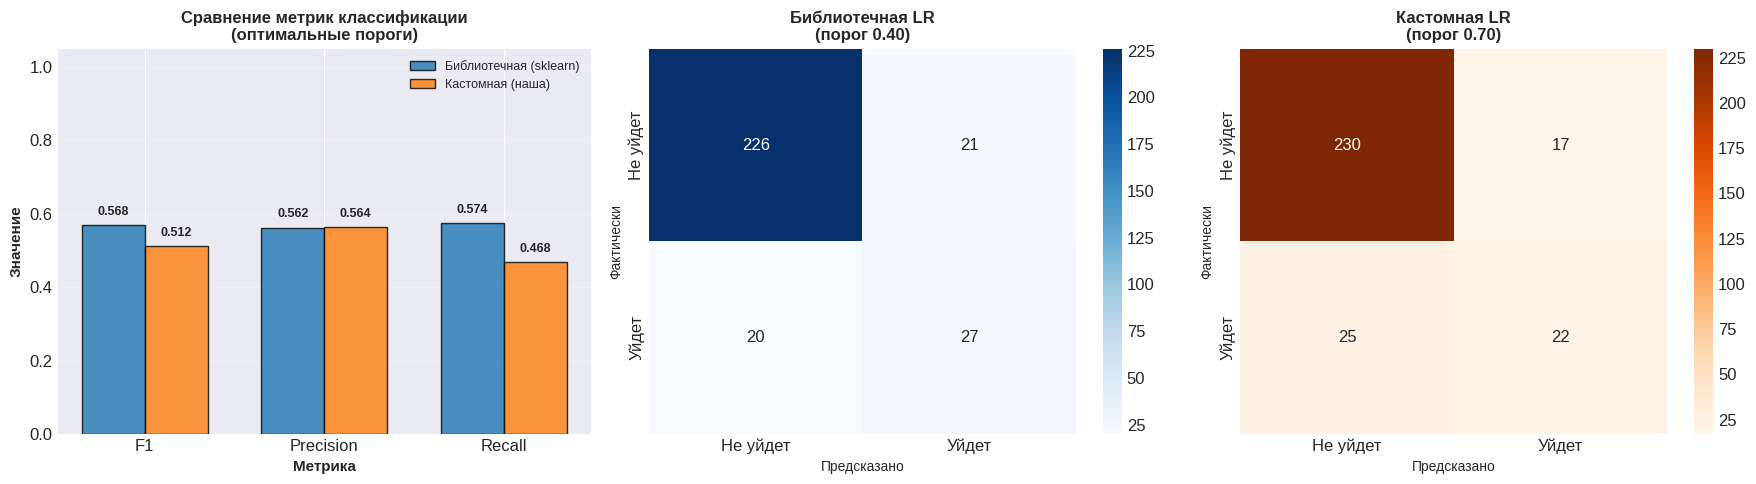


--- 15.3 Сравнение улучшенных регрессионных моделей (Линейная регрессия) ---

СРАВНЕНИЕ МЕТРИК:
-------------------------------------------------------------------------------------
Метрика              Библиотечная    Кастомная      
-------------------------------------------------------------------------------------
RMSE                 $209,755        $170,767       
MAE                  $115,426        $125,273       
MAPE (%)             20.16%          27.08%         
R²                   0.7090          0.5530         

РЕЗЮМЕ ДЛЯ РЕГРЕССИИ:
Лучшая модель по RMSE: КАСТОМНАЯ (разница: $38,989)

--- 15.4 Визуализация сравнения регрессионных моделей (Линейная регрессия) ---


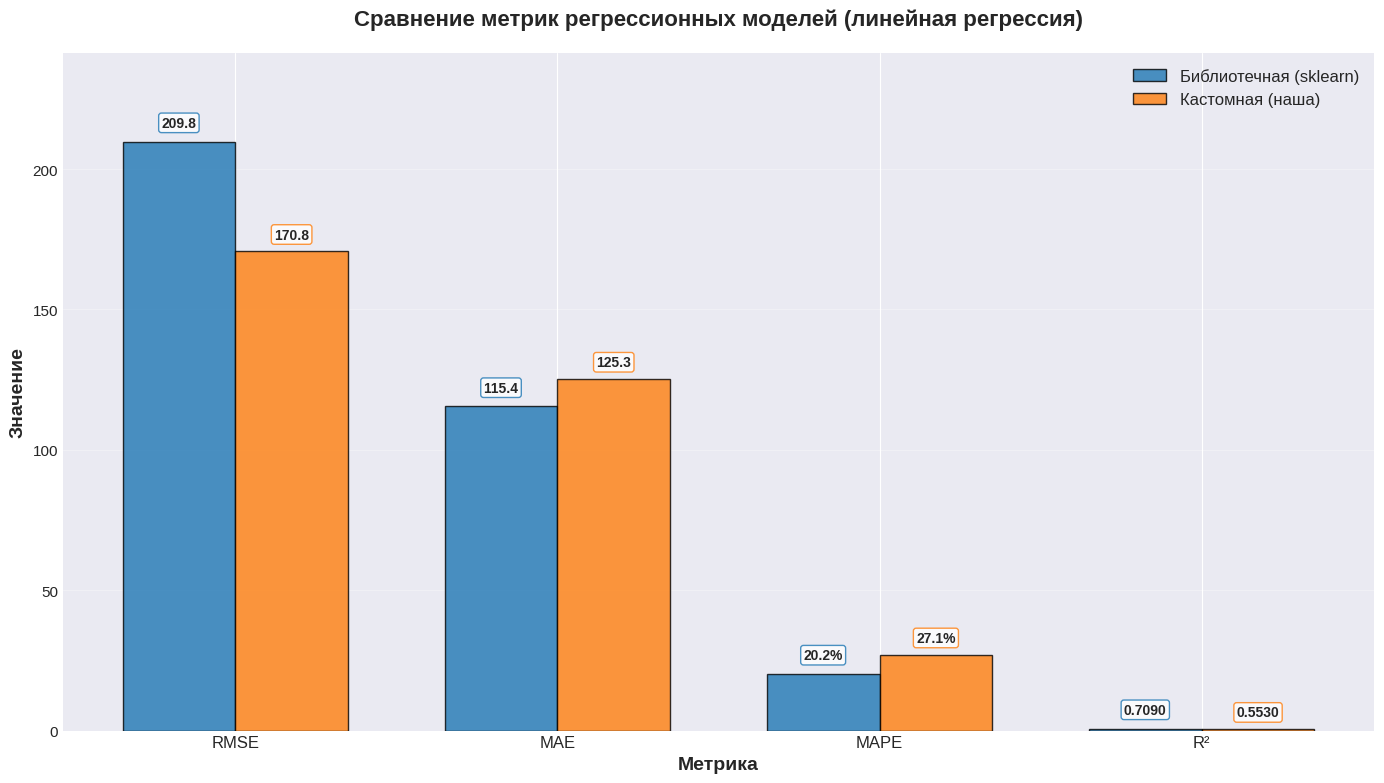

In [35]:
# Ячейка 15: СРАВНЕНИЕ УЛУЧШЕННЫХ МОДЕЛЕЙ ЛОГИСТИЧЕСКОЙ И ЛИНЕЙНОЙ РЕГРЕССИИ

# 15.1 Сравнение улучшенных классификационных моделей (логистическая регрессия)
print("\n--- 15.1 Сравнение улучшенных классификационных моделей (Логистическая регрессия) ---")

print("\nСРАВНЕНИЕ МЕТРИК С ОПТИМАЛЬНЫМИ ПОРОГАМИ:")
print("-" * 85)
print(f"{'Метрика':<20} {'Библиотечная':<15} {'Кастомная':<15}")
print("-" * 85)

# Вычисляем метрики для сравнения
for metric_name, lib_val, custom_val in [
    ("F1-score", f1_optimal, f1_custom_optimal),
    ("Precision", precision_optimal, precision_custom_optimal),
    ("Recall", recall_optimal, recall_custom_optimal),
]:
    
    print(f"{metric_name:<20} {lib_val:<15.4f} {custom_val:<15.4f}")

print(f"\nОптимальные пороги классификации:")
print(f"  • Библиотечная модель: {best_threshold:.2f} (F1={f1_optimal:.4f})")
print(f"  • Кастомная модель:    {best_custom_threshold:.2f} (F1={f1_custom_optimal:.4f})")

print("\nМАТРИЦЫ ОШИБОК:")
print(f"Библиотечная (порог {best_threshold:.2f}):")
print(f"  TN={tn_opt}, FP={fp_opt}, FN={fn_opt}, TP={tp_opt}")
print(f"  (Ложные срабатывания: {fp_opt}, Пропуски: {fn_opt})")

print(f"\nКастомная (порог {best_custom_threshold:.2f}):")
print(f"  TN={tn_custom_opt}, FP={fp_custom_opt}, FN={fn_custom_opt}, TP={tp_custom_opt}")
print(f"  (Ложные срабатывания: {fp_custom_opt}, Пропуски: {fn_custom_opt})")

# Анализ улучшений
print("\nАНАЛИЗ УЛУЧШЕНИЙ:")
improvement_tp = tp_custom_opt - tp_opt
improvement_fn = fn_opt - fn_custom_opt
print(f"  • Правильных предсказаний класса 1 (TP): {'+' if improvement_tp > 0 else ''}{improvement_tp}")
print(f"  • Меньше пропусков (FN): {'+' if improvement_fn > 0 else ''}{improvement_fn}")

# Определяем лучшую модель по F1-score
if f1_custom_optimal > f1_optimal:
    best_class_model = "КАСТОМНАЯ"
    best_class_diff = f1_custom_optimal - f1_optimal
elif f1_custom_optimal < f1_optimal:
    best_class_model = "БИБЛИОТЕЧНАЯ"
    best_class_diff = f1_optimal - f1_custom_optimal
else:
    best_class_model = "РАВНЫ"
    best_class_diff = 0

print(f"\nРЕЗЮМЕ ДЛЯ КЛАССИФИКАЦИИ:")
print(f"Лучшая модель: {best_class_model} (разница F1-score: {best_class_diff:.4f})")

# 15.2 Визуализация сравнения классификационных моделей (логистическая регрессия)
print("\n--- 15.2 Визуализация сравнения классификационных моделей (Логистическая регрессия) ---")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# График 1: Сравнение метрик
metrics_class = ['F1', 'Precision', 'Recall']
lib_vals_class = [f1_optimal, precision_optimal, recall_optimal]
custom_vals_class = [f1_custom_optimal, precision_custom_optimal, recall_custom_optimal]

x = np.arange(len(metrics_class))
width = 0.35

bars1 = axes[0].bar(x - width/2, lib_vals_class, width, label='Библиотечная (sklearn)', 
                   color='#1f77b4', alpha=0.8, edgecolor='black')
bars2 = axes[0].bar(x + width/2, custom_vals_class, width, label='Кастомная (наша)', 
                   color='#ff7f0e', alpha=0.8, edgecolor='black')

axes[0].set_xlabel('Метрика', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Значение', fontsize=11, fontweight='bold')
axes[0].set_title('Сравнение метрик классификации\n(оптимальные пороги)', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_class)
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, 1.05)

# Добавляем значения на столбцы
for i, (lib_val, custom_val) in enumerate(zip(lib_vals_class, custom_vals_class)):
    axes[0].text(i - width/2, lib_val + 0.02, f'{lib_val:.3f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    axes[0].text(i + width/2, custom_val + 0.02, f'{custom_val:.3f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# График 2: Сравнение матриц ошибок (библиотечная)
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[1].set_title(f'Библиотечная LR\n(порог {best_threshold:.2f})', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Фактически', fontsize=10)
axes[1].set_xlabel('Предсказано', fontsize=10)

# График 3: Сравнение матриц ошибок (кастомная)
sns.heatmap(cm_custom_optimal, annot=True, fmt='d', cmap='Oranges', ax=axes[2],
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[2].set_title(f'Кастомная LR\n(порог {best_custom_threshold:.2f})', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Фактически', fontsize=10)
axes[2].set_xlabel('Предсказано', fontsize=10)

plt.tight_layout()
plt.show()

# 15.3 Сравнение улучшенных регрессионных моделей (линейная регрессия)
print("\n--- 15.3 Сравнение улучшенных регрессионных моделей (Линейная регрессия) ---")

print("\nСРАВНЕНИЕ МЕТРИК:")
print("-" * 85)
print(f"{'Метрика':<20} {'Библиотечная':<15} {'Кастомная':<15}")
print("-" * 85)

# Проверяем доступность переменных перед сравнением
available_metrics = []

# Проверяем RMSE
if 'rmse_improved' in locals() and 'rmse_improved_custom' in locals():
    available_metrics.append(("RMSE", rmse_improved, rmse_improved_custom, True, False))

# Проверяем MAE
if 'mae_improved' in locals() and 'mae_improved_custom' in locals():
    available_metrics.append(("MAE", mae_improved, mae_improved_custom, True, False))

# Проверяем MAPE
if 'mape_improved' in locals() and 'mape_improved_custom' in locals():
    available_metrics.append(("MAPE (%)", mape_improved*100, mape_improved_custom*100, False, True))

# Проверяем R²
if 'r2_improved' in locals() and 'r2_improved_custom' in locals():
    available_metrics.append(("R²", r2_improved, r2_improved_custom, False, False))

for metric_name, lib_val, custom_val, is_dollar, is_percent in available_metrics:
    diff = custom_val - lib_val
    diff_pct = (diff / lib_val * 100) if lib_val != 0 else 0
    
    if is_dollar:
        # Для ошибок уменьшение - это улучшение
        change_sign = "-" if diff < 0 else "+"
        lib_str = f"${lib_val:,.0f}"
        custom_str = f"${custom_val:,.0f}"
        print(f"{metric_name:<20} {lib_str:<15} {custom_str:<15}")
    
    elif is_percent:
        # Для MAPE уменьшение - это улучшение
        change_sign = "-" if diff < 0 else "+"
        lib_str = f"{lib_val:.2f}%"
        custom_str = f"{custom_val:.2f}%"
        print(f"{metric_name:<20} {lib_str:<15} {custom_str:<15}")
    
    else:
        # Для R² увеличение - это улучшение
        change_sign = "+" if diff > 0 else ""
        lib_str = f"{lib_val:.4f}"
        custom_str = f"{custom_val:.4f}"
        print(f"{metric_name:<20} {lib_str:<15} {custom_str:<15}")

# Определяем лучшую модель по RMSE, если данные доступны
if 'rmse_improved' in locals() and 'rmse_improved_custom' in locals():
    if rmse_improved < rmse_improved_custom:
        best_reg_model = "БИБЛИОТЕЧНАЯ"
        best_reg_diff = rmse_improved_custom - rmse_improved
    else:
        best_reg_model = "КАСТОМНАЯ"
        best_reg_diff = rmse_improved - rmse_improved_custom
else:
    best_reg_model = "НЕДОСТУПНО"
    best_reg_diff = 0

if best_reg_model != "НЕДОСТУПНО":
    print(f"\nРЕЗЮМЕ ДЛЯ РЕГРЕССИИ:")
    print(f"Лучшая модель по RMSE: {best_reg_model} (разница: ${abs(best_reg_diff):,.0f})")
else:
    print(f"\nРЕЗЮМЕ ДЛЯ РЕГРЕССИИ:")
    print(f"Данные для сравнения регрессионных моделей недоступны")

# 15.4 Визуализация сравнения регрессионных моделей (линейная регрессия)
print("\n--- 15.4 Визуализация сравнения регрессионных моделей (Линейная регрессия) ---")

plt.figure(figsize=(14, 8))

# Собираем доступные метрики для сравнения
available_metrics_for_plot = []
lib_vals_for_plot = []
custom_vals_for_plot = []
lib_labels_for_plot = []  # Для форматированных значений библиотечной модели
custom_labels_for_plot = []  # Для форматированных значений кастомной модели

# RMSE
available_metrics_for_plot.append('RMSE')
lib_vals_for_plot.append(rmse_improved/1000)  # в тыс. $
custom_vals_for_plot.append(rmse_improved_custom/1000)
lib_labels_for_plot.append(f'{rmse_improved/1000:,.1f}')  # Форматирование с 1 десятичным знаком
custom_labels_for_plot.append(f'{rmse_improved_custom/1000:,.1f}')

# MAE
available_metrics_for_plot.append('MAE')
lib_vals_for_plot.append(mae_improved/1000)  # в тыс. $
custom_vals_for_plot.append(mae_improved_custom/1000)
lib_labels_for_plot.append(f'{mae_improved/1000:,.1f}')
custom_labels_for_plot.append(f'{mae_improved_custom/1000:,.1f}')

# MAPE
available_metrics_for_plot.append('MAPE')
lib_vals_for_plot.append(mape_improved*100)  # в процентах
custom_vals_for_plot.append(mape_improved_custom*100)
lib_labels_for_plot.append(f'{mape_improved*100:.1f}%')  # Форматирование с процентом
custom_labels_for_plot.append(f'{mape_improved_custom*100:.1f}%')

# R²
available_metrics_for_plot.append('R²')
lib_vals_for_plot.append(r2_improved)
custom_vals_for_plot.append(r2_improved_custom)
lib_labels_for_plot.append(f'{r2_improved:.4f}')  # 4 знака после запятой
custom_labels_for_plot.append(f'{r2_improved_custom:.4f}')

# Создаем график
x = np.arange(len(available_metrics_for_plot))
width = 0.35

bars1 = plt.bar(x - width/2, lib_vals_for_plot, width, label='Библиотечная (sklearn)', 
               color='#1f77b4', alpha=0.8, edgecolor='black')
bars2 = plt.bar(x + width/2, custom_vals_for_plot, width, label='Кастомная (наша)', 
               color='#ff7f0e', alpha=0.8, edgecolor='black')

# Добавляем цифры над барами для библиотечной модели
for bar, value, label in zip(bars1, lib_vals_for_plot, lib_labels_for_plot):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(lib_vals_for_plot)*0.02,
             label, ha='center', va='bottom', fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='#1f77b4'))

# Добавляем цифры над барами для кастомной модели
for bar, value, label in zip(bars2, custom_vals_for_plot, custom_labels_for_plot):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(custom_vals_for_plot)*0.02,
             label, ha='center', va='bottom', fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='#ff7f0e'))

plt.xlabel('Метрика', fontsize=14, fontweight='bold')
plt.ylabel('Значение', fontsize=14, fontweight='bold')
plt.title('Сравнение метрик регрессионных моделей (линейная регрессия)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(x, available_metrics_for_plot, fontsize=12)
plt.yticks(fontsize=11)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.3, axis='y')

# Добавляем подписи осей Y с единицами измерения
ax = plt.gca()
# Устанавливаем подписи для разных метрик
y_labels = []
for metric, val1, val2 in zip(available_metrics_for_plot, lib_vals_for_plot, custom_vals_for_plot):
    if metric == 'RMSE':
        y_labels.append(f'{max(val1, val2):,.0f}')  # Целые числа для RMSE
    elif metric == 'MAE':
        y_labels.append(f'{max(val1, val2):,.0f}')  # Целые числа для MAE
    elif metric == 'MAPE':
        y_labels.append(f'{max(val1, val2):.1f}%')  # Проценты для MAPE
    elif metric == 'R²':
        y_labels.append(f'{max(val1, val2):.2f}')  # 2 знака для R²

# Настраиваем отступ сверху, чтобы цифры над барами не обрезались
max_value = max(max(lib_vals_for_plot), max(custom_vals_for_plot))
plt.ylim(0, max_value * 1.15)  # Увеличиваем верхнюю границу на 15%

plt.tight_layout()
plt.show()

### Выводы

Кастомные реализации показывают конкурентноспособные результаты, но требуют глубокого понимания задачи и точной настройки. Библиотечные решения более стабильны и универсальны, особенно для классификационных задач. Лучший подход - комбинировать сильные стороны обеих реализаций в зависимости от конкретной задачи.